# Topic Modeling para cada desafío

En esta notebook se realiza Topic Modeling con una variedad de metodos:

1. Latent Semantic Analysis (LSA)
2. Latent Dirichlet Allocation (LDA)
1. BERTopic

In [1]:
%%capture
!pip install -r requirements.txt --user

In [2]:
import pandas as pd
import regex as re
import unidecode
import nltk
import spacy

In [3]:
df = pd.read_excel('datos.xlsx')[['ID','texto','desafio']]

In [4]:
# Limpieza
df.drop_duplicates(subset='texto', inplace=True)

# Quitando texto de mas en columna "desafio"
df['desafio'] = df['desafio'].apply(lambda x: re.findall('[0-9]+', x)[0])

# A str
df['texto'] = df['texto'].astype(str)

# Pre process and tokenization

In [5]:
%%capture
!python -m spacy download es_core_news_md

In [6]:
import stop_words as sw
stop_words = sw.get_stop_words('es')

def preprocess(textos, lemma=True, decode=True, alphanumeric=True, stopwords=True):
    
    """
    Preprocesado: solo quedarnos con lo alphanumerico, lemmatizado y sin stop words.
    
    Input: column with texts
      
    """
    if type(textos) == pd.core.series.Series: # si es una columna, lo pasa a lista
        textos = textos.astype(str).to_list()
        
    elif type(textos) == str: # si es un str, lo pasa a lista
        textos = [textos]

    nlp = spacy.load('es_core_news_md')

    pre_processed = []
    for text in textos:
        if lemma:
            text = nlp(text)
            text = [word.lemma_ for word in text]
            text = ' '.join(text)
        if decode:
            text = unidecode.unidecode(text.lower().strip())
        if alphanumeric:
            text = re.findall('\w+', text)
        if stopwords:
            text = [i for i in text if i not in stop_words]
        pre_processed.append(text)
        
    return pre_processed

In [7]:
df['prepro_text'] = preprocess(df['texto'])

# dict with desafio and its preprocesed texts
df_desafio = {}
for des in df.desafio.unique():
    value = df[df['desafio']==des].prepro_text.tolist()
    df_desafio[des] = value

# Exploratory Data Analysis

In [8]:
print('Cantidad de documentos por desafio:')
df['desafio'].value_counts()

Cantidad de documentos por desafio:


13    95
15    83
16    78
12    67
14    64
17    61
18    57
Name: desafio, dtype: int64

In [9]:
# Algunas funciones que seran de utilidad

import matplotlib.pyplot as plt
from collections import Counter
from pysentimiento import create_analyzer
from sentiment_analysis_spanish import sentiment_analysis


def plot_word(elements, frequencies, plot_title = 'Plot', N = 20):
    plt.barh(elements[:N][::-1], frequencies[:N][::-1])
    plt.title(plot_title)
    plt.show()
    

def analyse_sentiment_3d(phrase, sent = ['POS', 'NEG', 'NEU']):
    
    """ Predicts sentiment of phrase in three dimensions: POS, NEG, NEU. """
    
    analyzer = create_analyzer(task="sentiment", lang="es")
    
    predictions = []
    for s in sent:
        prediction = analyzer.predict(phrase).probas[s]
        predictions.append(prediction)
        print(f'{s}: {prediction}')

# Topic Modeling

### Functions

In [10]:
# Functions to get vectors.


from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import LatentDirichletAllocation


def words_wheights(model, documents, n_components):
    
    """
    Applys model on documents.
    
    n_components: number of components or topics.
    
    Output: Every topic's wheight for each word + each word label
    
    """
    
    # Create the TF-IDF matrix
    vectorizer = TfidfVectorizer()
    X = vectorizer.fit_transform(documents)

    # Perform Model
    model = model(n_components=n_components)
    model.fit(X)

    # Exchange key - value order
    terms = dict([(index, word) for word, index in vectorizer.vocabulary_.items()])

    all_words = []
    all_wheights = []

    for topic_idx, topic in enumerate(model.components_):
        
        # Labels of words (ordered by importance)
        words = [terms[i] for i in topic.argsort()[::-1]]
        all_words.append(words)
    
        # Wheights of words (ordered by importance)
        wheights = list(topic)
        wheights.sort(reverse=True)
        all_wheights.append(wheights)
        
    return all_words, all_wheights

In [11]:
# Functions to evaluate performance.

from numpy.linalg import norm
import numpy as np

def cos_similarity(A, B):
    cosine = np.dot(A,B)/(norm(A)*norm(B))
    return cosine


def evaluate_coherence(model, documents, n_topics):
    
    """
    Evaluate Model's Topic Coherence by calculating mean cosine similarity between
    every pair of topic's vectors.
    
    -------
    
    Input: model (LSA or LDA), documents (list of str), n_topics (number of topics)
    Output: average cosine similarity
    
    """
    
    # Create the TF-IDF matrix
    vectorizer = TfidfVectorizer()
    X = vectorizer.fit_transform(documents)

    # create an LSA model
    model = model(n_components=n_topics)

    # fit the LSA model to the preprocessed text data
    model.fit(X)

    # extract the topics from the LSA model
    topics = model.components_

    # initialize an empty list to store the topic coherence scores
    topic_coherence = []

    # cosine similarity between every pair of topics
    for i in range(topics.shape[0]):
        for i2 in range(topics.shape[0]):
            cos_sim = cos_similarity(topics[i], topics[i2])
            topic_coherence.append(cos_sim)
            
    return sum(topic_coherence)/len(topic_coherence)



from sklearn.decomposition import PCA

def visualize_topics(model, documents, num_top_words, n_components, des):
    
    """
    Allows to visualize in 2D the topic distribution.
    
    This applys PCA=2 to the topic vectors, and then plots them
    
    Input: 
    a. model (LSA or LDA)
    b. num_top_words (print Top K words more relevant to each topic)
    c. n_components (number of topics the model must find)
    
    """
    
    # Create the TF-IDF matrix
    vectorizer = TfidfVectorizer()
    X = vectorizer.fit_transform(documents)

    # create an LSA model
    model = model(n_components=n_components)

    # fit the LSA model to the preprocessed text data
    model.fit(X)
    
    # reduce dimensions using PCA
    pca = PCA(n_components=2)
    topic_vectors = pca.fit_transform(model.components_)
    
    # plot the topic vectors
    print('Every topic with its most relevant words.\n\n')
    plt.figure(figsize=(8, 6))
    for i in range(n_components):
        plt.scatter(topic_vectors[i, 0], topic_vectors[i, 1])
        word_weight = dict([(index, word) for word, index in vectorizer.vocabulary_ .items()])
        top_words = [word_weight[j] for j in model.components_[i].argsort()[:-num_top_words - 1:-1]]
        label = f' Topic {i}'
        print(f'Topic {i} = {", ".join(top_words)}\n')
        plt.annotate(label, xy=(topic_vectors[i, 0], topic_vectors[i, 1]))
    
    explained_var = pca.explained_variance_ratio_ * 100
    
    plt.title(f'Des {des} Topic Distribution')
    plt.xlabel(f'PCA 1 %{round(explained_var[0])}')
    plt.ylabel(f'PCA 2 %{round(explained_var[1])}')
    plt.show()

## 1. Latent Semantic Analysis

A continuacion, las palabras mas importantes para cada uno de los tópicos encontrados por LSA para cada uno de
los desafios.

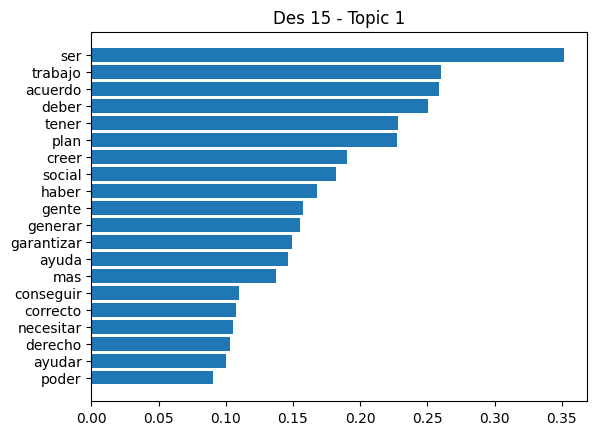

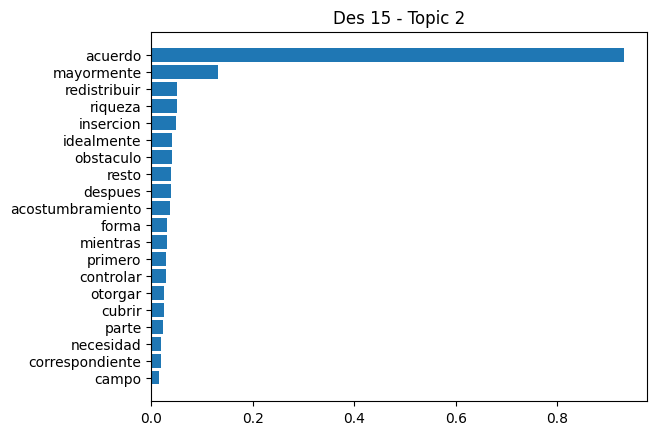

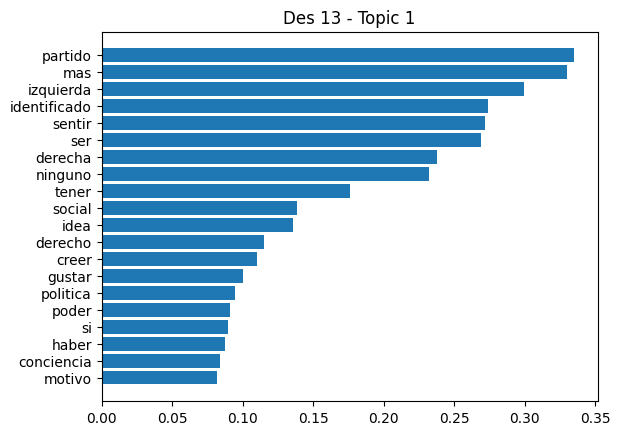

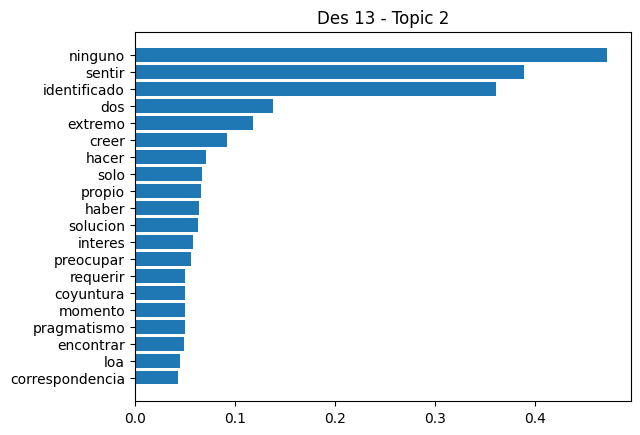

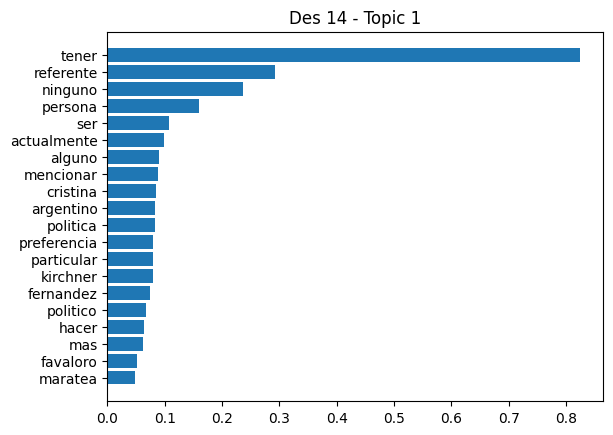

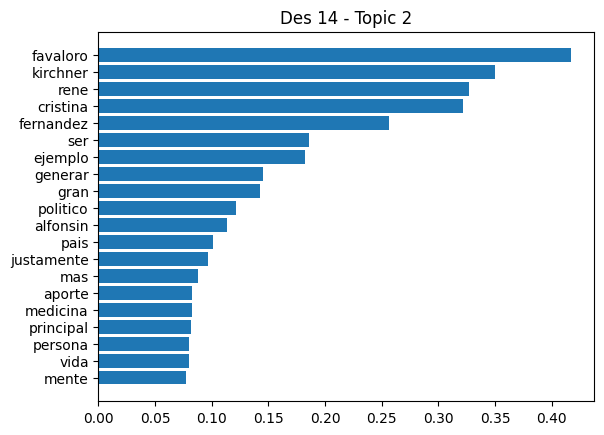

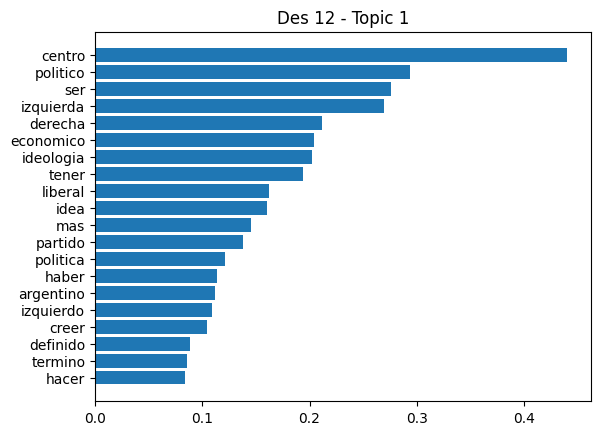

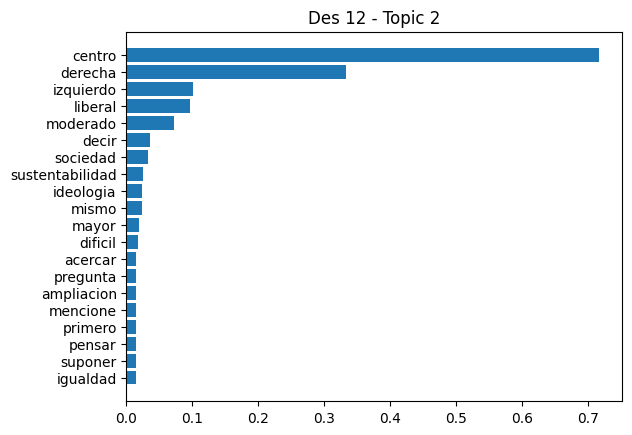

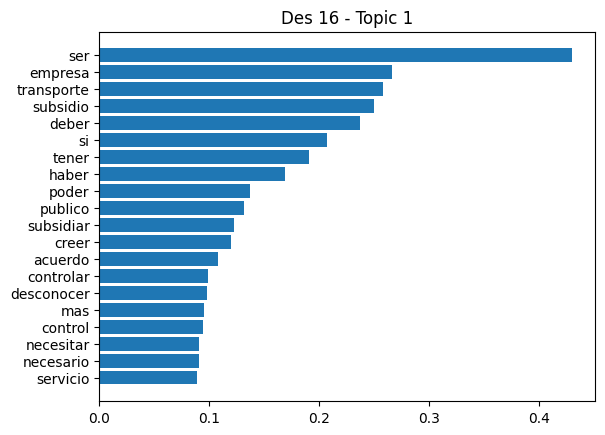

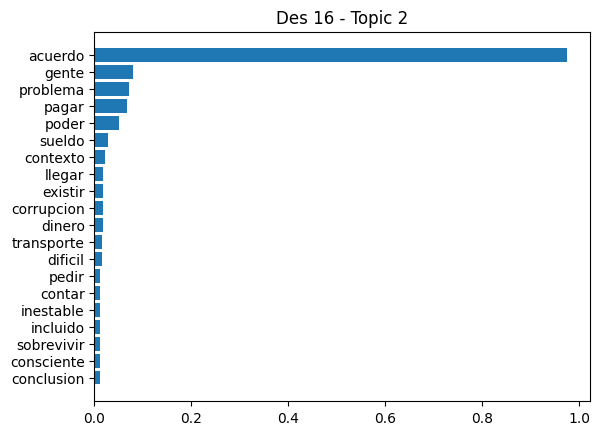

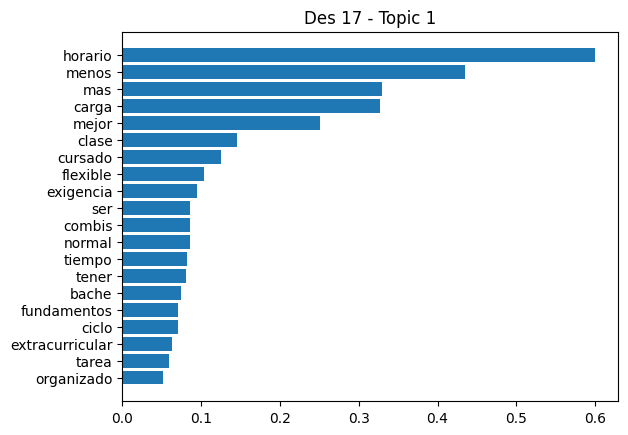

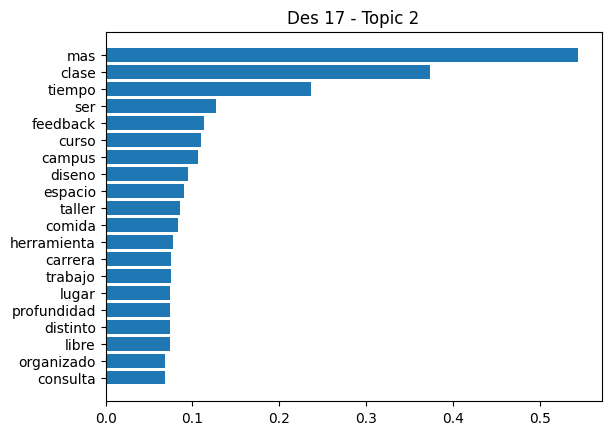

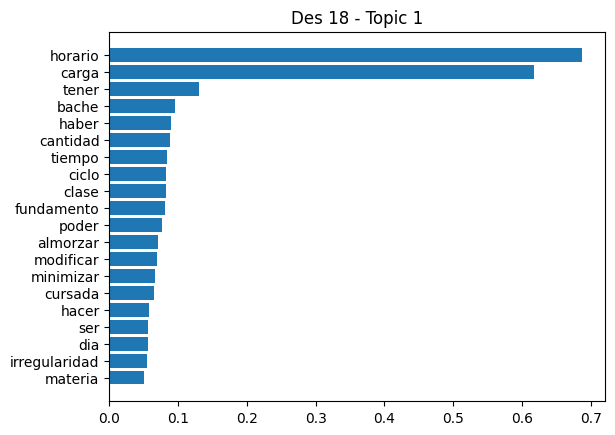

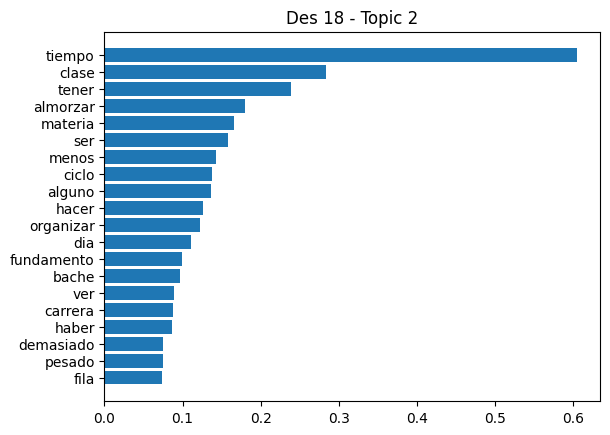

In [12]:
# Define data and model

n_components = 2 # nro de topicos a encontrar

for des, textos in df_desafio.items():
    
    documents = [' '.join(t) for t in textos]
    model = TruncatedSVD

    words, wheights = words_wheights(model, documents, n_components)


    for i in range(n_components):
        plot_word(words[i], wheights[i], plot_title = f'Des {des} - Topic {i+1}')

### Evaluacion

Recordemos que la cantidad de tópicos a encontrar es un hiperparametro. Para encontrar la cantidad óptima de tópicos, podemos realizar los siguientes pasos:

1. aumentar iterativamente la cantidad de tópicos a encontrar
2. evaluar la similitud coseno promedio entre todos los pares de tópicos (cuantos mas tópicos, menor sera la similitud promedio)
3. graficar la relacion entre cantidad de tópicos y similitud entre ellos
4. decidir el numero optimo de tópicos

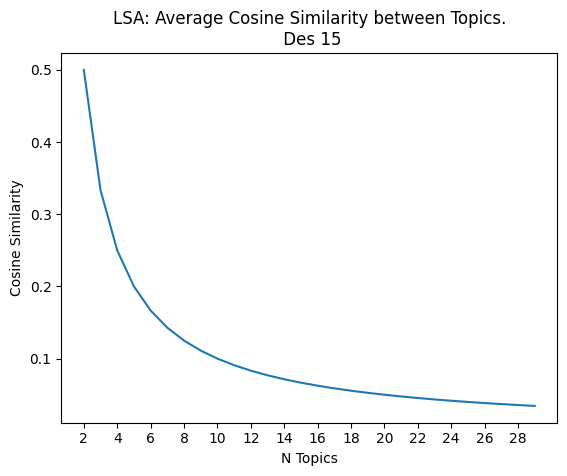

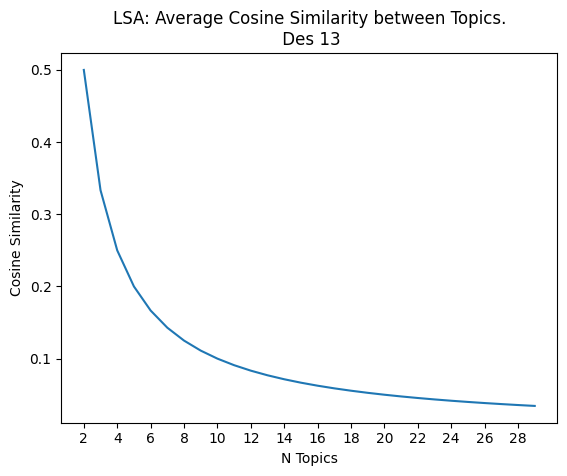

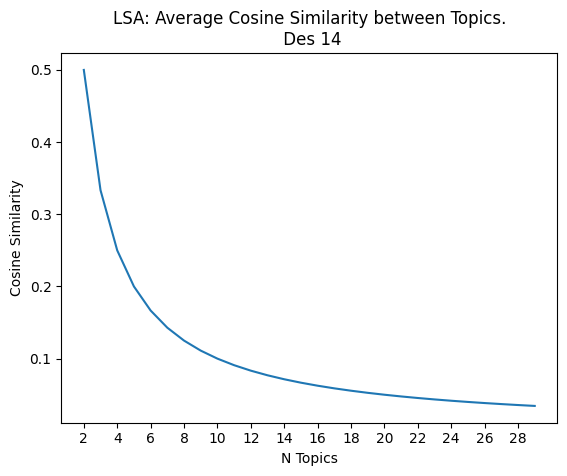

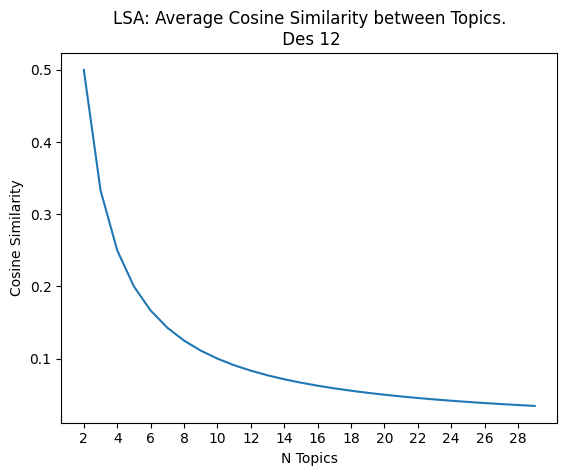

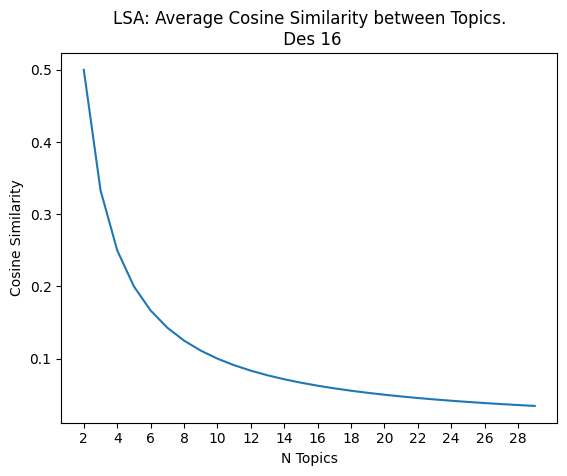

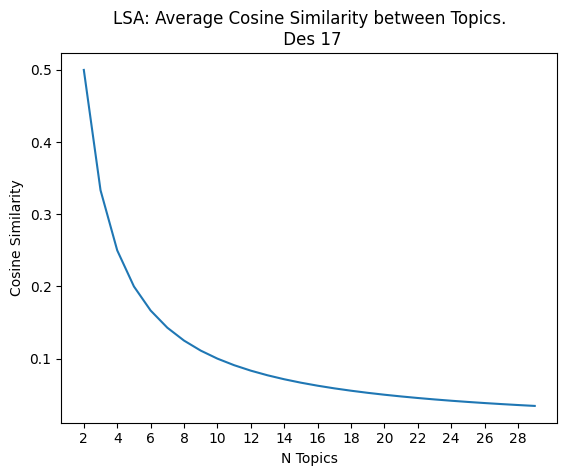

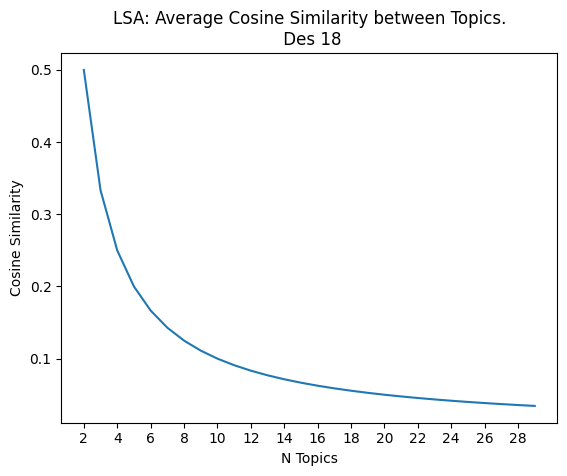

In [13]:
for des, textos in df_desafio.items():
    
    documents = [' '.join(t) for t in textos]
    
    n_topics = 30

    all_cs = []
    for i in range(2, n_topics):
        mean_cos_simil = evaluate_coherence(model, documents, n_topics = i)
        all_cs.append(mean_cos_simil)

    plt.plot(range(2, n_topics), all_cs)
    plt.title(f'LSA: Average Cosine Similarity between Topics.\n Des {des}')
    plt.xlabel('N Topics')
    plt.ylabel('Cosine Similarity')
    plt.xticks(range(2, n_topics, 2), range(2, n_topics, 2))
    plt.show()

Reducimos la dimensionalidad de los topicos en dos dimensiones y graficamos su distribucion

Every topic with its most relevant words.


Topic 0 = ser, trabajo, acuerdo

Topic 1 = acuerdo, mayormente, riqueza

Topic 2 = garantizar, deber, creer

Topic 3 = correcto, gente, querer



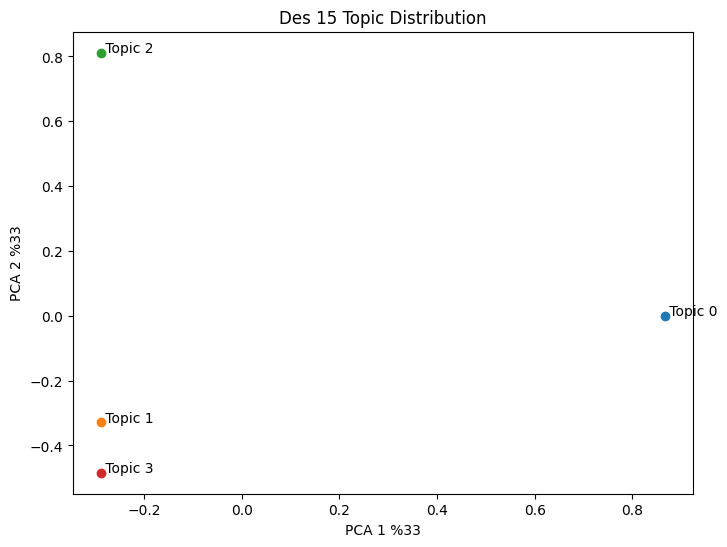

Every topic with its most relevant words.


Topic 0 = partido, mas, izquierda

Topic 1 = ninguno, sentir, identificado

Topic 2 = conciencia, social, tener

Topic 3 = ideologia, derecha, centro



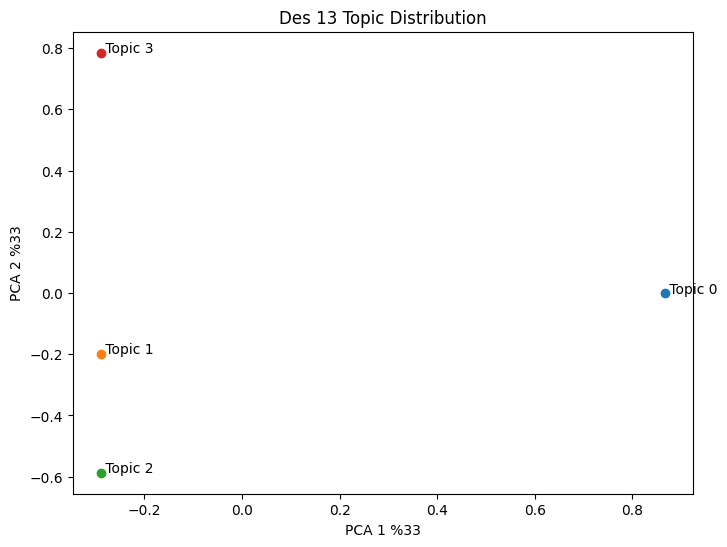

Every topic with its most relevant words.


Topic 0 = tener, referente, ninguno

Topic 1 = favaloro, kirchner, rene

Topic 2 = favaloro, rene, medicina

Topic 3 = ninguno, messi, actualmente



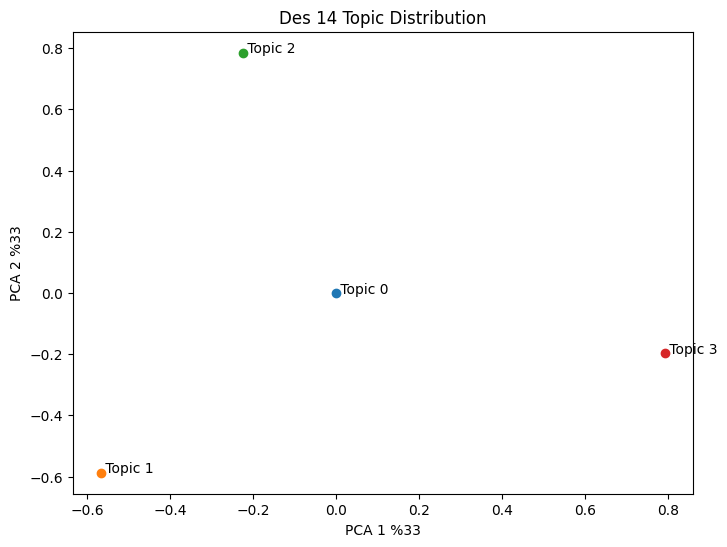

Every topic with its most relevant words.


Topic 0 = centro, politico, ser

Topic 1 = centro, derecha, izquierdo

Topic 2 = izquierda, estructuralista, latam

Topic 3 = peronista, hacer, pais



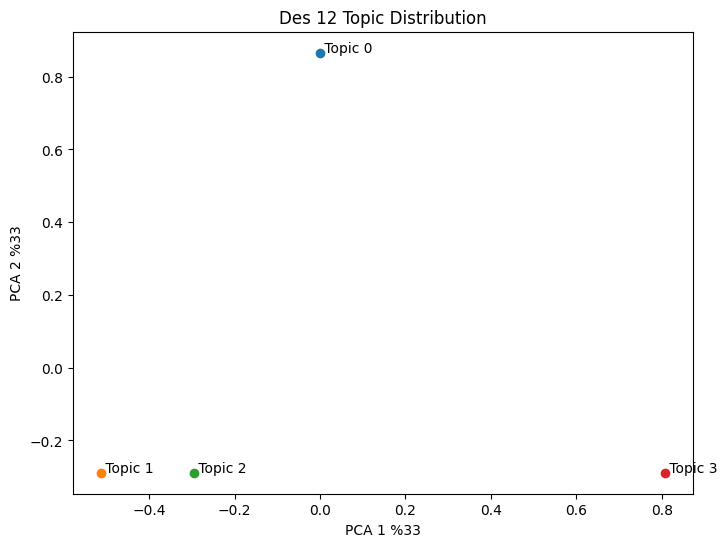

Every topic with its most relevant words.


Topic 0 = ser, empresa, transporte

Topic 1 = acuerdo, gente, problema

Topic 2 = opinion, responder, tener

Topic 3 = ser, subsidiar, bien



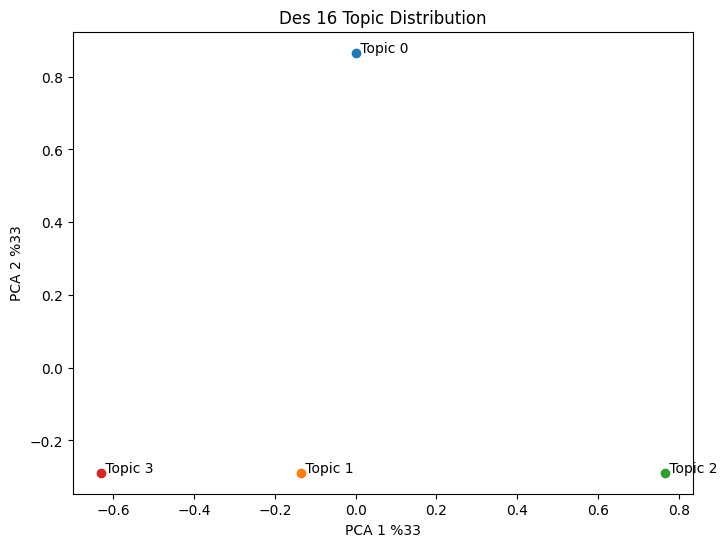

Every topic with its most relevant words.


Topic 0 = horario, menos, mas

Topic 1 = mas, clase, tiempo

Topic 2 = curso, diseno, extracurricular

Topic 3 = comida, kiosco, curso



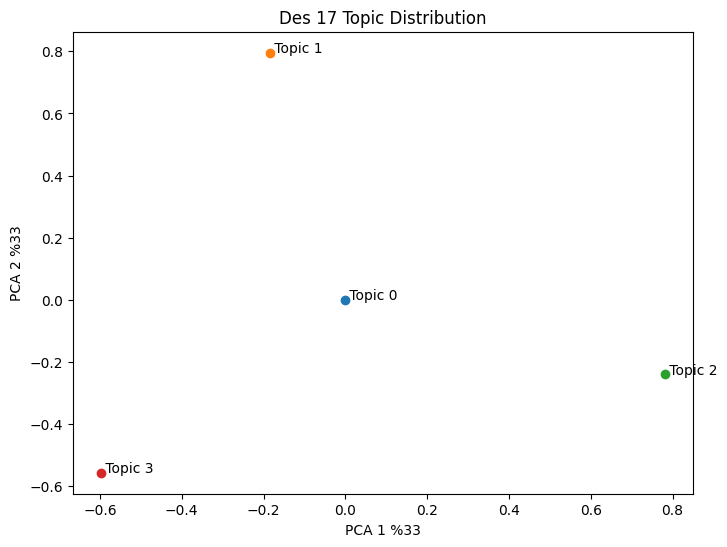

Every topic with its most relevant words.


Topic 0 = horario, carga, tener

Topic 1 = tiempo, clase, tener

Topic 2 = materia, fundamento, ciclo

Topic 3 = tiempo, ciclo, carga



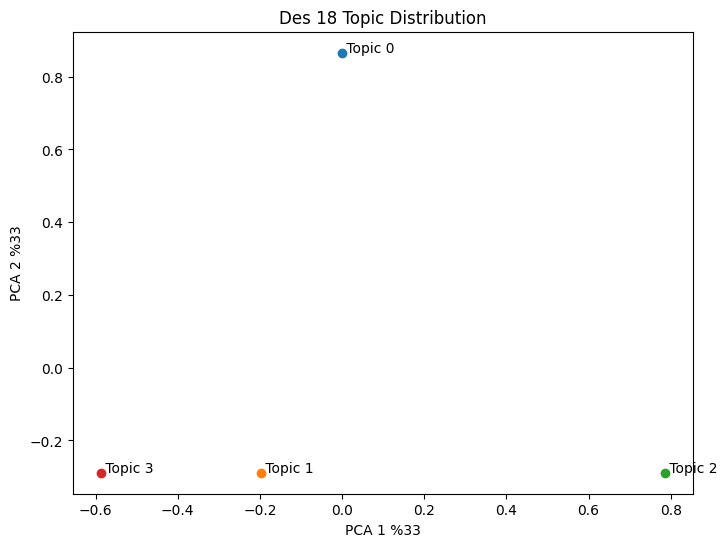

In [14]:
for des, textos in df_desafio.items():
    
    documents = [' '.join(t) for t in textos]
    
    num_top_words = 3

    visualize_topics(model, documents, num_top_words, n_components = 4, des=des) 

## 2. Latent Dirichlet  Allocation

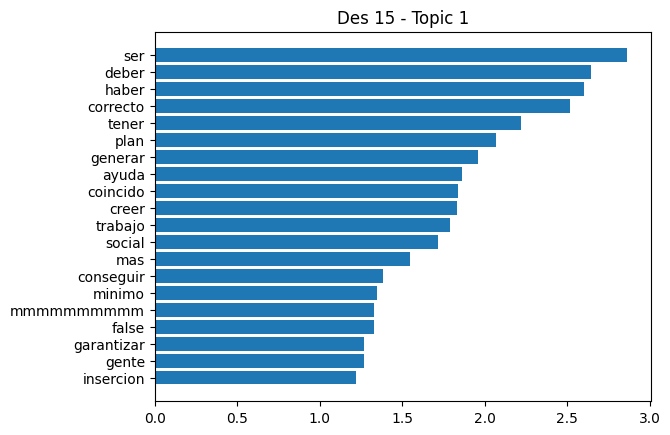

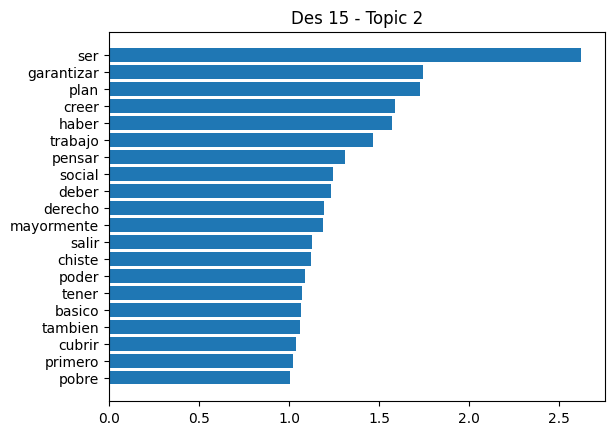

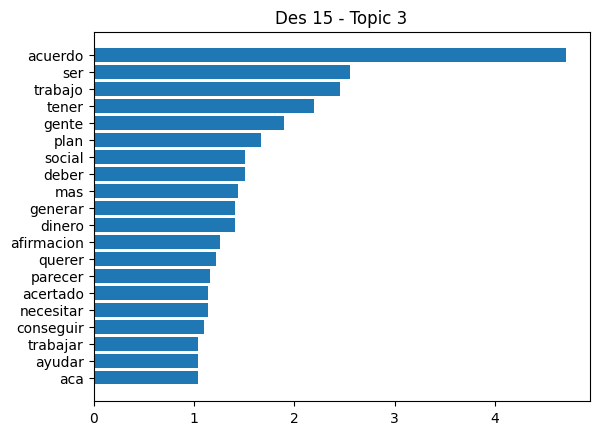

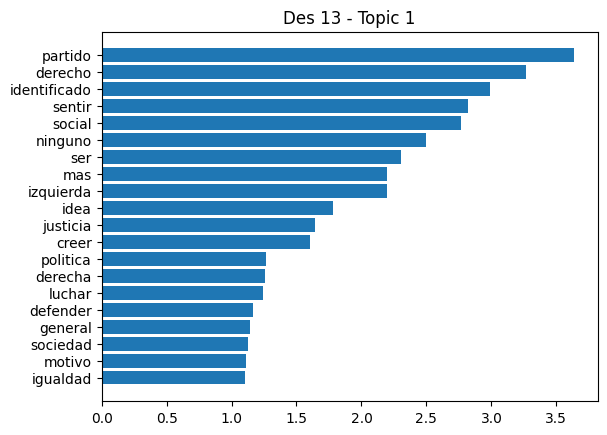

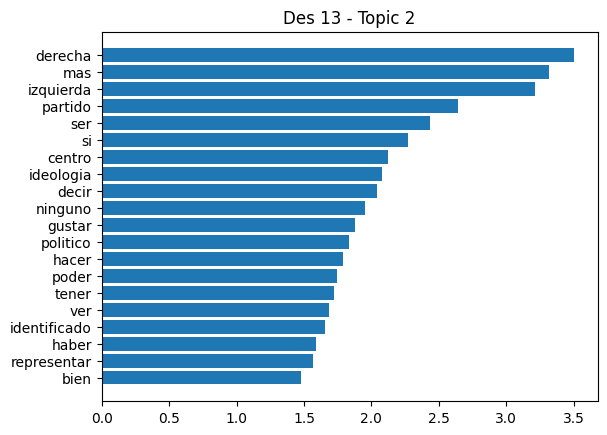

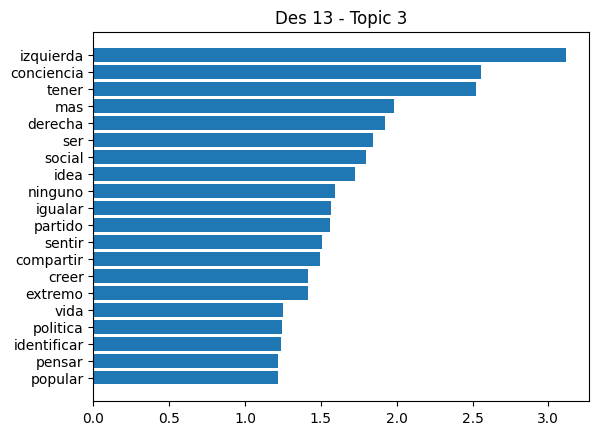

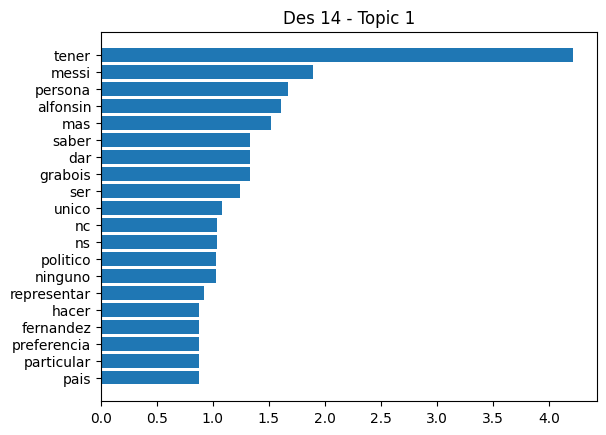

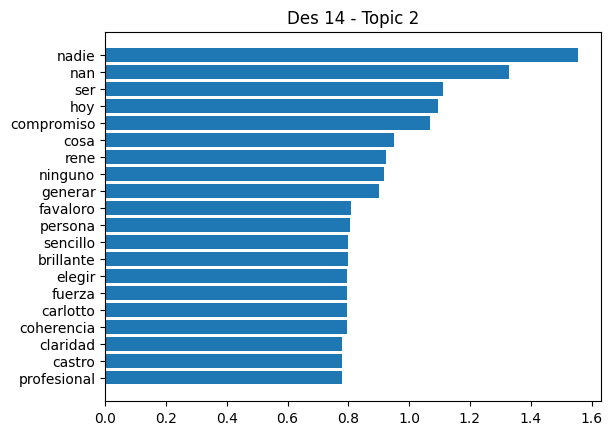

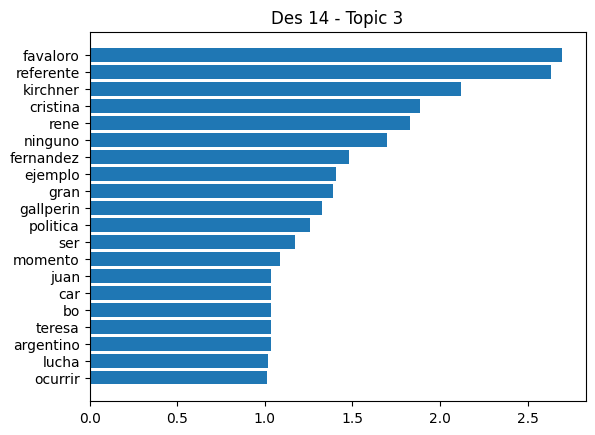

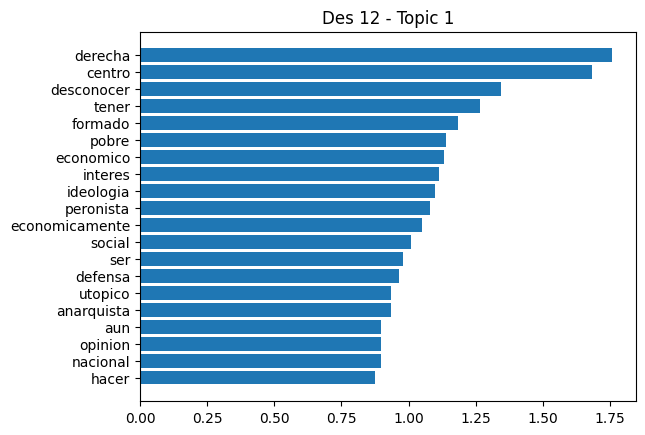

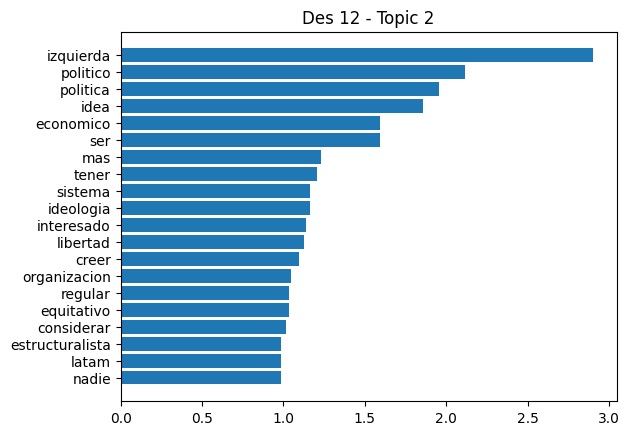

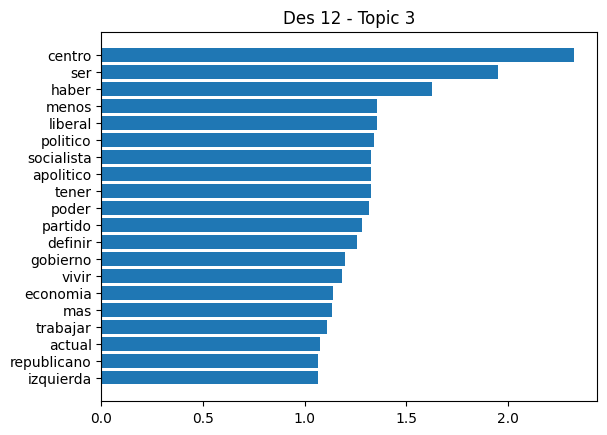

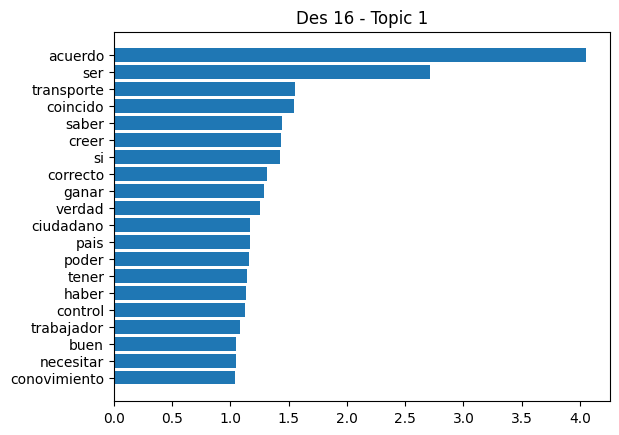

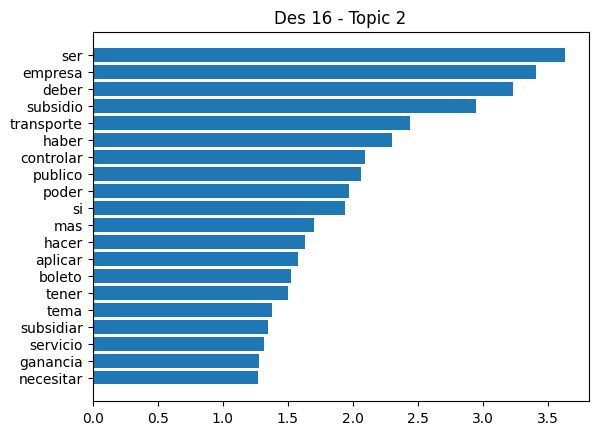

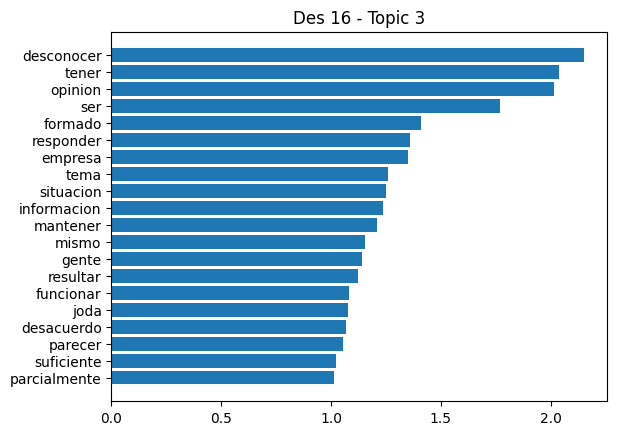

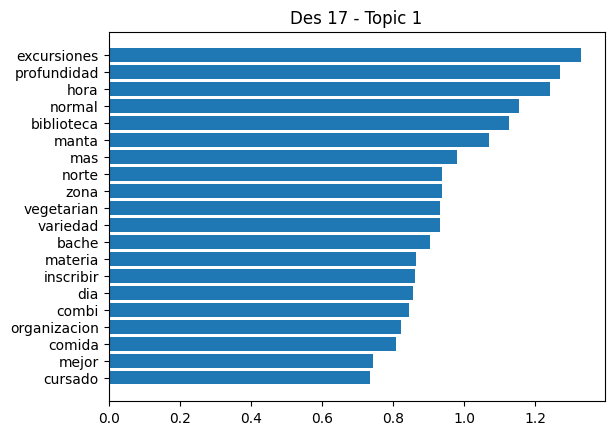

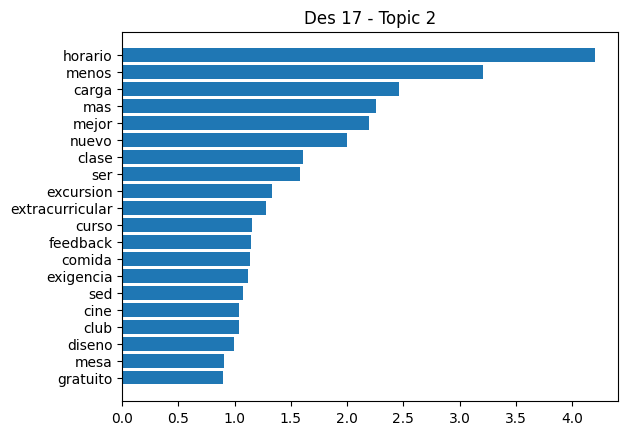

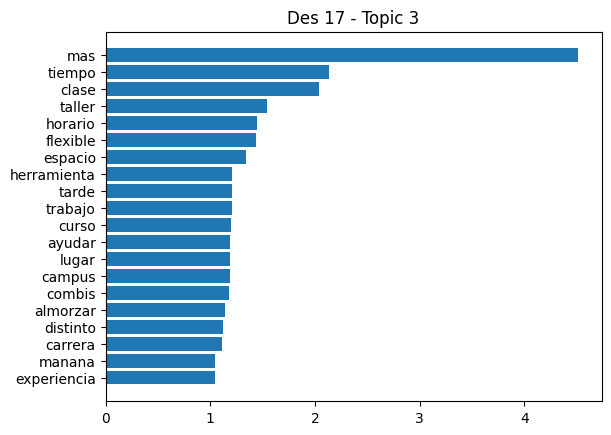

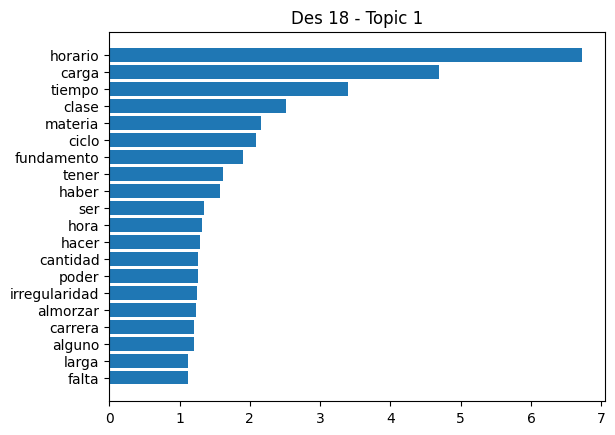

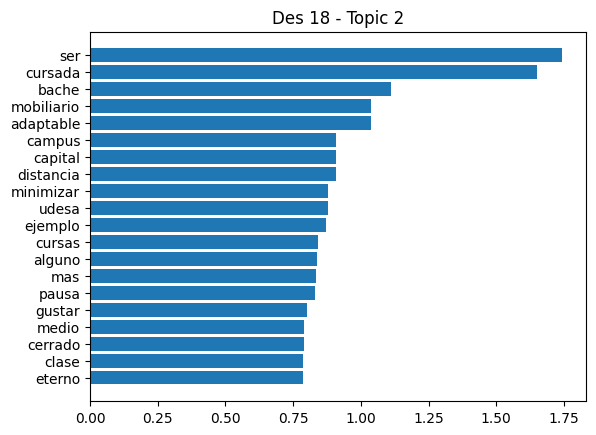

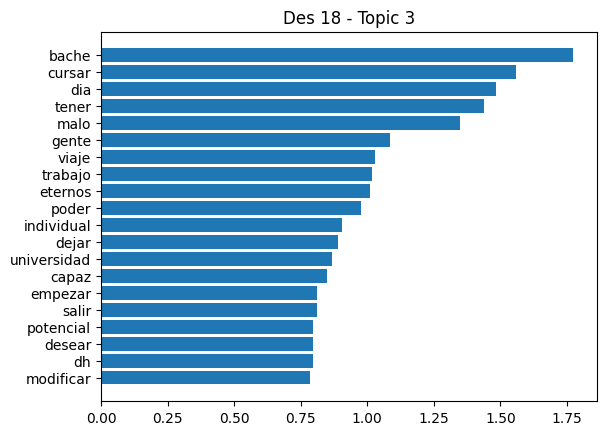

In [15]:
# Define data and model

n_components = 3

for des, textos in df_desafio.items():
    
    documents = [' '.join(t) for t in textos]
    model = LatentDirichletAllocation
    

    words, wheights = words_wheights(model, documents, n_components)
    
    for i in range(n_components):
        plot_word(words[i], wheights[i], plot_title = f'Des {des} - Topic {i+1}')

### Evaluacion

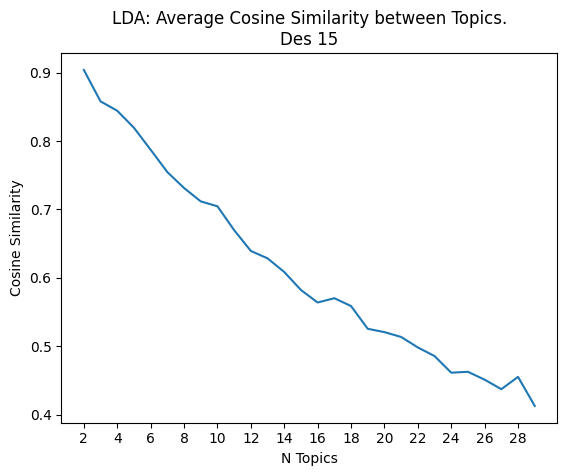

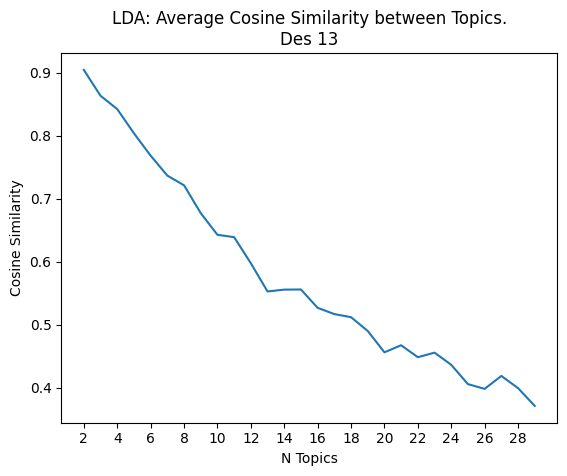

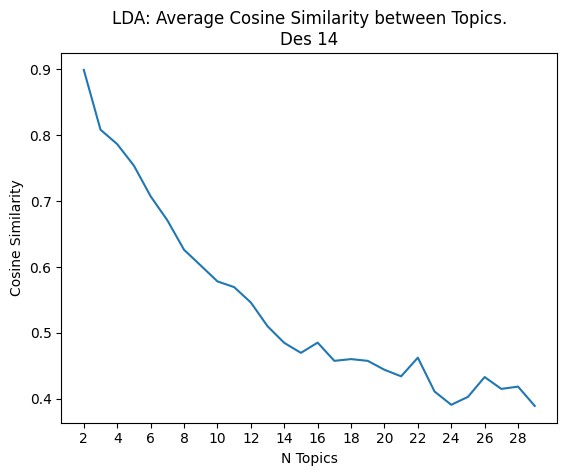

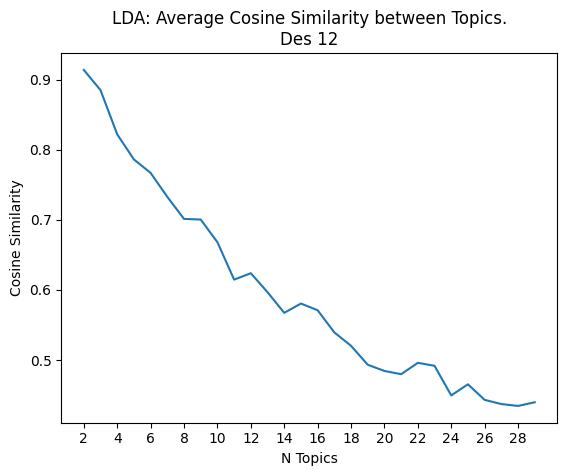

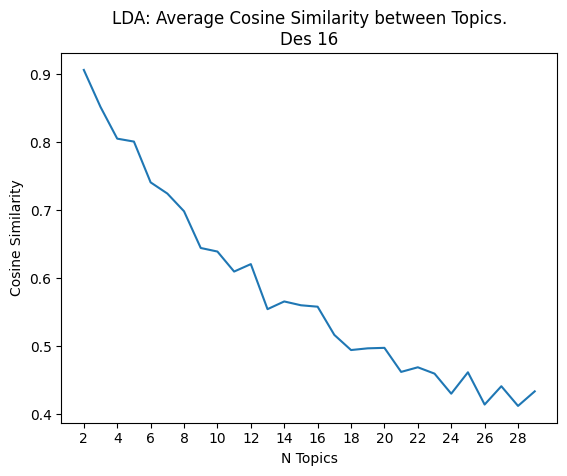

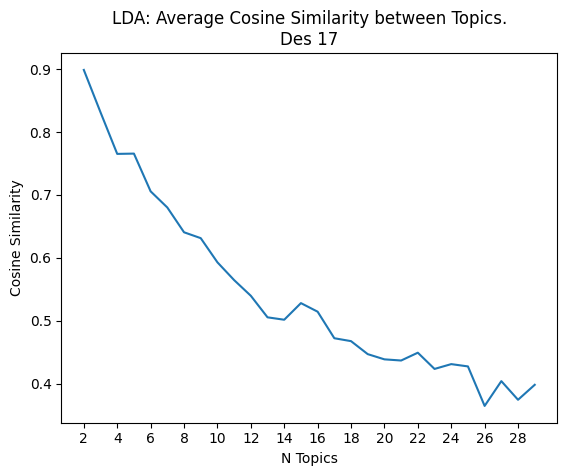

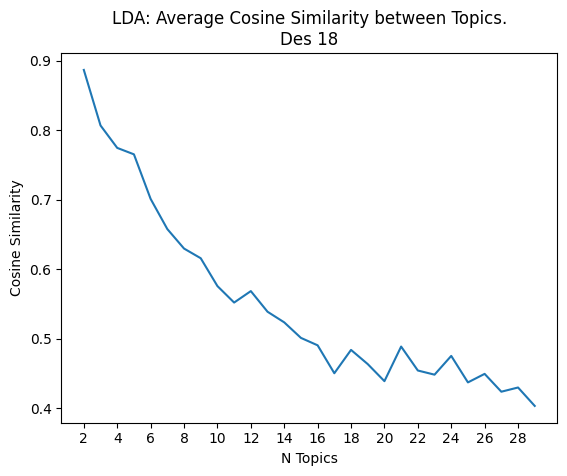

In [16]:
for des, textos in df_desafio.items():
    
    # Define data
    documents = [' '.join(t) for t in textos]

    n_topics = 30

    all_cs = []
    for i in range(2, n_topics):
        mean_cos_simil = evaluate_coherence(model, documents, n_topics = i)
        all_cs.append(mean_cos_simil)

    plt.plot(range(2, n_topics), all_cs)
    plt.title(f'LDA: Average Cosine Similarity between Topics.\nDes {des}')
    plt.xlabel('N Topics')
    plt.ylabel('Cosine Similarity')
    plt.xticks(range(2, n_topics, 2), range(2, n_topics, 2))
    plt.show()

Every topic with its most relevant words.


Topic 0 = ser, correcto, creer, haber

Topic 1 = trabajo, deber, ser, garantizar

Topic 2 = acuerdo, plan, tener, ser

Topic 3 = ser, deber, social, plan



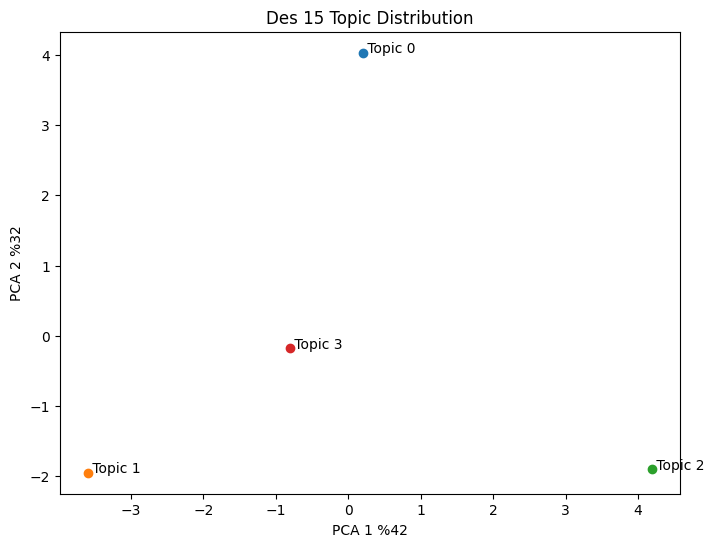

Every topic with its most relevant words.


Topic 0 = mas, izquierda, mmmmm, veces

Topic 1 = partido, derecha, identificado, sentir

Topic 2 = social, ser, partido, izquierda

Topic 3 = izquierda, tener, mas, ninguno



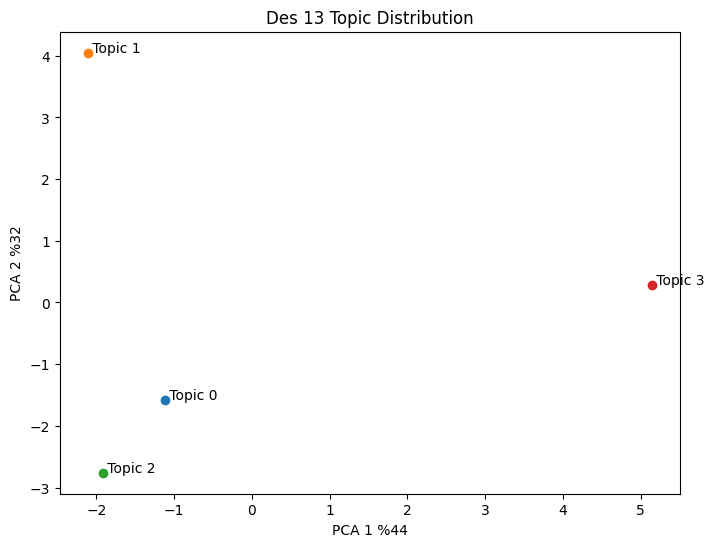

Every topic with its most relevant words.


Topic 0 = favaloro, fernandez, cristina, rene

Topic 1 = referente, gallperin, grabois, saber

Topic 2 = tener, alfonsin, nan, messi

Topic 3 = ninguno, tener, persona, dar



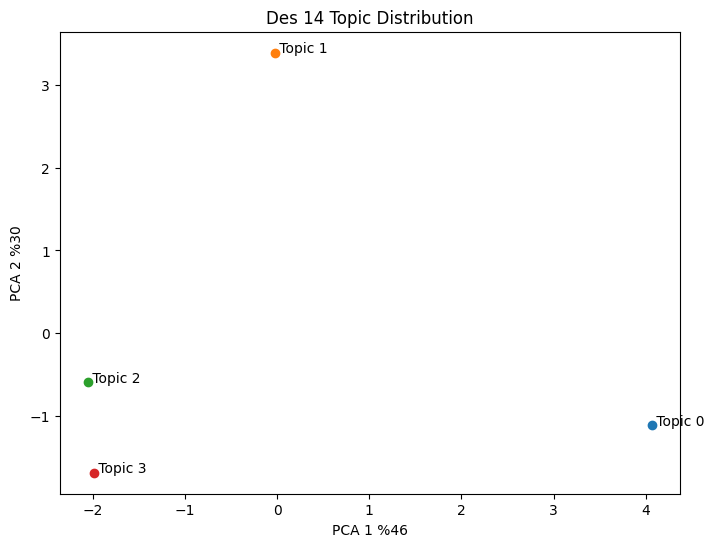

Every topic with its most relevant words.


Topic 0 = izquierda, ideologia, ser, politico

Topic 1 = peronista, politico, partido, suiza

Topic 2 = izquierda, nacionalista, republicano, latam

Topic 3 = centro, liberal, socialista, derecha



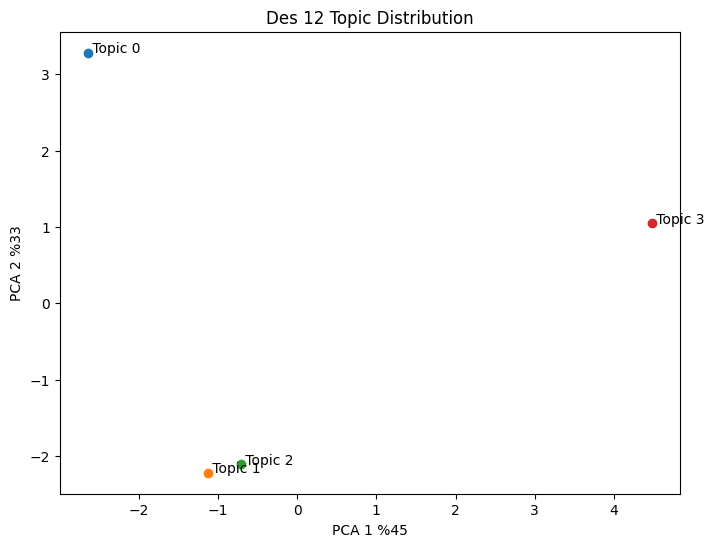

Every topic with its most relevant words.


Topic 0 = ser, tener, transporte, opinion

Topic 1 = acuerdo, empresa, controlar, ser

Topic 2 = ser, poder, tener, empresa

Topic 3 = ser, deber, subsidio, necesitar



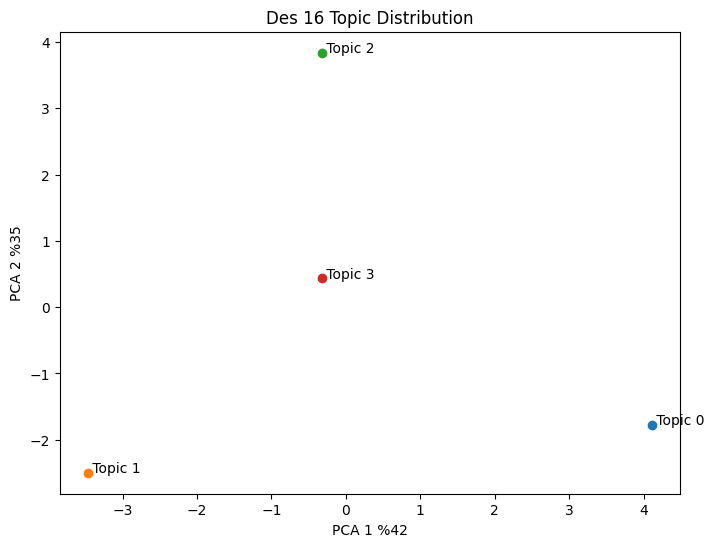

Every topic with its most relevant words.


Topic 0 = mas, nuevo, clase, tiempo

Topic 1 = mas, taller, excursiones, horario

Topic 2 = curso, diseno, mas, extracurricular

Topic 3 = horario, menos, mejor, mas



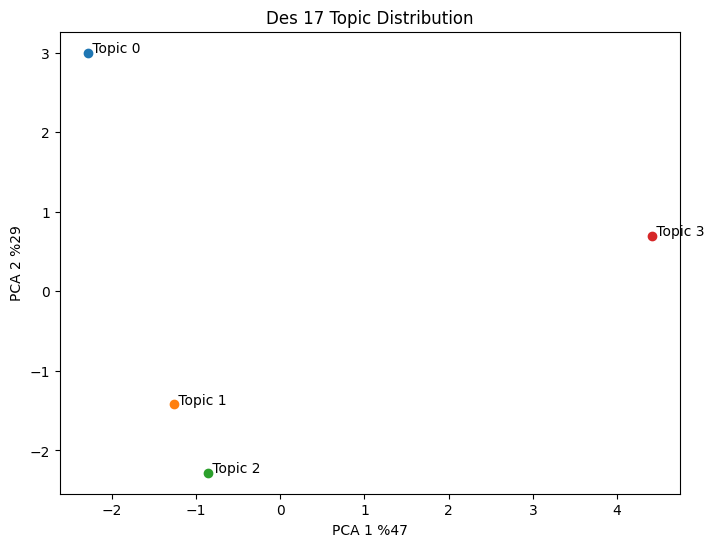

Every topic with its most relevant words.


Topic 0 = horario, carga, ser, menos

Topic 1 = bache, horario, almorzar, haber

Topic 2 = materia, diseno, mobiliario, adaptable

Topic 3 = tiempo, tener, clase, materia



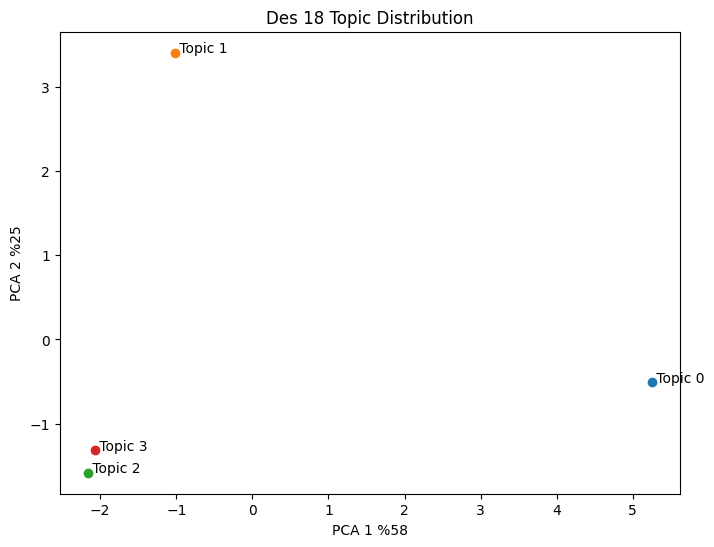

In [17]:
for des, textos in df_desafio.items():
    
    # Define data
    documents = [' '.join(t) for t in textos]

    num_top_words = 4

    visualize_topics(model, documents, num_top_words, n_components=4, des=des)

## 3. BERTopic 

- [Documentation](https://maartengr.github.io/BERTopic/api/bertopic.html)
- [Friendly Documentation](https://maartengr.github.io/BERTopic/index.html)
- [Use Case Example](https://www.pinecone.io/learn/bertopic/)

In [18]:
# dict with desafio and its preprocesed texts
df_desafio = {}
for des in df.desafio.unique():
    value = df[df['desafio']==des].texto.tolist()
    value = preprocess(value, lemma=False)
    value = [' '.join(d) for d in value]
    df_desafio[des] = value

In [19]:
from IPython.display import display, Markdown

def bertopic_plots(model, documents, des):
    
    """
    This function plots every relevant BERTopic plot. 
    
    Input:
    a. model: BERTopic
    b. documents: preprocessed
    c. des: name of desafio
    
    Output: none
    
    """
    
    
    topics, probs = model.fit_transform(documents)
    
    
    # Define the text to display
    text = f'<div style="text-align:center;"><span style="font-size:48px;color:blue;">Desafío {des}</span></div>'

    # Get the unique Topics and their frequencies
    unique_elements, counts = np.unique(topics, return_counts=True)
    
    plt.bar(unique_elements, counts)
    
    # Add axis labels and a title
    plt.xlabel('Topic')
    plt.ylabel('Frequency (N of documents)')
    plt.xticks(unique_elements)
    plt.title(f'Frequency of each Topic\nDes {des}')

    # Visualize topics
    fig_vt = model.visualize_topics()

    # Importance of each word
    fig_w = model.visualize_barchart(top_n_topics=len(model.get_topics()))
    
    # Vistualize documents
    fig_vd = model.visualize_documents(documents, hide_annotations=True)
    
    # Heatmap topics
    fig_hm = model.visualize_heatmap()

    #Show images
    print('\n\n')
    display(Markdown(text))
    
    plt.show()
    fig_vt.show()
    fig_w.show()
    fig_vd.show()
    fig_hm.show()
    
    # Most representative documents
    original_texts = df['texto'].values.tolist()
    prepro_texts = df['prepro_text'].values.tolist()
    prepro_texts = [' '.join(d) for d in prepro_texts]
    
    for key, value in model.get_representative_docs().items():
        print('\n'*4),print(f'TOPIC {key} most representative documents:\n')
        for i, doc in enumerate(value):
            indice = documents.index(doc)
            print(f'{i+1}.\n {original_texts[indice]}\n\n')

In [21]:
from bertopic import BERTopic
from sklearn.feature_extraction.text import CountVectorizer
from sentence_transformers import SentenceTransformer
from umap import UMAP
from hdbscan import HDBSCAN

def bert_model_create():
    embedding_model = SentenceTransformer('bert-base-nli-mean-tokens') # embedings pre entrenado en español
    umap_model = UMAP(n_neighbors=3, n_components=3)
    hdbscan_model = HDBSCAN(gen_min_span_tree=True, prediction_data=True)

    # Bag of words
    vectorizer_model = CountVectorizer(ngram_range=(1, 3))
    
    model = BERTopic(
        umap_model = umap_model,
        hdbscan_model = hdbscan_model,
        embedding_model = embedding_model,
        vectorizer_model = vectorizer_model,
        top_n_words=5,
        language='spanish',
        calculate_probabilities=True,
        verbose=True,
        nr_topics="auto"
        )
    
    return model

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

2022-12-19 19:18:36,425 - BERTopic - Transformed documents to Embeddings
2022-12-19 19:18:41,115 - BERTopic - Reduced dimensionality
2022-12-19 19:18:41,124 - BERTopic - Clustered reduced embeddings
2022-12-19 19:18:42,021 - BERTopic - Reduced number of topics from 5 to 5


<div style="text-align:center;"><span style="font-size:48px;color:blue;">Desafío 12</span></div>

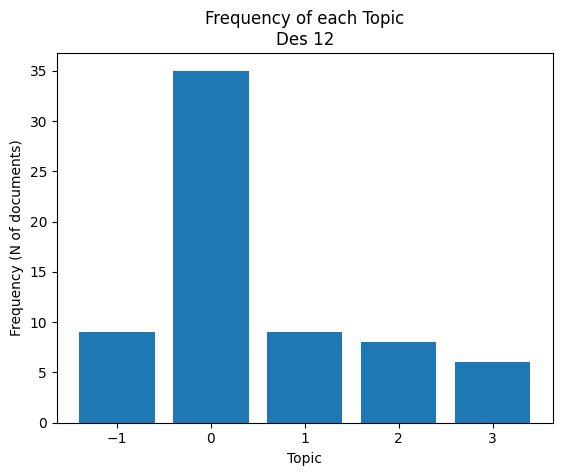






TOPIC 3 most representative documents:

1.
 False


2.
 René Favaloro. Por su compromiso, profesionalismo y capacidad de generar cosas nuevas de manera creativa.


3.
 Totalmente en contra. La finalidad de cualquier empresa es ser rentable. Partiendo de esa premisa el coste del pasaje tiene que dar lugar a cubrir sus gastos y tener un margen. Se torna complicado cuando hablamos de empresas que prestan un servicio publico, pero si no podemos afrontar el coste real de un pasaje sin subsidios con un sueldo basico, eso nos dice que algo anda muy mal y las empresas no son el problema.







TOPIC 2 most representative documents:

1.
 Desconozco el trasfondo. La regulación, de todos modos, es relevante.


2.
 nan


3.
 Loscplanescsociales deben ser gestionados  distribuídos de otra manera. Tienen que tener dinamismo . Estudiar de que manera se rota hacia puestos de trabajos . Pivotear en los planes y fuenes de trabajo Planificar los planes como medida a mefiano plazo 







TOPIC 0 mo

In [22]:
key = '12'

documents = df_desafio[key]

continue_loop = True
while continue_loop:
    try:
        model = bert_model_create()
        bertopic_plots(model, documents, key)
        continue_loop = False
    except:
        print('Failed. Trying again.')

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

2022-12-19 19:19:03,255 - BERTopic - Transformed documents to Embeddings
2022-12-19 19:19:04,859 - BERTopic - Reduced dimensionality
2022-12-19 19:19:04,869 - BERTopic - Clustered reduced embeddings
2022-12-19 19:19:05,679 - BERTopic - Reduced number of topics from 5 to 5


<div style="text-align:center;"><span style="font-size:48px;color:blue;">Desafío 13</span></div>

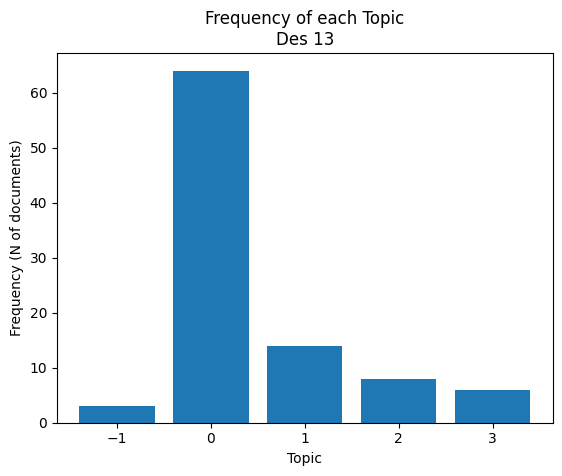






TOPIC 2 most representative documents:

1.
 False


2.
 Pienso que el Estado debe tener un rol activo en la resolución de problemas, lo cual incluye por supuesto garantizar el derecho a la alimentación y la salud entre otras cuestiones. Los planes sociales deben ir acompañados de proyectos de inclusión laboral.


3.
 Gral Jose de San Martin, debemos volver a las bases, al amor por nuestra patria. A las epopeyas que nos hicieron grandes.







TOPIC 3 most representative documents:

1.
 Izquierda en lo que respecta a mi desprecio al capitalismo.Derecha porque soy antidelincuencia.


2.
 No tengo una posición muy formada, pero me identifico con el liberalismo. Completamente liberal en lo social, y relativamente en lo económico. 


3.
 Los subsidios al transporte público es una lógica que se arrastra desde las privatizaciones de la década de 1990, debería revisarse porque lo único que genera es llenar los bolsillos de unos pocos empresarios.







TOPIC 0 most representative docume

In [23]:
key = '13'

documents = df_desafio[key]

continue_loop = True
while continue_loop:
    try:
        model = bert_model_create()
        bertopic_plots(model, documents, key)
        continue_loop = False
    except:
        print('Failed. Trying again.')

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

2022-12-19 19:19:22,594 - BERTopic - Transformed documents to Embeddings
2022-12-19 19:19:24,190 - BERTopic - Reduced dimensionality
2022-12-19 19:19:24,198 - BERTopic - Clustered reduced embeddings
2022-12-19 19:19:25,031 - BERTopic - Reduced number of topics from 4 to 4
C:\Users\Felipe\miniconda3\lib\site-packages\scipy\sparse\linalg\_eigen\arpack\arpack.py:1592: RuntimeWarning:

k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.



Failed. Trying again.


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

2022-12-19 19:19:30,001 - BERTopic - Transformed documents to Embeddings
2022-12-19 19:19:31,342 - BERTopic - Reduced dimensionality
2022-12-19 19:19:31,350 - BERTopic - Clustered reduced embeddings
2022-12-19 19:19:31,988 - BERTopic - Reduced number of topics from 4 to 4
C:\Users\Felipe\miniconda3\lib\site-packages\scipy\sparse\linalg\_eigen\arpack\arpack.py:1592: RuntimeWarning:

k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.



Failed. Trying again.


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

2022-12-19 19:19:36,947 - BERTopic - Transformed documents to Embeddings
2022-12-19 19:19:38,278 - BERTopic - Reduced dimensionality
2022-12-19 19:19:38,286 - BERTopic - Clustered reduced embeddings
2022-12-19 19:19:38,816 - BERTopic - Reduced number of topics from 4 to 4
C:\Users\Felipe\miniconda3\lib\site-packages\scipy\sparse\linalg\_eigen\arpack\arpack.py:1592: RuntimeWarning:

k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.



Failed. Trying again.


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

2022-12-19 19:19:43,735 - BERTopic - Transformed documents to Embeddings
2022-12-19 19:19:45,346 - BERTopic - Reduced dimensionality
2022-12-19 19:19:45,354 - BERTopic - Clustered reduced embeddings
2022-12-19 19:19:45,894 - BERTopic - Reduced number of topics from 4 to 4
C:\Users\Felipe\miniconda3\lib\site-packages\scipy\sparse\linalg\_eigen\arpack\arpack.py:1592: RuntimeWarning:

k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.



Failed. Trying again.


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

2022-12-19 19:19:50,838 - BERTopic - Transformed documents to Embeddings
2022-12-19 19:19:52,176 - BERTopic - Reduced dimensionality
2022-12-19 19:19:52,185 - BERTopic - Clustered reduced embeddings
2022-12-19 19:19:52,727 - BERTopic - Reduced number of topics from 4 to 4
C:\Users\Felipe\miniconda3\lib\site-packages\scipy\sparse\linalg\_eigen\arpack\arpack.py:1592: RuntimeWarning:

k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.



Failed. Trying again.


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

2022-12-19 19:19:57,725 - BERTopic - Transformed documents to Embeddings
2022-12-19 19:19:59,041 - BERTopic - Reduced dimensionality
2022-12-19 19:19:59,049 - BERTopic - Clustered reduced embeddings
2022-12-19 19:19:59,575 - BERTopic - Reduced number of topics from 4 to 4
C:\Users\Felipe\miniconda3\lib\site-packages\scipy\sparse\linalg\_eigen\arpack\arpack.py:1592: RuntimeWarning:

k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.



Failed. Trying again.


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

2022-12-19 19:20:04,403 - BERTopic - Transformed documents to Embeddings
2022-12-19 19:20:06,019 - BERTopic - Reduced dimensionality
2022-12-19 19:20:06,027 - BERTopic - Clustered reduced embeddings
2022-12-19 19:20:06,559 - BERTopic - Reduced number of topics from 4 to 4
C:\Users\Felipe\miniconda3\lib\site-packages\scipy\sparse\linalg\_eigen\arpack\arpack.py:1592: RuntimeWarning:

k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.



Failed. Trying again.


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

2022-12-19 19:20:11,606 - BERTopic - Transformed documents to Embeddings
2022-12-19 19:20:12,949 - BERTopic - Reduced dimensionality
2022-12-19 19:20:12,957 - BERTopic - Clustered reduced embeddings
2022-12-19 19:20:13,533 - BERTopic - Reduced number of topics from 4 to 4
C:\Users\Felipe\miniconda3\lib\site-packages\scipy\sparse\linalg\_eigen\arpack\arpack.py:1592: RuntimeWarning:

k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.



Failed. Trying again.


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

2022-12-19 19:20:18,500 - BERTopic - Transformed documents to Embeddings
2022-12-19 19:20:19,829 - BERTopic - Reduced dimensionality
2022-12-19 19:20:19,837 - BERTopic - Clustered reduced embeddings
2022-12-19 19:20:20,476 - BERTopic - Reduced number of topics from 4 to 4
C:\Users\Felipe\miniconda3\lib\site-packages\scipy\sparse\linalg\_eigen\arpack\arpack.py:1592: RuntimeWarning:

k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.



Failed. Trying again.


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

2022-12-19 19:20:25,494 - BERTopic - Transformed documents to Embeddings
2022-12-19 19:20:27,108 - BERTopic - Reduced dimensionality
2022-12-19 19:20:27,115 - BERTopic - Clustered reduced embeddings
2022-12-19 19:20:27,729 - BERTopic - Reduced number of topics from 4 to 4
C:\Users\Felipe\miniconda3\lib\site-packages\scipy\sparse\linalg\_eigen\arpack\arpack.py:1592: RuntimeWarning:

k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.



Failed. Trying again.


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

2022-12-19 19:20:32,703 - BERTopic - Transformed documents to Embeddings
2022-12-19 19:20:34,023 - BERTopic - Reduced dimensionality
2022-12-19 19:20:34,031 - BERTopic - Clustered reduced embeddings
2022-12-19 19:20:34,811 - BERTopic - Reduced number of topics from 4 to 4
C:\Users\Felipe\miniconda3\lib\site-packages\scipy\sparse\linalg\_eigen\arpack\arpack.py:1592: RuntimeWarning:

k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.



Failed. Trying again.


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

2022-12-19 19:20:39,793 - BERTopic - Transformed documents to Embeddings
2022-12-19 19:20:41,147 - BERTopic - Reduced dimensionality
2022-12-19 19:20:41,155 - BERTopic - Clustered reduced embeddings
2022-12-19 19:20:41,726 - BERTopic - Reduced number of topics from 4 to 4
C:\Users\Felipe\miniconda3\lib\site-packages\scipy\sparse\linalg\_eigen\arpack\arpack.py:1592: RuntimeWarning:

k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.



Failed. Trying again.


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

2022-12-19 19:20:46,723 - BERTopic - Transformed documents to Embeddings
2022-12-19 19:20:48,328 - BERTopic - Reduced dimensionality
2022-12-19 19:20:48,336 - BERTopic - Clustered reduced embeddings
2022-12-19 19:20:48,887 - BERTopic - Reduced number of topics from 4 to 4
C:\Users\Felipe\miniconda3\lib\site-packages\scipy\sparse\linalg\_eigen\arpack\arpack.py:1592: RuntimeWarning:

k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.



Failed. Trying again.


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

2022-12-19 19:20:53,903 - BERTopic - Transformed documents to Embeddings
2022-12-19 19:20:55,227 - BERTopic - Reduced dimensionality
2022-12-19 19:20:55,235 - BERTopic - Clustered reduced embeddings
2022-12-19 19:20:55,837 - BERTopic - Reduced number of topics from 4 to 4
C:\Users\Felipe\miniconda3\lib\site-packages\scipy\sparse\linalg\_eigen\arpack\arpack.py:1592: RuntimeWarning:

k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.



Failed. Trying again.


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

2022-12-19 19:21:00,882 - BERTopic - Transformed documents to Embeddings
2022-12-19 19:21:02,225 - BERTopic - Reduced dimensionality
2022-12-19 19:21:02,233 - BERTopic - Clustered reduced embeddings
2022-12-19 19:21:02,791 - BERTopic - Reduced number of topics from 4 to 4
C:\Users\Felipe\miniconda3\lib\site-packages\scipy\sparse\linalg\_eigen\arpack\arpack.py:1592: RuntimeWarning:

k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.



Failed. Trying again.


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

2022-12-19 19:21:07,811 - BERTopic - Transformed documents to Embeddings
2022-12-19 19:21:09,429 - BERTopic - Reduced dimensionality
2022-12-19 19:21:09,437 - BERTopic - Clustered reduced embeddings
2022-12-19 19:21:10,271 - BERTopic - Reduced number of topics from 4 to 4
C:\Users\Felipe\miniconda3\lib\site-packages\scipy\sparse\linalg\_eigen\arpack\arpack.py:1592: RuntimeWarning:

k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.



Failed. Trying again.


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

2022-12-19 19:21:15,268 - BERTopic - Transformed documents to Embeddings
2022-12-19 19:21:16,624 - BERTopic - Reduced dimensionality
2022-12-19 19:21:16,632 - BERTopic - Clustered reduced embeddings
2022-12-19 19:21:16,972 - BERTopic - Reduced number of topics from 3 to 3


Failed. Trying again.


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

2022-12-19 19:21:21,996 - BERTopic - Transformed documents to Embeddings
2022-12-19 19:21:23,323 - BERTopic - Reduced dimensionality
2022-12-19 19:21:23,330 - BERTopic - Clustered reduced embeddings
2022-12-19 19:21:23,864 - BERTopic - Reduced number of topics from 4 to 4
C:\Users\Felipe\miniconda3\lib\site-packages\scipy\sparse\linalg\_eigen\arpack\arpack.py:1592: RuntimeWarning:

k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.



Failed. Trying again.


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

2022-12-19 19:21:28,854 - BERTopic - Transformed documents to Embeddings
2022-12-19 19:21:30,176 - BERTopic - Reduced dimensionality
2022-12-19 19:21:30,184 - BERTopic - Clustered reduced embeddings
2022-12-19 19:21:30,726 - BERTopic - Reduced number of topics from 4 to 4
C:\Users\Felipe\miniconda3\lib\site-packages\scipy\sparse\linalg\_eigen\arpack\arpack.py:1592: RuntimeWarning:

k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.



Failed. Trying again.


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

2022-12-19 19:21:35,760 - BERTopic - Transformed documents to Embeddings
2022-12-19 19:21:37,377 - BERTopic - Reduced dimensionality
2022-12-19 19:21:37,385 - BERTopic - Clustered reduced embeddings
2022-12-19 19:21:37,918 - BERTopic - Reduced number of topics from 4 to 4
C:\Users\Felipe\miniconda3\lib\site-packages\scipy\sparse\linalg\_eigen\arpack\arpack.py:1592: RuntimeWarning:

k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.



Failed. Trying again.


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

2022-12-19 19:21:42,851 - BERTopic - Transformed documents to Embeddings
2022-12-19 19:21:44,185 - BERTopic - Reduced dimensionality
2022-12-19 19:21:44,193 - BERTopic - Clustered reduced embeddings
2022-12-19 19:21:44,630 - BERTopic - Reduced number of topics from 3 to 3


Failed. Trying again.


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

2022-12-19 19:21:49,564 - BERTopic - Transformed documents to Embeddings
2022-12-19 19:21:50,894 - BERTopic - Reduced dimensionality
2022-12-19 19:21:50,902 - BERTopic - Clustered reduced embeddings
2022-12-19 19:21:51,443 - BERTopic - Reduced number of topics from 4 to 4
C:\Users\Felipe\miniconda3\lib\site-packages\scipy\sparse\linalg\_eigen\arpack\arpack.py:1592: RuntimeWarning:

k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.



Failed. Trying again.


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

2022-12-19 19:21:56,426 - BERTopic - Transformed documents to Embeddings
2022-12-19 19:21:58,052 - BERTopic - Reduced dimensionality
2022-12-19 19:21:58,060 - BERTopic - Clustered reduced embeddings
2022-12-19 19:21:58,854 - BERTopic - Reduced number of topics from 4 to 4
C:\Users\Felipe\miniconda3\lib\site-packages\scipy\sparse\linalg\_eigen\arpack\arpack.py:1592: RuntimeWarning:

k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.



Failed. Trying again.


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

2022-12-19 19:22:03,869 - BERTopic - Transformed documents to Embeddings
2022-12-19 19:22:05,216 - BERTopic - Reduced dimensionality
2022-12-19 19:22:05,224 - BERTopic - Clustered reduced embeddings
2022-12-19 19:22:05,768 - BERTopic - Reduced number of topics from 4 to 4
C:\Users\Felipe\miniconda3\lib\site-packages\scipy\sparse\linalg\_eigen\arpack\arpack.py:1592: RuntimeWarning:

k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.



Failed. Trying again.


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

2022-12-19 19:22:10,726 - BERTopic - Transformed documents to Embeddings
2022-12-19 19:22:12,080 - BERTopic - Reduced dimensionality
2022-12-19 19:22:12,088 - BERTopic - Clustered reduced embeddings
2022-12-19 19:22:12,519 - BERTopic - Reduced number of topics from 4 to 4
C:\Users\Felipe\miniconda3\lib\site-packages\scipy\sparse\linalg\_eigen\arpack\arpack.py:1592: RuntimeWarning:

k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.



Failed. Trying again.


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

2022-12-19 19:22:17,578 - BERTopic - Transformed documents to Embeddings
2022-12-19 19:22:19,237 - BERTopic - Reduced dimensionality
2022-12-19 19:22:19,245 - BERTopic - Clustered reduced embeddings
2022-12-19 19:22:19,819 - BERTopic - Reduced number of topics from 4 to 4
C:\Users\Felipe\miniconda3\lib\site-packages\scipy\sparse\linalg\_eigen\arpack\arpack.py:1592: RuntimeWarning:

k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.



Failed. Trying again.


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

2022-12-19 19:22:24,918 - BERTopic - Transformed documents to Embeddings
2022-12-19 19:22:26,235 - BERTopic - Reduced dimensionality
2022-12-19 19:22:26,243 - BERTopic - Clustered reduced embeddings
2022-12-19 19:22:26,906 - BERTopic - Reduced number of topics from 4 to 4
C:\Users\Felipe\miniconda3\lib\site-packages\scipy\sparse\linalg\_eigen\arpack\arpack.py:1592: RuntimeWarning:

k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.



Failed. Trying again.


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

2022-12-19 19:22:31,894 - BERTopic - Transformed documents to Embeddings
2022-12-19 19:22:33,223 - BERTopic - Reduced dimensionality
2022-12-19 19:22:33,231 - BERTopic - Clustered reduced embeddings
2022-12-19 19:22:33,827 - BERTopic - Reduced number of topics from 4 to 4
C:\Users\Felipe\miniconda3\lib\site-packages\scipy\sparse\linalg\_eigen\arpack\arpack.py:1592: RuntimeWarning:

k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.



Failed. Trying again.


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

2022-12-19 19:22:38,847 - BERTopic - Transformed documents to Embeddings
2022-12-19 19:22:40,504 - BERTopic - Reduced dimensionality
2022-12-19 19:22:40,512 - BERTopic - Clustered reduced embeddings
2022-12-19 19:22:41,185 - BERTopic - Reduced number of topics from 4 to 4
C:\Users\Felipe\miniconda3\lib\site-packages\scipy\sparse\linalg\_eigen\arpack\arpack.py:1592: RuntimeWarning:

k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.



Failed. Trying again.


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

2022-12-19 19:22:46,170 - BERTopic - Transformed documents to Embeddings
2022-12-19 19:22:47,504 - BERTopic - Reduced dimensionality
2022-12-19 19:22:47,512 - BERTopic - Clustered reduced embeddings
2022-12-19 19:22:48,126 - BERTopic - Reduced number of topics from 4 to 4
C:\Users\Felipe\miniconda3\lib\site-packages\scipy\sparse\linalg\_eigen\arpack\arpack.py:1592: RuntimeWarning:

k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.



Failed. Trying again.


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

2022-12-19 19:22:53,155 - BERTopic - Transformed documents to Embeddings
2022-12-19 19:22:54,476 - BERTopic - Reduced dimensionality
2022-12-19 19:22:54,484 - BERTopic - Clustered reduced embeddings
2022-12-19 19:22:55,101 - BERTopic - Reduced number of topics from 4 to 4
C:\Users\Felipe\miniconda3\lib\site-packages\scipy\sparse\linalg\_eigen\arpack\arpack.py:1592: RuntimeWarning:

k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.



Failed. Trying again.


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

2022-12-19 19:23:00,183 - BERTopic - Transformed documents to Embeddings
2022-12-19 19:23:01,553 - BERTopic - Reduced dimensionality
2022-12-19 19:23:01,561 - BERTopic - Clustered reduced embeddings
2022-12-19 19:23:02,265 - BERTopic - Reduced number of topics from 4 to 4
C:\Users\Felipe\miniconda3\lib\site-packages\scipy\sparse\linalg\_eigen\arpack\arpack.py:1592: RuntimeWarning:

k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.



Failed. Trying again.


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

2022-12-19 19:23:07,248 - BERTopic - Transformed documents to Embeddings
2022-12-19 19:23:08,894 - BERTopic - Reduced dimensionality
2022-12-19 19:23:08,902 - BERTopic - Clustered reduced embeddings
2022-12-19 19:23:09,577 - BERTopic - Reduced number of topics from 4 to 4
C:\Users\Felipe\miniconda3\lib\site-packages\scipy\sparse\linalg\_eigen\arpack\arpack.py:1592: RuntimeWarning:

k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.



Failed. Trying again.


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

2022-12-19 19:23:14,557 - BERTopic - Transformed documents to Embeddings
2022-12-19 19:23:15,898 - BERTopic - Reduced dimensionality
2022-12-19 19:23:15,906 - BERTopic - Clustered reduced embeddings
2022-12-19 19:23:16,577 - BERTopic - Reduced number of topics from 4 to 4
C:\Users\Felipe\miniconda3\lib\site-packages\scipy\sparse\linalg\_eigen\arpack\arpack.py:1592: RuntimeWarning:

k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.



Failed. Trying again.


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

2022-12-19 19:23:21,476 - BERTopic - Transformed documents to Embeddings
2022-12-19 19:23:22,794 - BERTopic - Reduced dimensionality
2022-12-19 19:23:22,802 - BERTopic - Clustered reduced embeddings
2022-12-19 19:23:23,253 - BERTopic - Reduced number of topics from 4 to 4
C:\Users\Felipe\miniconda3\lib\site-packages\scipy\sparse\linalg\_eigen\arpack\arpack.py:1592: RuntimeWarning:

k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.



Failed. Trying again.


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

2022-12-19 19:23:28,295 - BERTopic - Transformed documents to Embeddings
2022-12-19 19:23:29,980 - BERTopic - Reduced dimensionality
2022-12-19 19:23:29,988 - BERTopic - Clustered reduced embeddings
2022-12-19 19:23:30,588 - BERTopic - Reduced number of topics from 4 to 4
C:\Users\Felipe\miniconda3\lib\site-packages\scipy\sparse\linalg\_eigen\arpack\arpack.py:1592: RuntimeWarning:

k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.



Failed. Trying again.


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

2022-12-19 19:23:35,635 - BERTopic - Transformed documents to Embeddings
2022-12-19 19:23:36,968 - BERTopic - Reduced dimensionality
2022-12-19 19:23:36,976 - BERTopic - Clustered reduced embeddings
2022-12-19 19:23:37,633 - BERTopic - Reduced number of topics from 4 to 4
C:\Users\Felipe\miniconda3\lib\site-packages\scipy\sparse\linalg\_eigen\arpack\arpack.py:1592: RuntimeWarning:

k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.



Failed. Trying again.


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

2022-12-19 19:23:42,552 - BERTopic - Transformed documents to Embeddings
2022-12-19 19:23:43,932 - BERTopic - Reduced dimensionality
2022-12-19 19:23:43,940 - BERTopic - Clustered reduced embeddings
2022-12-19 19:23:44,516 - BERTopic - Reduced number of topics from 4 to 4
C:\Users\Felipe\miniconda3\lib\site-packages\scipy\sparse\linalg\_eigen\arpack\arpack.py:1592: RuntimeWarning:

k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.



Failed. Trying again.


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

2022-12-19 19:23:49,521 - BERTopic - Transformed documents to Embeddings
2022-12-19 19:23:51,208 - BERTopic - Reduced dimensionality
2022-12-19 19:23:51,216 - BERTopic - Clustered reduced embeddings
2022-12-19 19:23:51,779 - BERTopic - Reduced number of topics from 4 to 4
C:\Users\Felipe\miniconda3\lib\site-packages\scipy\sparse\linalg\_eigen\arpack\arpack.py:1592: RuntimeWarning:

k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.



Failed. Trying again.


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

2022-12-19 19:23:56,706 - BERTopic - Transformed documents to Embeddings
2022-12-19 19:23:58,051 - BERTopic - Reduced dimensionality
2022-12-19 19:23:58,059 - BERTopic - Clustered reduced embeddings
2022-12-19 19:23:58,657 - BERTopic - Reduced number of topics from 4 to 4
C:\Users\Felipe\miniconda3\lib\site-packages\scipy\sparse\linalg\_eigen\arpack\arpack.py:1592: RuntimeWarning:

k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.



Failed. Trying again.


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

2022-12-19 19:24:03,645 - BERTopic - Transformed documents to Embeddings
2022-12-19 19:24:04,998 - BERTopic - Reduced dimensionality
2022-12-19 19:24:05,006 - BERTopic - Clustered reduced embeddings
2022-12-19 19:24:05,883 - BERTopic - Reduced number of topics from 4 to 4
C:\Users\Felipe\miniconda3\lib\site-packages\scipy\sparse\linalg\_eigen\arpack\arpack.py:1592: RuntimeWarning:

k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.



Failed. Trying again.


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

2022-12-19 19:24:10,871 - BERTopic - Transformed documents to Embeddings
2022-12-19 19:24:12,200 - BERTopic - Reduced dimensionality
2022-12-19 19:24:12,207 - BERTopic - Clustered reduced embeddings
2022-12-19 19:24:12,797 - BERTopic - Reduced number of topics from 4 to 4
C:\Users\Felipe\miniconda3\lib\site-packages\scipy\sparse\linalg\_eigen\arpack\arpack.py:1592: RuntimeWarning:

k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.



Failed. Trying again.


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

2022-12-19 19:24:17,743 - BERTopic - Transformed documents to Embeddings
2022-12-19 19:24:19,406 - BERTopic - Reduced dimensionality
2022-12-19 19:24:19,414 - BERTopic - Clustered reduced embeddings
2022-12-19 19:24:19,846 - BERTopic - Reduced number of topics from 4 to 4
C:\Users\Felipe\miniconda3\lib\site-packages\scipy\sparse\linalg\_eigen\arpack\arpack.py:1592: RuntimeWarning:

k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.



Failed. Trying again.


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

2022-12-19 19:24:24,900 - BERTopic - Transformed documents to Embeddings
2022-12-19 19:24:26,244 - BERTopic - Reduced dimensionality
2022-12-19 19:24:26,252 - BERTopic - Clustered reduced embeddings
2022-12-19 19:24:26,883 - BERTopic - Reduced number of topics from 4 to 4
C:\Users\Felipe\miniconda3\lib\site-packages\scipy\sparse\linalg\_eigen\arpack\arpack.py:1592: RuntimeWarning:

k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.



Failed. Trying again.


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

2022-12-19 19:24:31,868 - BERTopic - Transformed documents to Embeddings
2022-12-19 19:24:33,201 - BERTopic - Reduced dimensionality
2022-12-19 19:24:33,209 - BERTopic - Clustered reduced embeddings
2022-12-19 19:24:34,105 - BERTopic - Reduced number of topics from 4 to 4
C:\Users\Felipe\miniconda3\lib\site-packages\scipy\sparse\linalg\_eigen\arpack\arpack.py:1592: RuntimeWarning:

k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.



Failed. Trying again.


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

2022-12-19 19:24:39,113 - BERTopic - Transformed documents to Embeddings
2022-12-19 19:24:40,809 - BERTopic - Reduced dimensionality
2022-12-19 19:24:40,817 - BERTopic - Clustered reduced embeddings
2022-12-19 19:24:41,342 - BERTopic - Reduced number of topics from 4 to 4
C:\Users\Felipe\miniconda3\lib\site-packages\scipy\sparse\linalg\_eigen\arpack\arpack.py:1592: RuntimeWarning:

k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.



Failed. Trying again.


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

2022-12-19 19:24:46,265 - BERTopic - Transformed documents to Embeddings
2022-12-19 19:24:47,598 - BERTopic - Reduced dimensionality
2022-12-19 19:24:47,606 - BERTopic - Clustered reduced embeddings
2022-12-19 19:24:48,038 - BERTopic - Reduced number of topics from 4 to 4
C:\Users\Felipe\miniconda3\lib\site-packages\scipy\sparse\linalg\_eigen\arpack\arpack.py:1592: RuntimeWarning:

k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.



Failed. Trying again.


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

2022-12-19 19:24:53,101 - BERTopic - Transformed documents to Embeddings
2022-12-19 19:24:54,453 - BERTopic - Reduced dimensionality
2022-12-19 19:24:54,461 - BERTopic - Clustered reduced embeddings
2022-12-19 19:24:55,001 - BERTopic - Reduced number of topics from 4 to 4
C:\Users\Felipe\miniconda3\lib\site-packages\scipy\sparse\linalg\_eigen\arpack\arpack.py:1592: RuntimeWarning:

k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.



Failed. Trying again.


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

2022-12-19 19:25:00,105 - BERTopic - Transformed documents to Embeddings
2022-12-19 19:25:01,795 - BERTopic - Reduced dimensionality
2022-12-19 19:25:01,803 - BERTopic - Clustered reduced embeddings
2022-12-19 19:25:02,347 - BERTopic - Reduced number of topics from 4 to 4
C:\Users\Felipe\miniconda3\lib\site-packages\scipy\sparse\linalg\_eigen\arpack\arpack.py:1592: RuntimeWarning:

k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.



Failed. Trying again.


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

2022-12-19 19:25:07,398 - BERTopic - Transformed documents to Embeddings
2022-12-19 19:25:08,737 - BERTopic - Reduced dimensionality
2022-12-19 19:25:08,745 - BERTopic - Clustered reduced embeddings
2022-12-19 19:25:09,400 - BERTopic - Reduced number of topics from 4 to 4
C:\Users\Felipe\miniconda3\lib\site-packages\scipy\sparse\linalg\_eigen\arpack\arpack.py:1592: RuntimeWarning:

k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.



Failed. Trying again.


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

2022-12-19 19:25:14,352 - BERTopic - Transformed documents to Embeddings
2022-12-19 19:25:15,680 - BERTopic - Reduced dimensionality
2022-12-19 19:25:15,688 - BERTopic - Clustered reduced embeddings
2022-12-19 19:25:16,116 - BERTopic - Reduced number of topics from 3 to 3


Failed. Trying again.


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

2022-12-19 19:25:21,071 - BERTopic - Transformed documents to Embeddings
2022-12-19 19:25:22,398 - BERTopic - Reduced dimensionality
2022-12-19 19:25:22,406 - BERTopic - Clustered reduced embeddings
2022-12-19 19:25:23,014 - BERTopic - Reduced number of topics from 4 to 4
C:\Users\Felipe\miniconda3\lib\site-packages\scipy\sparse\linalg\_eigen\arpack\arpack.py:1592: RuntimeWarning:

k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.



Failed. Trying again.


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

2022-12-19 19:25:28,010 - BERTopic - Transformed documents to Embeddings
2022-12-19 19:25:29,701 - BERTopic - Reduced dimensionality
2022-12-19 19:25:29,709 - BERTopic - Clustered reduced embeddings
2022-12-19 19:25:30,320 - BERTopic - Reduced number of topics from 4 to 4
C:\Users\Felipe\miniconda3\lib\site-packages\scipy\sparse\linalg\_eigen\arpack\arpack.py:1592: RuntimeWarning:

k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.



Failed. Trying again.


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

2022-12-19 19:25:35,286 - BERTopic - Transformed documents to Embeddings
2022-12-19 19:25:36,621 - BERTopic - Reduced dimensionality
2022-12-19 19:25:36,628 - BERTopic - Clustered reduced embeddings
2022-12-19 19:25:37,113 - BERTopic - Reduced number of topics from 3 to 3


Failed. Trying again.


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

2022-12-19 19:25:42,120 - BERTopic - Transformed documents to Embeddings
2022-12-19 19:25:43,470 - BERTopic - Reduced dimensionality
2022-12-19 19:25:43,478 - BERTopic - Clustered reduced embeddings
2022-12-19 19:25:44,323 - BERTopic - Reduced number of topics from 4 to 4
C:\Users\Felipe\miniconda3\lib\site-packages\scipy\sparse\linalg\_eigen\arpack\arpack.py:1592: RuntimeWarning:

k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.



Failed. Trying again.


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

2022-12-19 19:25:49,375 - BERTopic - Transformed documents to Embeddings
2022-12-19 19:25:51,072 - BERTopic - Reduced dimensionality
2022-12-19 19:25:51,080 - BERTopic - Clustered reduced embeddings
2022-12-19 19:25:51,706 - BERTopic - Reduced number of topics from 4 to 4
C:\Users\Felipe\miniconda3\lib\site-packages\scipy\sparse\linalg\_eigen\arpack\arpack.py:1592: RuntimeWarning:

k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.



Failed. Trying again.


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

2022-12-19 19:25:56,628 - BERTopic - Transformed documents to Embeddings
2022-12-19 19:25:57,972 - BERTopic - Reduced dimensionality
2022-12-19 19:25:57,979 - BERTopic - Clustered reduced embeddings
2022-12-19 19:25:58,838 - BERTopic - Reduced number of topics from 4 to 4
C:\Users\Felipe\miniconda3\lib\site-packages\scipy\sparse\linalg\_eigen\arpack\arpack.py:1592: RuntimeWarning:

k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.



Failed. Trying again.


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

2022-12-19 19:26:03,877 - BERTopic - Transformed documents to Embeddings
2022-12-19 19:26:05,196 - BERTopic - Reduced dimensionality
2022-12-19 19:26:05,203 - BERTopic - Clustered reduced embeddings
2022-12-19 19:26:05,705 - BERTopic - Reduced number of topics from 4 to 4
C:\Users\Felipe\miniconda3\lib\site-packages\scipy\sparse\linalg\_eigen\arpack\arpack.py:1592: RuntimeWarning:

k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.



Failed. Trying again.


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

2022-12-19 19:26:10,702 - BERTopic - Transformed documents to Embeddings
2022-12-19 19:26:12,025 - BERTopic - Reduced dimensionality
2022-12-19 19:26:12,033 - BERTopic - Clustered reduced embeddings
2022-12-19 19:26:12,636 - BERTopic - Reduced number of topics from 4 to 4
C:\Users\Felipe\miniconda3\lib\site-packages\scipy\sparse\linalg\_eigen\arpack\arpack.py:1592: RuntimeWarning:

k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.



Failed. Trying again.


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

2022-12-19 19:26:17,596 - BERTopic - Transformed documents to Embeddings
2022-12-19 19:26:19,298 - BERTopic - Reduced dimensionality
2022-12-19 19:26:19,306 - BERTopic - Clustered reduced embeddings
2022-12-19 19:26:19,836 - BERTopic - Reduced number of topics from 4 to 4
C:\Users\Felipe\miniconda3\lib\site-packages\scipy\sparse\linalg\_eigen\arpack\arpack.py:1592: RuntimeWarning:

k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.



Failed. Trying again.


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

2022-12-19 19:26:24,829 - BERTopic - Transformed documents to Embeddings
2022-12-19 19:26:26,153 - BERTopic - Reduced dimensionality
2022-12-19 19:26:26,161 - BERTopic - Clustered reduced embeddings
2022-12-19 19:26:26,490 - BERTopic - Reduced number of topics from 3 to 3


Failed. Trying again.


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

2022-12-19 19:26:31,439 - BERTopic - Transformed documents to Embeddings
2022-12-19 19:26:32,768 - BERTopic - Reduced dimensionality
2022-12-19 19:26:32,776 - BERTopic - Clustered reduced embeddings
2022-12-19 19:26:33,243 - BERTopic - Reduced number of topics from 4 to 4
C:\Users\Felipe\miniconda3\lib\site-packages\scipy\sparse\linalg\_eigen\arpack\arpack.py:1592: RuntimeWarning:

k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.



Failed. Trying again.


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

2022-12-19 19:26:38,171 - BERTopic - Transformed documents to Embeddings
2022-12-19 19:26:39,516 - BERTopic - Reduced dimensionality
2022-12-19 19:26:39,524 - BERTopic - Clustered reduced embeddings
2022-12-19 19:26:40,057 - BERTopic - Reduced number of topics from 4 to 4
C:\Users\Felipe\miniconda3\lib\site-packages\scipy\sparse\linalg\_eigen\arpack\arpack.py:1592: RuntimeWarning:

k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.



Failed. Trying again.


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

2022-12-19 19:26:45,093 - BERTopic - Transformed documents to Embeddings
2022-12-19 19:26:46,769 - BERTopic - Reduced dimensionality
2022-12-19 19:26:46,777 - BERTopic - Clustered reduced embeddings
2022-12-19 19:26:47,460 - BERTopic - Reduced number of topics from 4 to 4
C:\Users\Felipe\miniconda3\lib\site-packages\scipy\sparse\linalg\_eigen\arpack\arpack.py:1592: RuntimeWarning:

k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.



Failed. Trying again.


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

2022-12-19 19:26:52,589 - BERTopic - Transformed documents to Embeddings
2022-12-19 19:26:53,928 - BERTopic - Reduced dimensionality
2022-12-19 19:26:53,936 - BERTopic - Clustered reduced embeddings
2022-12-19 19:26:54,790 - BERTopic - Reduced number of topics from 4 to 4
C:\Users\Felipe\miniconda3\lib\site-packages\scipy\sparse\linalg\_eigen\arpack\arpack.py:1592: RuntimeWarning:

k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.



Failed. Trying again.


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

2022-12-19 19:26:59,784 - BERTopic - Transformed documents to Embeddings
2022-12-19 19:27:01,112 - BERTopic - Reduced dimensionality
2022-12-19 19:27:01,120 - BERTopic - Clustered reduced embeddings
2022-12-19 19:27:01,748 - BERTopic - Reduced number of topics from 4 to 4
C:\Users\Felipe\miniconda3\lib\site-packages\scipy\sparse\linalg\_eigen\arpack\arpack.py:1592: RuntimeWarning:

k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.



Failed. Trying again.


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

2022-12-19 19:27:06,754 - BERTopic - Transformed documents to Embeddings
2022-12-19 19:27:08,457 - BERTopic - Reduced dimensionality
2022-12-19 19:27:08,465 - BERTopic - Clustered reduced embeddings
2022-12-19 19:27:09,000 - BERTopic - Reduced number of topics from 4 to 4
C:\Users\Felipe\miniconda3\lib\site-packages\scipy\sparse\linalg\_eigen\arpack\arpack.py:1592: RuntimeWarning:

k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.



Failed. Trying again.


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

2022-12-19 19:27:13,997 - BERTopic - Transformed documents to Embeddings
2022-12-19 19:27:15,335 - BERTopic - Reduced dimensionality
2022-12-19 19:27:15,344 - BERTopic - Clustered reduced embeddings
2022-12-19 19:27:16,180 - BERTopic - Reduced number of topics from 4 to 4
C:\Users\Felipe\miniconda3\lib\site-packages\scipy\sparse\linalg\_eigen\arpack\arpack.py:1592: RuntimeWarning:

k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.



Failed. Trying again.


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

2022-12-19 19:27:21,200 - BERTopic - Transformed documents to Embeddings
2022-12-19 19:27:22,546 - BERTopic - Reduced dimensionality
2022-12-19 19:27:22,553 - BERTopic - Clustered reduced embeddings
2022-12-19 19:27:23,146 - BERTopic - Reduced number of topics from 4 to 4
C:\Users\Felipe\miniconda3\lib\site-packages\scipy\sparse\linalg\_eigen\arpack\arpack.py:1592: RuntimeWarning:

k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.



Failed. Trying again.


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

2022-12-19 19:27:28,260 - BERTopic - Transformed documents to Embeddings
2022-12-19 19:27:29,588 - BERTopic - Reduced dimensionality
2022-12-19 19:27:29,596 - BERTopic - Clustered reduced embeddings
2022-12-19 19:27:30,159 - BERTopic - Reduced number of topics from 4 to 4
C:\Users\Felipe\miniconda3\lib\site-packages\scipy\sparse\linalg\_eigen\arpack\arpack.py:1592: RuntimeWarning:

k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.



Failed. Trying again.


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

2022-12-19 19:27:35,151 - BERTopic - Transformed documents to Embeddings
2022-12-19 19:27:36,871 - BERTopic - Reduced dimensionality
2022-12-19 19:27:36,879 - BERTopic - Clustered reduced embeddings
2022-12-19 19:27:37,771 - BERTopic - Reduced number of topics from 4 to 4
C:\Users\Felipe\miniconda3\lib\site-packages\scipy\sparse\linalg\_eigen\arpack\arpack.py:1592: RuntimeWarning:

k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.



Failed. Trying again.


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

2022-12-19 19:27:42,760 - BERTopic - Transformed documents to Embeddings
2022-12-19 19:27:44,094 - BERTopic - Reduced dimensionality
2022-12-19 19:27:44,102 - BERTopic - Clustered reduced embeddings
2022-12-19 19:27:44,643 - BERTopic - Reduced number of topics from 4 to 4
C:\Users\Felipe\miniconda3\lib\site-packages\scipy\sparse\linalg\_eigen\arpack\arpack.py:1592: RuntimeWarning:

k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.



Failed. Trying again.


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

2022-12-19 19:27:49,569 - BERTopic - Transformed documents to Embeddings
2022-12-19 19:27:50,909 - BERTopic - Reduced dimensionality
2022-12-19 19:27:50,916 - BERTopic - Clustered reduced embeddings
2022-12-19 19:27:51,476 - BERTopic - Reduced number of topics from 4 to 4
C:\Users\Felipe\miniconda3\lib\site-packages\scipy\sparse\linalg\_eigen\arpack\arpack.py:1592: RuntimeWarning:

k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.



Failed. Trying again.


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

2022-12-19 19:27:56,562 - BERTopic - Transformed documents to Embeddings
2022-12-19 19:27:57,919 - BERTopic - Reduced dimensionality
2022-12-19 19:27:57,927 - BERTopic - Clustered reduced embeddings
2022-12-19 19:27:58,530 - BERTopic - Reduced number of topics from 4 to 4
C:\Users\Felipe\miniconda3\lib\site-packages\scipy\sparse\linalg\_eigen\arpack\arpack.py:1592: RuntimeWarning:

k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.



Failed. Trying again.


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

2022-12-19 19:28:03,619 - BERTopic - Transformed documents to Embeddings
2022-12-19 19:28:05,340 - BERTopic - Reduced dimensionality
2022-12-19 19:28:05,348 - BERTopic - Clustered reduced embeddings
2022-12-19 19:28:05,886 - BERTopic - Reduced number of topics from 4 to 4
C:\Users\Felipe\miniconda3\lib\site-packages\scipy\sparse\linalg\_eigen\arpack\arpack.py:1592: RuntimeWarning:

k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.



Failed. Trying again.


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

2022-12-19 19:28:10,986 - BERTopic - Transformed documents to Embeddings
2022-12-19 19:28:12,323 - BERTopic - Reduced dimensionality
2022-12-19 19:28:12,331 - BERTopic - Clustered reduced embeddings
2022-12-19 19:28:12,883 - BERTopic - Reduced number of topics from 4 to 4
C:\Users\Felipe\miniconda3\lib\site-packages\scipy\sparse\linalg\_eigen\arpack\arpack.py:1592: RuntimeWarning:

k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.



Failed. Trying again.


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

2022-12-19 19:28:17,882 - BERTopic - Transformed documents to Embeddings
2022-12-19 19:28:19,208 - BERTopic - Reduced dimensionality
2022-12-19 19:28:19,216 - BERTopic - Clustered reduced embeddings
2022-12-19 19:28:19,896 - BERTopic - Reduced number of topics from 4 to 4
C:\Users\Felipe\miniconda3\lib\site-packages\scipy\sparse\linalg\_eigen\arpack\arpack.py:1592: RuntimeWarning:

k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.



Failed. Trying again.


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

2022-12-19 19:28:24,920 - BERTopic - Transformed documents to Embeddings
2022-12-19 19:28:26,240 - BERTopic - Reduced dimensionality
2022-12-19 19:28:26,248 - BERTopic - Clustered reduced embeddings
2022-12-19 19:28:26,770 - BERTopic - Reduced number of topics from 4 to 4
C:\Users\Felipe\miniconda3\lib\site-packages\scipy\sparse\linalg\_eigen\arpack\arpack.py:1592: RuntimeWarning:

k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.



Failed. Trying again.


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

2022-12-19 19:28:31,746 - BERTopic - Transformed documents to Embeddings
2022-12-19 19:28:33,492 - BERTopic - Reduced dimensionality
2022-12-19 19:28:33,500 - BERTopic - Clustered reduced embeddings
2022-12-19 19:28:34,072 - BERTopic - Reduced number of topics from 4 to 4
C:\Users\Felipe\miniconda3\lib\site-packages\scipy\sparse\linalg\_eigen\arpack\arpack.py:1592: RuntimeWarning:

k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.



Failed. Trying again.


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

2022-12-19 19:28:39,054 - BERTopic - Transformed documents to Embeddings
2022-12-19 19:28:40,390 - BERTopic - Reduced dimensionality
2022-12-19 19:28:40,398 - BERTopic - Clustered reduced embeddings
2022-12-19 19:28:41,106 - BERTopic - Reduced number of topics from 4 to 4
C:\Users\Felipe\miniconda3\lib\site-packages\scipy\sparse\linalg\_eigen\arpack\arpack.py:1592: RuntimeWarning:

k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.



Failed. Trying again.


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

2022-12-19 19:28:46,212 - BERTopic - Transformed documents to Embeddings
2022-12-19 19:28:47,541 - BERTopic - Reduced dimensionality
2022-12-19 19:28:47,549 - BERTopic - Clustered reduced embeddings
2022-12-19 19:28:48,393 - BERTopic - Reduced number of topics from 4 to 4
C:\Users\Felipe\miniconda3\lib\site-packages\scipy\sparse\linalg\_eigen\arpack\arpack.py:1592: RuntimeWarning:

k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.



Failed. Trying again.


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

2022-12-19 19:28:53,415 - BERTopic - Transformed documents to Embeddings
2022-12-19 19:28:55,136 - BERTopic - Reduced dimensionality
2022-12-19 19:28:55,144 - BERTopic - Clustered reduced embeddings
2022-12-19 19:28:55,808 - BERTopic - Reduced number of topics from 4 to 4
C:\Users\Felipe\miniconda3\lib\site-packages\scipy\sparse\linalg\_eigen\arpack\arpack.py:1592: RuntimeWarning:

k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.



Failed. Trying again.


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

2022-12-19 19:29:00,867 - BERTopic - Transformed documents to Embeddings
2022-12-19 19:29:02,227 - BERTopic - Reduced dimensionality
2022-12-19 19:29:02,235 - BERTopic - Clustered reduced embeddings
2022-12-19 19:29:02,791 - BERTopic - Reduced number of topics from 4 to 4
C:\Users\Felipe\miniconda3\lib\site-packages\scipy\sparse\linalg\_eigen\arpack\arpack.py:1592: RuntimeWarning:

k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.



Failed. Trying again.


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

2022-12-19 19:29:07,918 - BERTopic - Transformed documents to Embeddings
2022-12-19 19:29:09,271 - BERTopic - Reduced dimensionality
2022-12-19 19:29:09,279 - BERTopic - Clustered reduced embeddings
2022-12-19 19:29:09,827 - BERTopic - Reduced number of topics from 4 to 4
C:\Users\Felipe\miniconda3\lib\site-packages\scipy\sparse\linalg\_eigen\arpack\arpack.py:1592: RuntimeWarning:

k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.



Failed. Trying again.


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

2022-12-19 19:29:14,840 - BERTopic - Transformed documents to Embeddings
2022-12-19 19:29:16,169 - BERTopic - Reduced dimensionality
2022-12-19 19:29:16,177 - BERTopic - Clustered reduced embeddings
2022-12-19 19:29:16,618 - BERTopic - Reduced number of topics from 3 to 3


Failed. Trying again.


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

2022-12-19 19:29:21,791 - BERTopic - Transformed documents to Embeddings
2022-12-19 19:29:23,553 - BERTopic - Reduced dimensionality
2022-12-19 19:29:23,561 - BERTopic - Clustered reduced embeddings
2022-12-19 19:29:24,128 - BERTopic - Reduced number of topics from 4 to 4
C:\Users\Felipe\miniconda3\lib\site-packages\scipy\sparse\linalg\_eigen\arpack\arpack.py:1592: RuntimeWarning:

k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.



Failed. Trying again.


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

2022-12-19 19:29:29,118 - BERTopic - Transformed documents to Embeddings
2022-12-19 19:29:30,460 - BERTopic - Reduced dimensionality
2022-12-19 19:29:30,468 - BERTopic - Clustered reduced embeddings
2022-12-19 19:29:31,152 - BERTopic - Reduced number of topics from 4 to 4
C:\Users\Felipe\miniconda3\lib\site-packages\scipy\sparse\linalg\_eigen\arpack\arpack.py:1592: RuntimeWarning:

k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.



Failed. Trying again.


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

2022-12-19 19:29:36,195 - BERTopic - Transformed documents to Embeddings
2022-12-19 19:29:37,526 - BERTopic - Reduced dimensionality
2022-12-19 19:29:37,534 - BERTopic - Clustered reduced embeddings
2022-12-19 19:29:38,022 - BERTopic - Reduced number of topics from 4 to 4
C:\Users\Felipe\miniconda3\lib\site-packages\scipy\sparse\linalg\_eigen\arpack\arpack.py:1592: RuntimeWarning:

k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.



Failed. Trying again.


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

2022-12-19 19:29:43,038 - BERTopic - Transformed documents to Embeddings
2022-12-19 19:29:44,374 - BERTopic - Reduced dimensionality
2022-12-19 19:29:44,382 - BERTopic - Clustered reduced embeddings
2022-12-19 19:29:44,988 - BERTopic - Reduced number of topics from 4 to 4
C:\Users\Felipe\miniconda3\lib\site-packages\scipy\sparse\linalg\_eigen\arpack\arpack.py:1592: RuntimeWarning:

k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.



Failed. Trying again.


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

2022-12-19 19:29:50,021 - BERTopic - Transformed documents to Embeddings
2022-12-19 19:29:51,755 - BERTopic - Reduced dimensionality
2022-12-19 19:29:51,763 - BERTopic - Clustered reduced embeddings
2022-12-19 19:29:52,318 - BERTopic - Reduced number of topics from 4 to 4
C:\Users\Felipe\miniconda3\lib\site-packages\scipy\sparse\linalg\_eigen\arpack\arpack.py:1592: RuntimeWarning:

k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.



Failed. Trying again.


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

2022-12-19 19:29:57,385 - BERTopic - Transformed documents to Embeddings
2022-12-19 19:29:58,722 - BERTopic - Reduced dimensionality
2022-12-19 19:29:58,730 - BERTopic - Clustered reduced embeddings
2022-12-19 19:29:59,389 - BERTopic - Reduced number of topics from 4 to 4
C:\Users\Felipe\miniconda3\lib\site-packages\scipy\sparse\linalg\_eigen\arpack\arpack.py:1592: RuntimeWarning:

k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.



Failed. Trying again.


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

2022-12-19 19:30:04,403 - BERTopic - Transformed documents to Embeddings
2022-12-19 19:30:05,750 - BERTopic - Reduced dimensionality
2022-12-19 19:30:05,758 - BERTopic - Clustered reduced embeddings
2022-12-19 19:30:06,607 - BERTopic - Reduced number of topics from 4 to 4
C:\Users\Felipe\miniconda3\lib\site-packages\scipy\sparse\linalg\_eigen\arpack\arpack.py:1592: RuntimeWarning:

k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.



Failed. Trying again.


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

2022-12-19 19:30:11,787 - BERTopic - Transformed documents to Embeddings
2022-12-19 19:30:13,143 - BERTopic - Reduced dimensionality
2022-12-19 19:30:13,151 - BERTopic - Clustered reduced embeddings
2022-12-19 19:30:13,681 - BERTopic - Reduced number of topics from 4 to 4
C:\Users\Felipe\miniconda3\lib\site-packages\scipy\sparse\linalg\_eigen\arpack\arpack.py:1592: RuntimeWarning:

k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.



Failed. Trying again.


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

2022-12-19 19:30:18,744 - BERTopic - Transformed documents to Embeddings
2022-12-19 19:30:20,501 - BERTopic - Reduced dimensionality
2022-12-19 19:30:20,509 - BERTopic - Clustered reduced embeddings
2022-12-19 19:30:21,013 - BERTopic - Reduced number of topics from 4 to 4
C:\Users\Felipe\miniconda3\lib\site-packages\scipy\sparse\linalg\_eigen\arpack\arpack.py:1592: RuntimeWarning:

k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.



Failed. Trying again.


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

2022-12-19 19:30:26,138 - BERTopic - Transformed documents to Embeddings
2022-12-19 19:30:27,481 - BERTopic - Reduced dimensionality
2022-12-19 19:30:27,489 - BERTopic - Clustered reduced embeddings
2022-12-19 19:30:28,034 - BERTopic - Reduced number of topics from 4 to 4
C:\Users\Felipe\miniconda3\lib\site-packages\scipy\sparse\linalg\_eigen\arpack\arpack.py:1592: RuntimeWarning:

k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.



Failed. Trying again.


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

2022-12-19 19:30:33,006 - BERTopic - Transformed documents to Embeddings
2022-12-19 19:30:34,343 - BERTopic - Reduced dimensionality
2022-12-19 19:30:34,352 - BERTopic - Clustered reduced embeddings
2022-12-19 19:30:34,996 - BERTopic - Reduced number of topics from 4 to 4
C:\Users\Felipe\miniconda3\lib\site-packages\scipy\sparse\linalg\_eigen\arpack\arpack.py:1592: RuntimeWarning:

k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.



Failed. Trying again.


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

2022-12-19 19:30:40,010 - BERTopic - Transformed documents to Embeddings
2022-12-19 19:30:41,337 - BERTopic - Reduced dimensionality
2022-12-19 19:30:41,345 - BERTopic - Clustered reduced embeddings
2022-12-19 19:30:42,293 - BERTopic - Reduced number of topics from 4 to 4
C:\Users\Felipe\miniconda3\lib\site-packages\scipy\sparse\linalg\_eigen\arpack\arpack.py:1592: RuntimeWarning:

k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.



Failed. Trying again.


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

2022-12-19 19:30:47,292 - BERTopic - Transformed documents to Embeddings
2022-12-19 19:30:49,052 - BERTopic - Reduced dimensionality
2022-12-19 19:30:49,060 - BERTopic - Clustered reduced embeddings
2022-12-19 19:30:49,629 - BERTopic - Reduced number of topics from 4 to 4
C:\Users\Felipe\miniconda3\lib\site-packages\scipy\sparse\linalg\_eigen\arpack\arpack.py:1592: RuntimeWarning:

k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.



Failed. Trying again.


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

2022-12-19 19:30:54,752 - BERTopic - Transformed documents to Embeddings
2022-12-19 19:30:56,125 - BERTopic - Reduced dimensionality
2022-12-19 19:30:56,133 - BERTopic - Clustered reduced embeddings
2022-12-19 19:30:56,691 - BERTopic - Reduced number of topics from 4 to 4
C:\Users\Felipe\miniconda3\lib\site-packages\scipy\sparse\linalg\_eigen\arpack\arpack.py:1592: RuntimeWarning:

k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.



Failed. Trying again.


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

2022-12-19 19:31:01,705 - BERTopic - Transformed documents to Embeddings
2022-12-19 19:31:03,052 - BERTopic - Reduced dimensionality
2022-12-19 19:31:03,060 - BERTopic - Clustered reduced embeddings
2022-12-19 19:31:03,969 - BERTopic - Reduced number of topics from 4 to 4
C:\Users\Felipe\miniconda3\lib\site-packages\scipy\sparse\linalg\_eigen\arpack\arpack.py:1592: RuntimeWarning:

k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.



Failed. Trying again.


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

2022-12-19 19:31:09,072 - BERTopic - Transformed documents to Embeddings
2022-12-19 19:31:10,409 - BERTopic - Reduced dimensionality
2022-12-19 19:31:10,417 - BERTopic - Clustered reduced embeddings
2022-12-19 19:31:11,082 - BERTopic - Reduced number of topics from 4 to 4
C:\Users\Felipe\miniconda3\lib\site-packages\scipy\sparse\linalg\_eigen\arpack\arpack.py:1592: RuntimeWarning:

k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.



Failed. Trying again.


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

2022-12-19 19:31:16,106 - BERTopic - Transformed documents to Embeddings
2022-12-19 19:31:17,903 - BERTopic - Reduced dimensionality
2022-12-19 19:31:17,912 - BERTopic - Clustered reduced embeddings
2022-12-19 19:31:18,451 - BERTopic - Reduced number of topics from 4 to 4
C:\Users\Felipe\miniconda3\lib\site-packages\scipy\sparse\linalg\_eigen\arpack\arpack.py:1592: RuntimeWarning:

k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.



Failed. Trying again.


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

2022-12-19 19:31:23,507 - BERTopic - Transformed documents to Embeddings
2022-12-19 19:31:24,847 - BERTopic - Reduced dimensionality
2022-12-19 19:31:24,855 - BERTopic - Clustered reduced embeddings
2022-12-19 19:31:25,458 - BERTopic - Reduced number of topics from 4 to 4
C:\Users\Felipe\miniconda3\lib\site-packages\scipy\sparse\linalg\_eigen\arpack\arpack.py:1592: RuntimeWarning:

k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.



Failed. Trying again.


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

2022-12-19 19:31:30,516 - BERTopic - Transformed documents to Embeddings
2022-12-19 19:31:31,872 - BERTopic - Reduced dimensionality
2022-12-19 19:31:31,880 - BERTopic - Clustered reduced embeddings
2022-12-19 19:31:32,728 - BERTopic - Reduced number of topics from 4 to 4
C:\Users\Felipe\miniconda3\lib\site-packages\scipy\sparse\linalg\_eigen\arpack\arpack.py:1592: RuntimeWarning:

k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.



Failed. Trying again.


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

2022-12-19 19:31:37,846 - BERTopic - Transformed documents to Embeddings
2022-12-19 19:31:39,209 - BERTopic - Reduced dimensionality
2022-12-19 19:31:39,217 - BERTopic - Clustered reduced embeddings
2022-12-19 19:31:39,765 - BERTopic - Reduced number of topics from 4 to 4
C:\Users\Felipe\miniconda3\lib\site-packages\scipy\sparse\linalg\_eigen\arpack\arpack.py:1592: RuntimeWarning:

k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.



Failed. Trying again.


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

2022-12-19 19:31:44,789 - BERTopic - Transformed documents to Embeddings
2022-12-19 19:31:46,561 - BERTopic - Reduced dimensionality
2022-12-19 19:31:46,569 - BERTopic - Clustered reduced embeddings
2022-12-19 19:31:47,405 - BERTopic - Reduced number of topics from 4 to 4
C:\Users\Felipe\miniconda3\lib\site-packages\scipy\sparse\linalg\_eigen\arpack\arpack.py:1592: RuntimeWarning:

k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.



Failed. Trying again.


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

2022-12-19 19:31:52,459 - BERTopic - Transformed documents to Embeddings
2022-12-19 19:31:53,810 - BERTopic - Reduced dimensionality
2022-12-19 19:31:53,817 - BERTopic - Clustered reduced embeddings
2022-12-19 19:31:54,424 - BERTopic - Reduced number of topics from 4 to 4
C:\Users\Felipe\miniconda3\lib\site-packages\scipy\sparse\linalg\_eigen\arpack\arpack.py:1592: RuntimeWarning:

k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.



Failed. Trying again.


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

2022-12-19 19:31:59,386 - BERTopic - Transformed documents to Embeddings
2022-12-19 19:32:00,730 - BERTopic - Reduced dimensionality
2022-12-19 19:32:00,738 - BERTopic - Clustered reduced embeddings
2022-12-19 19:32:01,283 - BERTopic - Reduced number of topics from 4 to 4
C:\Users\Felipe\miniconda3\lib\site-packages\scipy\sparse\linalg\_eigen\arpack\arpack.py:1592: RuntimeWarning:

k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.



Failed. Trying again.


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

2022-12-19 19:32:06,311 - BERTopic - Transformed documents to Embeddings
2022-12-19 19:32:07,662 - BERTopic - Reduced dimensionality
2022-12-19 19:32:07,670 - BERTopic - Clustered reduced embeddings
2022-12-19 19:32:08,328 - BERTopic - Reduced number of topics from 4 to 4
C:\Users\Felipe\miniconda3\lib\site-packages\scipy\sparse\linalg\_eigen\arpack\arpack.py:1592: RuntimeWarning:

k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.



Failed. Trying again.


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

2022-12-19 19:32:13,421 - BERTopic - Transformed documents to Embeddings
2022-12-19 19:32:14,747 - BERTopic - Reduced dimensionality
2022-12-19 19:32:14,755 - BERTopic - Clustered reduced embeddings
2022-12-19 19:32:15,295 - BERTopic - Reduced number of topics from 4 to 4
C:\Users\Felipe\miniconda3\lib\site-packages\scipy\sparse\linalg\_eigen\arpack\arpack.py:1592: RuntimeWarning:

k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.



Failed. Trying again.


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

2022-12-19 19:32:20,349 - BERTopic - Transformed documents to Embeddings
2022-12-19 19:32:22,161 - BERTopic - Reduced dimensionality
2022-12-19 19:32:22,169 - BERTopic - Clustered reduced embeddings
2022-12-19 19:32:22,720 - BERTopic - Reduced number of topics from 4 to 4
C:\Users\Felipe\miniconda3\lib\site-packages\scipy\sparse\linalg\_eigen\arpack\arpack.py:1592: RuntimeWarning:

k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.



Failed. Trying again.


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

2022-12-19 19:32:27,790 - BERTopic - Transformed documents to Embeddings
2022-12-19 19:32:29,124 - BERTopic - Reduced dimensionality
2022-12-19 19:32:29,131 - BERTopic - Clustered reduced embeddings
2022-12-19 19:32:29,661 - BERTopic - Reduced number of topics from 4 to 4
C:\Users\Felipe\miniconda3\lib\site-packages\scipy\sparse\linalg\_eigen\arpack\arpack.py:1592: RuntimeWarning:

k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.



Failed. Trying again.


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

2022-12-19 19:32:34,602 - BERTopic - Transformed documents to Embeddings
2022-12-19 19:32:35,965 - BERTopic - Reduced dimensionality
2022-12-19 19:32:35,973 - BERTopic - Clustered reduced embeddings
2022-12-19 19:32:36,627 - BERTopic - Reduced number of topics from 4 to 4
C:\Users\Felipe\miniconda3\lib\site-packages\scipy\sparse\linalg\_eigen\arpack\arpack.py:1592: RuntimeWarning:

k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.



Failed. Trying again.


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

2022-12-19 19:32:41,708 - BERTopic - Transformed documents to Embeddings
2022-12-19 19:32:43,024 - BERTopic - Reduced dimensionality
2022-12-19 19:32:43,032 - BERTopic - Clustered reduced embeddings
2022-12-19 19:32:43,673 - BERTopic - Reduced number of topics from 4 to 4
C:\Users\Felipe\miniconda3\lib\site-packages\scipy\sparse\linalg\_eigen\arpack\arpack.py:1592: RuntimeWarning:

k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.



Failed. Trying again.


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

2022-12-19 19:32:48,740 - BERTopic - Transformed documents to Embeddings
2022-12-19 19:32:50,519 - BERTopic - Reduced dimensionality
2022-12-19 19:32:50,527 - BERTopic - Clustered reduced embeddings
2022-12-19 19:32:50,956 - BERTopic - Reduced number of topics from 4 to 4
C:\Users\Felipe\miniconda3\lib\site-packages\scipy\sparse\linalg\_eigen\arpack\arpack.py:1592: RuntimeWarning:

k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.



Failed. Trying again.


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

2022-12-19 19:32:55,964 - BERTopic - Transformed documents to Embeddings
2022-12-19 19:32:57,287 - BERTopic - Reduced dimensionality
2022-12-19 19:32:57,295 - BERTopic - Clustered reduced embeddings
2022-12-19 19:32:58,060 - BERTopic - Reduced number of topics from 4 to 4
C:\Users\Felipe\miniconda3\lib\site-packages\scipy\sparse\linalg\_eigen\arpack\arpack.py:1592: RuntimeWarning:

k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.



Failed. Trying again.


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

2022-12-19 19:33:02,969 - BERTopic - Transformed documents to Embeddings
2022-12-19 19:33:04,308 - BERTopic - Reduced dimensionality
2022-12-19 19:33:04,315 - BERTopic - Clustered reduced embeddings
2022-12-19 19:33:04,848 - BERTopic - Reduced number of topics from 4 to 4
C:\Users\Felipe\miniconda3\lib\site-packages\scipy\sparse\linalg\_eigen\arpack\arpack.py:1592: RuntimeWarning:

k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.



Failed. Trying again.


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

2022-12-19 19:33:09,746 - BERTopic - Transformed documents to Embeddings
2022-12-19 19:33:11,069 - BERTopic - Reduced dimensionality
2022-12-19 19:33:11,077 - BERTopic - Clustered reduced embeddings
2022-12-19 19:33:11,982 - BERTopic - Reduced number of topics from 4 to 4
C:\Users\Felipe\miniconda3\lib\site-packages\scipy\sparse\linalg\_eigen\arpack\arpack.py:1592: RuntimeWarning:

k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.



Failed. Trying again.


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

2022-12-19 19:33:17,023 - BERTopic - Transformed documents to Embeddings
2022-12-19 19:33:18,815 - BERTopic - Reduced dimensionality
2022-12-19 19:33:18,823 - BERTopic - Clustered reduced embeddings
2022-12-19 19:33:19,398 - BERTopic - Reduced number of topics from 4 to 4
C:\Users\Felipe\miniconda3\lib\site-packages\scipy\sparse\linalg\_eigen\arpack\arpack.py:1592: RuntimeWarning:

k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.



Failed. Trying again.


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

2022-12-19 19:33:24,340 - BERTopic - Transformed documents to Embeddings
2022-12-19 19:33:25,681 - BERTopic - Reduced dimensionality
2022-12-19 19:33:25,690 - BERTopic - Clustered reduced embeddings
2022-12-19 19:33:26,305 - BERTopic - Reduced number of topics from 4 to 4
C:\Users\Felipe\miniconda3\lib\site-packages\scipy\sparse\linalg\_eigen\arpack\arpack.py:1592: RuntimeWarning:

k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.



Failed. Trying again.


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

2022-12-19 19:33:31,407 - BERTopic - Transformed documents to Embeddings
2022-12-19 19:33:32,733 - BERTopic - Reduced dimensionality
2022-12-19 19:33:32,741 - BERTopic - Clustered reduced embeddings
2022-12-19 19:33:33,394 - BERTopic - Reduced number of topics from 4 to 4
C:\Users\Felipe\miniconda3\lib\site-packages\scipy\sparse\linalg\_eigen\arpack\arpack.py:1592: RuntimeWarning:

k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.



Failed. Trying again.


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

2022-12-19 19:33:38,518 - BERTopic - Transformed documents to Embeddings
2022-12-19 19:33:39,838 - BERTopic - Reduced dimensionality
2022-12-19 19:33:39,846 - BERTopic - Clustered reduced embeddings
2022-12-19 19:33:40,465 - BERTopic - Reduced number of topics from 4 to 4
C:\Users\Felipe\miniconda3\lib\site-packages\scipy\sparse\linalg\_eigen\arpack\arpack.py:1592: RuntimeWarning:

k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.



Failed. Trying again.


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

2022-12-19 19:33:45,506 - BERTopic - Transformed documents to Embeddings
2022-12-19 19:33:46,835 - BERTopic - Reduced dimensionality
2022-12-19 19:33:46,843 - BERTopic - Clustered reduced embeddings
2022-12-19 19:33:47,263 - BERTopic - Reduced number of topics from 4 to 4
C:\Users\Felipe\miniconda3\lib\site-packages\scipy\sparse\linalg\_eigen\arpack\arpack.py:1592: RuntimeWarning:

k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.



Failed. Trying again.


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

2022-12-19 19:33:52,785 - BERTopic - Transformed documents to Embeddings
2022-12-19 19:33:54,110 - BERTopic - Reduced dimensionality
2022-12-19 19:33:54,118 - BERTopic - Clustered reduced embeddings
2022-12-19 19:33:54,624 - BERTopic - Reduced number of topics from 4 to 4
C:\Users\Felipe\miniconda3\lib\site-packages\scipy\sparse\linalg\_eigen\arpack\arpack.py:1592: RuntimeWarning:

k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.



Failed. Trying again.


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

2022-12-19 19:33:59,828 - BERTopic - Transformed documents to Embeddings
2022-12-19 19:34:01,184 - BERTopic - Reduced dimensionality
2022-12-19 19:34:01,192 - BERTopic - Clustered reduced embeddings
2022-12-19 19:34:01,842 - BERTopic - Reduced number of topics from 4 to 4
C:\Users\Felipe\miniconda3\lib\site-packages\scipy\sparse\linalg\_eigen\arpack\arpack.py:1592: RuntimeWarning:

k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.



Failed. Trying again.


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

2022-12-19 19:34:06,892 - BERTopic - Transformed documents to Embeddings
2022-12-19 19:34:08,219 - BERTopic - Reduced dimensionality
2022-12-19 19:34:08,227 - BERTopic - Clustered reduced embeddings
2022-12-19 19:34:08,775 - BERTopic - Reduced number of topics from 4 to 4
C:\Users\Felipe\miniconda3\lib\site-packages\scipy\sparse\linalg\_eigen\arpack\arpack.py:1592: RuntimeWarning:

k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.



Failed. Trying again.


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

2022-12-19 19:34:13,791 - BERTopic - Transformed documents to Embeddings
2022-12-19 19:34:15,123 - BERTopic - Reduced dimensionality
2022-12-19 19:34:15,132 - BERTopic - Clustered reduced embeddings
2022-12-19 19:34:15,632 - BERTopic - Reduced number of topics from 4 to 4
C:\Users\Felipe\miniconda3\lib\site-packages\scipy\sparse\linalg\_eigen\arpack\arpack.py:1592: RuntimeWarning:

k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.



Failed. Trying again.


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

2022-12-19 19:34:20,681 - BERTopic - Transformed documents to Embeddings
2022-12-19 19:34:22,469 - BERTopic - Reduced dimensionality
2022-12-19 19:34:22,477 - BERTopic - Clustered reduced embeddings
2022-12-19 19:34:23,090 - BERTopic - Reduced number of topics from 4 to 4
C:\Users\Felipe\miniconda3\lib\site-packages\scipy\sparse\linalg\_eigen\arpack\arpack.py:1592: RuntimeWarning:

k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.



Failed. Trying again.


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

2022-12-19 19:34:28,137 - BERTopic - Transformed documents to Embeddings
2022-12-19 19:34:29,471 - BERTopic - Reduced dimensionality
2022-12-19 19:34:29,479 - BERTopic - Clustered reduced embeddings
2022-12-19 19:34:30,130 - BERTopic - Reduced number of topics from 4 to 4
C:\Users\Felipe\miniconda3\lib\site-packages\scipy\sparse\linalg\_eigen\arpack\arpack.py:1592: RuntimeWarning:

k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.



Failed. Trying again.


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

2022-12-19 19:34:35,181 - BERTopic - Transformed documents to Embeddings
2022-12-19 19:34:36,524 - BERTopic - Reduced dimensionality
2022-12-19 19:34:36,532 - BERTopic - Clustered reduced embeddings
2022-12-19 19:34:37,019 - BERTopic - Reduced number of topics from 4 to 4
C:\Users\Felipe\miniconda3\lib\site-packages\scipy\sparse\linalg\_eigen\arpack\arpack.py:1592: RuntimeWarning:

k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.



Failed. Trying again.


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

2022-12-19 19:34:42,052 - BERTopic - Transformed documents to Embeddings
2022-12-19 19:34:43,384 - BERTopic - Reduced dimensionality
2022-12-19 19:34:43,392 - BERTopic - Clustered reduced embeddings
2022-12-19 19:34:44,213 - BERTopic - Reduced number of topics from 4 to 4
C:\Users\Felipe\miniconda3\lib\site-packages\scipy\sparse\linalg\_eigen\arpack\arpack.py:1592: RuntimeWarning:

k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.



Failed. Trying again.


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

2022-12-19 19:34:49,311 - BERTopic - Transformed documents to Embeddings
2022-12-19 19:34:51,135 - BERTopic - Reduced dimensionality
2022-12-19 19:34:51,143 - BERTopic - Clustered reduced embeddings
2022-12-19 19:34:51,452 - BERTopic - Reduced number of topics from 2 to 2


Failed. Trying again.


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

2022-12-19 19:34:56,501 - BERTopic - Transformed documents to Embeddings
2022-12-19 19:34:57,835 - BERTopic - Reduced dimensionality
2022-12-19 19:34:57,843 - BERTopic - Clustered reduced embeddings
2022-12-19 19:34:58,360 - BERTopic - Reduced number of topics from 4 to 4
C:\Users\Felipe\miniconda3\lib\site-packages\scipy\sparse\linalg\_eigen\arpack\arpack.py:1592: RuntimeWarning:

k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.



Failed. Trying again.


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

2022-12-19 19:35:03,395 - BERTopic - Transformed documents to Embeddings
2022-12-19 19:35:04,743 - BERTopic - Reduced dimensionality
2022-12-19 19:35:04,751 - BERTopic - Clustered reduced embeddings
2022-12-19 19:35:05,600 - BERTopic - Reduced number of topics from 4 to 4
C:\Users\Felipe\miniconda3\lib\site-packages\scipy\sparse\linalg\_eigen\arpack\arpack.py:1592: RuntimeWarning:

k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.



Failed. Trying again.


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

2022-12-19 19:35:10,611 - BERTopic - Transformed documents to Embeddings
2022-12-19 19:35:11,932 - BERTopic - Reduced dimensionality
2022-12-19 19:35:11,939 - BERTopic - Clustered reduced embeddings
2022-12-19 19:35:12,472 - BERTopic - Reduced number of topics from 4 to 4
C:\Users\Felipe\miniconda3\lib\site-packages\scipy\sparse\linalg\_eigen\arpack\arpack.py:1592: RuntimeWarning:

k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.



Failed. Trying again.


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

2022-12-19 19:35:17,562 - BERTopic - Transformed documents to Embeddings
2022-12-19 19:35:19,373 - BERTopic - Reduced dimensionality
2022-12-19 19:35:19,381 - BERTopic - Clustered reduced embeddings
2022-12-19 19:35:20,234 - BERTopic - Reduced number of topics from 4 to 4
C:\Users\Felipe\miniconda3\lib\site-packages\scipy\sparse\linalg\_eigen\arpack\arpack.py:1592: RuntimeWarning:

k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.



Failed. Trying again.


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

2022-12-19 19:35:25,238 - BERTopic - Transformed documents to Embeddings
2022-12-19 19:35:26,565 - BERTopic - Reduced dimensionality
2022-12-19 19:35:26,573 - BERTopic - Clustered reduced embeddings
2022-12-19 19:35:27,206 - BERTopic - Reduced number of topics from 4 to 4
C:\Users\Felipe\miniconda3\lib\site-packages\scipy\sparse\linalg\_eigen\arpack\arpack.py:1592: RuntimeWarning:

k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.



Failed. Trying again.


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

2022-12-19 19:35:32,233 - BERTopic - Transformed documents to Embeddings
2022-12-19 19:35:33,554 - BERTopic - Reduced dimensionality
2022-12-19 19:35:33,562 - BERTopic - Clustered reduced embeddings
2022-12-19 19:35:34,104 - BERTopic - Reduced number of topics from 4 to 4
C:\Users\Felipe\miniconda3\lib\site-packages\scipy\sparse\linalg\_eigen\arpack\arpack.py:1592: RuntimeWarning:

k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.



Failed. Trying again.


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

2022-12-19 19:35:39,148 - BERTopic - Transformed documents to Embeddings
2022-12-19 19:35:40,509 - BERTopic - Reduced dimensionality
2022-12-19 19:35:40,517 - BERTopic - Clustered reduced embeddings
2022-12-19 19:35:41,133 - BERTopic - Reduced number of topics from 4 to 4
C:\Users\Felipe\miniconda3\lib\site-packages\scipy\sparse\linalg\_eigen\arpack\arpack.py:1592: RuntimeWarning:

k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.



Failed. Trying again.


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

2022-12-19 19:35:46,268 - BERTopic - Transformed documents to Embeddings
2022-12-19 19:35:47,589 - BERTopic - Reduced dimensionality
2022-12-19 19:35:47,597 - BERTopic - Clustered reduced embeddings
2022-12-19 19:35:48,128 - BERTopic - Reduced number of topics from 4 to 4
C:\Users\Felipe\miniconda3\lib\site-packages\scipy\sparse\linalg\_eigen\arpack\arpack.py:1592: RuntimeWarning:

k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.



Failed. Trying again.


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

2022-12-19 19:35:53,210 - BERTopic - Transformed documents to Embeddings
2022-12-19 19:35:55,039 - BERTopic - Reduced dimensionality
2022-12-19 19:35:55,047 - BERTopic - Clustered reduced embeddings
2022-12-19 19:35:55,602 - BERTopic - Reduced number of topics from 4 to 4
C:\Users\Felipe\miniconda3\lib\site-packages\scipy\sparse\linalg\_eigen\arpack\arpack.py:1592: RuntimeWarning:

k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.



Failed. Trying again.


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

2022-12-19 19:36:00,682 - BERTopic - Transformed documents to Embeddings
2022-12-19 19:36:02,021 - BERTopic - Reduced dimensionality
2022-12-19 19:36:02,028 - BERTopic - Clustered reduced embeddings
2022-12-19 19:36:02,552 - BERTopic - Reduced number of topics from 3 to 3


Failed. Trying again.


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

2022-12-19 19:36:07,570 - BERTopic - Transformed documents to Embeddings
2022-12-19 19:36:08,897 - BERTopic - Reduced dimensionality
2022-12-19 19:36:08,905 - BERTopic - Clustered reduced embeddings
2022-12-19 19:36:09,503 - BERTopic - Reduced number of topics from 4 to 4
C:\Users\Felipe\miniconda3\lib\site-packages\scipy\sparse\linalg\_eigen\arpack\arpack.py:1592: RuntimeWarning:

k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.



Failed. Trying again.


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

2022-12-19 19:36:14,627 - BERTopic - Transformed documents to Embeddings
2022-12-19 19:36:15,954 - BERTopic - Reduced dimensionality
2022-12-19 19:36:15,962 - BERTopic - Clustered reduced embeddings
2022-12-19 19:36:16,580 - BERTopic - Reduced number of topics from 4 to 4
C:\Users\Felipe\miniconda3\lib\site-packages\scipy\sparse\linalg\_eigen\arpack\arpack.py:1592: RuntimeWarning:

k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.



Failed. Trying again.


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

2022-12-19 19:36:21,599 - BERTopic - Transformed documents to Embeddings
2022-12-19 19:36:23,426 - BERTopic - Reduced dimensionality
2022-12-19 19:36:23,434 - BERTopic - Clustered reduced embeddings
2022-12-19 19:36:24,053 - BERTopic - Reduced number of topics from 4 to 4
C:\Users\Felipe\miniconda3\lib\site-packages\scipy\sparse\linalg\_eigen\arpack\arpack.py:1592: RuntimeWarning:

k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.



Failed. Trying again.


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

2022-12-19 19:36:29,071 - BERTopic - Transformed documents to Embeddings
2022-12-19 19:36:30,405 - BERTopic - Reduced dimensionality
2022-12-19 19:36:30,413 - BERTopic - Clustered reduced embeddings
2022-12-19 19:36:30,940 - BERTopic - Reduced number of topics from 4 to 4
C:\Users\Felipe\miniconda3\lib\site-packages\scipy\sparse\linalg\_eigen\arpack\arpack.py:1592: RuntimeWarning:

k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.



Failed. Trying again.


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

2022-12-19 19:36:35,971 - BERTopic - Transformed documents to Embeddings
2022-12-19 19:36:37,312 - BERTopic - Reduced dimensionality
2022-12-19 19:36:37,320 - BERTopic - Clustered reduced embeddings
2022-12-19 19:36:37,849 - BERTopic - Reduced number of topics from 4 to 4
C:\Users\Felipe\miniconda3\lib\site-packages\scipy\sparse\linalg\_eigen\arpack\arpack.py:1592: RuntimeWarning:

k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.



Failed. Trying again.


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

2022-12-19 19:36:42,844 - BERTopic - Transformed documents to Embeddings
2022-12-19 19:36:44,176 - BERTopic - Reduced dimensionality
2022-12-19 19:36:44,184 - BERTopic - Clustered reduced embeddings
2022-12-19 19:36:44,705 - BERTopic - Reduced number of topics from 4 to 4
C:\Users\Felipe\miniconda3\lib\site-packages\scipy\sparse\linalg\_eigen\arpack\arpack.py:1592: RuntimeWarning:

k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.



Failed. Trying again.


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

2022-12-19 19:36:49,796 - BERTopic - Transformed documents to Embeddings
2022-12-19 19:36:51,148 - BERTopic - Reduced dimensionality
2022-12-19 19:36:51,156 - BERTopic - Clustered reduced embeddings
2022-12-19 19:36:51,765 - BERTopic - Reduced number of topics from 4 to 4
C:\Users\Felipe\miniconda3\lib\site-packages\scipy\sparse\linalg\_eigen\arpack\arpack.py:1592: RuntimeWarning:

k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.



Failed. Trying again.


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

2022-12-19 19:36:56,806 - BERTopic - Transformed documents to Embeddings
2022-12-19 19:36:58,659 - BERTopic - Reduced dimensionality
2022-12-19 19:36:58,667 - BERTopic - Clustered reduced embeddings
2022-12-19 19:36:59,212 - BERTopic - Reduced number of topics from 4 to 4
C:\Users\Felipe\miniconda3\lib\site-packages\scipy\sparse\linalg\_eigen\arpack\arpack.py:1592: RuntimeWarning:

k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.



Failed. Trying again.


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

2022-12-19 19:37:04,341 - BERTopic - Transformed documents to Embeddings
2022-12-19 19:37:05,684 - BERTopic - Reduced dimensionality
2022-12-19 19:37:05,692 - BERTopic - Clustered reduced embeddings
2022-12-19 19:37:06,370 - BERTopic - Reduced number of topics from 4 to 4
C:\Users\Felipe\miniconda3\lib\site-packages\scipy\sparse\linalg\_eigen\arpack\arpack.py:1592: RuntimeWarning:

k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.



Failed. Trying again.


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

2022-12-19 19:37:11,396 - BERTopic - Transformed documents to Embeddings
2022-12-19 19:37:12,724 - BERTopic - Reduced dimensionality
2022-12-19 19:37:12,732 - BERTopic - Clustered reduced embeddings
2022-12-19 19:37:13,542 - BERTopic - Reduced number of topics from 4 to 4
C:\Users\Felipe\miniconda3\lib\site-packages\scipy\sparse\linalg\_eigen\arpack\arpack.py:1592: RuntimeWarning:

k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.



Failed. Trying again.


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

2022-12-19 19:37:18,580 - BERTopic - Transformed documents to Embeddings
2022-12-19 19:37:19,904 - BERTopic - Reduced dimensionality
2022-12-19 19:37:19,912 - BERTopic - Clustered reduced embeddings
2022-12-19 19:37:20,142 - BERTopic - Reduced number of topics from 2 to 2


Failed. Trying again.


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

2022-12-19 19:37:25,045 - BERTopic - Transformed documents to Embeddings
2022-12-19 19:37:26,370 - BERTopic - Reduced dimensionality
2022-12-19 19:37:26,378 - BERTopic - Clustered reduced embeddings
2022-12-19 19:37:27,080 - BERTopic - Reduced number of topics from 4 to 4
C:\Users\Felipe\miniconda3\lib\site-packages\scipy\sparse\linalg\_eigen\arpack\arpack.py:1592: RuntimeWarning:

k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.



Failed. Trying again.


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

2022-12-19 19:37:32,669 - BERTopic - Transformed documents to Embeddings
2022-12-19 19:37:34,003 - BERTopic - Reduced dimensionality
2022-12-19 19:37:34,011 - BERTopic - Clustered reduced embeddings
2022-12-19 19:37:34,853 - BERTopic - Reduced number of topics from 4 to 4
C:\Users\Felipe\miniconda3\lib\site-packages\scipy\sparse\linalg\_eigen\arpack\arpack.py:1592: RuntimeWarning:

k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.



Failed. Trying again.


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

2022-12-19 19:37:39,882 - BERTopic - Transformed documents to Embeddings
2022-12-19 19:37:41,214 - BERTopic - Reduced dimensionality
2022-12-19 19:37:41,221 - BERTopic - Clustered reduced embeddings
2022-12-19 19:37:41,781 - BERTopic - Reduced number of topics from 4 to 4
C:\Users\Felipe\miniconda3\lib\site-packages\scipy\sparse\linalg\_eigen\arpack\arpack.py:1592: RuntimeWarning:

k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.



Failed. Trying again.


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

2022-12-19 19:37:46,733 - BERTopic - Transformed documents to Embeddings
2022-12-19 19:37:48,070 - BERTopic - Reduced dimensionality
2022-12-19 19:37:48,077 - BERTopic - Clustered reduced embeddings
2022-12-19 19:37:48,632 - BERTopic - Reduced number of topics from 4 to 4
C:\Users\Felipe\miniconda3\lib\site-packages\scipy\sparse\linalg\_eigen\arpack\arpack.py:1592: RuntimeWarning:

k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.



Failed. Trying again.


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

2022-12-19 19:37:53,584 - BERTopic - Transformed documents to Embeddings
2022-12-19 19:37:54,948 - BERTopic - Reduced dimensionality
2022-12-19 19:37:54,956 - BERTopic - Clustered reduced embeddings
2022-12-19 19:37:55,871 - BERTopic - Reduced number of topics from 4 to 4
C:\Users\Felipe\miniconda3\lib\site-packages\scipy\sparse\linalg\_eigen\arpack\arpack.py:1592: RuntimeWarning:

k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.



Failed. Trying again.


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

2022-12-19 19:38:00,855 - BERTopic - Transformed documents to Embeddings
2022-12-19 19:38:02,702 - BERTopic - Reduced dimensionality
2022-12-19 19:38:02,710 - BERTopic - Clustered reduced embeddings
2022-12-19 19:38:03,421 - BERTopic - Reduced number of topics from 3 to 3


Failed. Trying again.


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

2022-12-19 19:38:08,635 - BERTopic - Transformed documents to Embeddings
2022-12-19 19:38:10,000 - BERTopic - Reduced dimensionality
2022-12-19 19:38:10,008 - BERTopic - Clustered reduced embeddings
2022-12-19 19:38:10,926 - BERTopic - Reduced number of topics from 4 to 4
C:\Users\Felipe\miniconda3\lib\site-packages\scipy\sparse\linalg\_eigen\arpack\arpack.py:1592: RuntimeWarning:

k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.



Failed. Trying again.


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

2022-12-19 19:38:16,014 - BERTopic - Transformed documents to Embeddings
2022-12-19 19:38:17,353 - BERTopic - Reduced dimensionality
2022-12-19 19:38:17,361 - BERTopic - Clustered reduced embeddings
2022-12-19 19:38:18,014 - BERTopic - Reduced number of topics from 4 to 4
C:\Users\Felipe\miniconda3\lib\site-packages\scipy\sparse\linalg\_eigen\arpack\arpack.py:1592: RuntimeWarning:

k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.



Failed. Trying again.


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

2022-12-19 19:38:23,004 - BERTopic - Transformed documents to Embeddings
2022-12-19 19:38:24,331 - BERTopic - Reduced dimensionality
2022-12-19 19:38:24,338 - BERTopic - Clustered reduced embeddings
2022-12-19 19:38:24,921 - BERTopic - Reduced number of topics from 3 to 3


Failed. Trying again.


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

2022-12-19 19:38:29,886 - BERTopic - Transformed documents to Embeddings
2022-12-19 19:38:31,208 - BERTopic - Reduced dimensionality
2022-12-19 19:38:31,217 - BERTopic - Clustered reduced embeddings
2022-12-19 19:38:31,807 - BERTopic - Reduced number of topics from 4 to 4
C:\Users\Felipe\miniconda3\lib\site-packages\scipy\sparse\linalg\_eigen\arpack\arpack.py:1592: RuntimeWarning:

k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.



Failed. Trying again.


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

2022-12-19 19:38:36,841 - BERTopic - Transformed documents to Embeddings
2022-12-19 19:38:38,719 - BERTopic - Reduced dimensionality
2022-12-19 19:38:38,727 - BERTopic - Clustered reduced embeddings
2022-12-19 19:38:39,398 - BERTopic - Reduced number of topics from 4 to 4
C:\Users\Felipe\miniconda3\lib\site-packages\scipy\sparse\linalg\_eigen\arpack\arpack.py:1592: RuntimeWarning:

k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.



Failed. Trying again.


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

2022-12-19 19:38:44,455 - BERTopic - Transformed documents to Embeddings
2022-12-19 19:38:45,788 - BERTopic - Reduced dimensionality
2022-12-19 19:38:45,796 - BERTopic - Clustered reduced embeddings
2022-12-19 19:38:46,353 - BERTopic - Reduced number of topics from 4 to 4
C:\Users\Felipe\miniconda3\lib\site-packages\scipy\sparse\linalg\_eigen\arpack\arpack.py:1592: RuntimeWarning:

k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.



Failed. Trying again.


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

2022-12-19 19:38:51,395 - BERTopic - Transformed documents to Embeddings
2022-12-19 19:38:52,737 - BERTopic - Reduced dimensionality
2022-12-19 19:38:52,745 - BERTopic - Clustered reduced embeddings
2022-12-19 19:38:53,498 - BERTopic - Reduced number of topics from 4 to 4
C:\Users\Felipe\miniconda3\lib\site-packages\scipy\sparse\linalg\_eigen\arpack\arpack.py:1592: RuntimeWarning:

k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.



Failed. Trying again.


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

2022-12-19 19:38:58,591 - BERTopic - Transformed documents to Embeddings
2022-12-19 19:38:59,963 - BERTopic - Reduced dimensionality
2022-12-19 19:38:59,970 - BERTopic - Clustered reduced embeddings
2022-12-19 19:39:00,639 - BERTopic - Reduced number of topics from 4 to 4
C:\Users\Felipe\miniconda3\lib\site-packages\scipy\sparse\linalg\_eigen\arpack\arpack.py:1592: RuntimeWarning:

k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.



Failed. Trying again.


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

2022-12-19 19:39:05,793 - BERTopic - Transformed documents to Embeddings
2022-12-19 19:39:07,123 - BERTopic - Reduced dimensionality
2022-12-19 19:39:07,131 - BERTopic - Clustered reduced embeddings
2022-12-19 19:39:07,731 - BERTopic - Reduced number of topics from 4 to 4
C:\Users\Felipe\miniconda3\lib\site-packages\scipy\sparse\linalg\_eigen\arpack\arpack.py:1592: RuntimeWarning:

k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.



Failed. Trying again.


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

2022-12-19 19:39:12,754 - BERTopic - Transformed documents to Embeddings
2022-12-19 19:39:14,665 - BERTopic - Reduced dimensionality
2022-12-19 19:39:14,673 - BERTopic - Clustered reduced embeddings
2022-12-19 19:39:15,193 - BERTopic - Reduced number of topics from 4 to 4
C:\Users\Felipe\miniconda3\lib\site-packages\scipy\sparse\linalg\_eigen\arpack\arpack.py:1592: RuntimeWarning:

k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.



Failed. Trying again.


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

2022-12-19 19:39:20,387 - BERTopic - Transformed documents to Embeddings
2022-12-19 19:39:21,738 - BERTopic - Reduced dimensionality
2022-12-19 19:39:21,746 - BERTopic - Clustered reduced embeddings
2022-12-19 19:39:22,407 - BERTopic - Reduced number of topics from 4 to 4
C:\Users\Felipe\miniconda3\lib\site-packages\scipy\sparse\linalg\_eigen\arpack\arpack.py:1592: RuntimeWarning:

k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.



Failed. Trying again.


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

2022-12-19 19:39:27,421 - BERTopic - Transformed documents to Embeddings
2022-12-19 19:39:28,766 - BERTopic - Reduced dimensionality
2022-12-19 19:39:28,774 - BERTopic - Clustered reduced embeddings
2022-12-19 19:39:29,349 - BERTopic - Reduced number of topics from 4 to 4
C:\Users\Felipe\miniconda3\lib\site-packages\scipy\sparse\linalg\_eigen\arpack\arpack.py:1592: RuntimeWarning:

k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.



Failed. Trying again.


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

2022-12-19 19:39:34,451 - BERTopic - Transformed documents to Embeddings
2022-12-19 19:39:35,777 - BERTopic - Reduced dimensionality
2022-12-19 19:39:35,785 - BERTopic - Clustered reduced embeddings
2022-12-19 19:39:36,349 - BERTopic - Reduced number of topics from 4 to 4
C:\Users\Felipe\miniconda3\lib\site-packages\scipy\sparse\linalg\_eigen\arpack\arpack.py:1592: RuntimeWarning:

k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.



Failed. Trying again.


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

2022-12-19 19:39:41,429 - BERTopic - Transformed documents to Embeddings
2022-12-19 19:39:42,767 - BERTopic - Reduced dimensionality
2022-12-19 19:39:42,775 - BERTopic - Clustered reduced embeddings
2022-12-19 19:39:43,331 - BERTopic - Reduced number of topics from 4 to 4
C:\Users\Felipe\miniconda3\lib\site-packages\scipy\sparse\linalg\_eigen\arpack\arpack.py:1592: RuntimeWarning:

k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.



Failed. Trying again.


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

2022-12-19 19:39:48,446 - BERTopic - Transformed documents to Embeddings
2022-12-19 19:39:50,336 - BERTopic - Reduced dimensionality
2022-12-19 19:39:50,344 - BERTopic - Clustered reduced embeddings
2022-12-19 19:39:50,906 - BERTopic - Reduced number of topics from 4 to 4
C:\Users\Felipe\miniconda3\lib\site-packages\scipy\sparse\linalg\_eigen\arpack\arpack.py:1592: RuntimeWarning:

k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.



Failed. Trying again.


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

2022-12-19 19:39:56,004 - BERTopic - Transformed documents to Embeddings
2022-12-19 19:39:57,345 - BERTopic - Reduced dimensionality
2022-12-19 19:39:57,353 - BERTopic - Clustered reduced embeddings
2022-12-19 19:39:57,745 - BERTopic - Reduced number of topics from 3 to 3


Failed. Trying again.


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

2022-12-19 19:40:02,875 - BERTopic - Transformed documents to Embeddings
2022-12-19 19:40:04,209 - BERTopic - Reduced dimensionality
2022-12-19 19:40:04,217 - BERTopic - Clustered reduced embeddings
2022-12-19 19:40:04,876 - BERTopic - Reduced number of topics from 4 to 4
C:\Users\Felipe\miniconda3\lib\site-packages\scipy\sparse\linalg\_eigen\arpack\arpack.py:1592: RuntimeWarning:

k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.



Failed. Trying again.


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

2022-12-19 19:40:10,042 - BERTopic - Transformed documents to Embeddings
2022-12-19 19:40:11,406 - BERTopic - Reduced dimensionality
2022-12-19 19:40:11,414 - BERTopic - Clustered reduced embeddings
2022-12-19 19:40:12,092 - BERTopic - Reduced number of topics from 4 to 4
C:\Users\Felipe\miniconda3\lib\site-packages\scipy\sparse\linalg\_eigen\arpack\arpack.py:1592: RuntimeWarning:

k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.



Failed. Trying again.


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

2022-12-19 19:40:17,218 - BERTopic - Transformed documents to Embeddings
2022-12-19 19:40:18,555 - BERTopic - Reduced dimensionality
2022-12-19 19:40:18,563 - BERTopic - Clustered reduced embeddings
2022-12-19 19:40:19,148 - BERTopic - Reduced number of topics from 4 to 4
C:\Users\Felipe\miniconda3\lib\site-packages\scipy\sparse\linalg\_eigen\arpack\arpack.py:1592: RuntimeWarning:

k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.



Failed. Trying again.


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

2022-12-19 19:40:24,257 - BERTopic - Transformed documents to Embeddings
2022-12-19 19:40:26,177 - BERTopic - Reduced dimensionality
2022-12-19 19:40:26,185 - BERTopic - Clustered reduced embeddings
2022-12-19 19:40:26,775 - BERTopic - Reduced number of topics from 4 to 4
C:\Users\Felipe\miniconda3\lib\site-packages\scipy\sparse\linalg\_eigen\arpack\arpack.py:1592: RuntimeWarning:

k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.



Failed. Trying again.


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

2022-12-19 19:40:31,927 - BERTopic - Transformed documents to Embeddings
2022-12-19 19:40:33,297 - BERTopic - Reduced dimensionality
2022-12-19 19:40:33,306 - BERTopic - Clustered reduced embeddings
2022-12-19 19:40:33,883 - BERTopic - Reduced number of topics from 4 to 4
C:\Users\Felipe\miniconda3\lib\site-packages\scipy\sparse\linalg\_eigen\arpack\arpack.py:1592: RuntimeWarning:

k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.



Failed. Trying again.


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

2022-12-19 19:40:38,987 - BERTopic - Transformed documents to Embeddings
2022-12-19 19:40:40,337 - BERTopic - Reduced dimensionality
2022-12-19 19:40:40,345 - BERTopic - Clustered reduced embeddings
2022-12-19 19:40:40,953 - BERTopic - Reduced number of topics from 4 to 4
C:\Users\Felipe\miniconda3\lib\site-packages\scipy\sparse\linalg\_eigen\arpack\arpack.py:1592: RuntimeWarning:

k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.



Failed. Trying again.


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

2022-12-19 19:40:46,021 - BERTopic - Transformed documents to Embeddings
2022-12-19 19:40:47,374 - BERTopic - Reduced dimensionality
2022-12-19 19:40:47,382 - BERTopic - Clustered reduced embeddings
2022-12-19 19:40:47,988 - BERTopic - Reduced number of topics from 4 to 4
C:\Users\Felipe\miniconda3\lib\site-packages\scipy\sparse\linalg\_eigen\arpack\arpack.py:1592: RuntimeWarning:

k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.



Failed. Trying again.


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

2022-12-19 19:40:53,163 - BERTopic - Transformed documents to Embeddings
2022-12-19 19:40:54,503 - BERTopic - Reduced dimensionality
2022-12-19 19:40:54,511 - BERTopic - Clustered reduced embeddings
2022-12-19 19:40:54,947 - BERTopic - Reduced number of topics from 3 to 3


Failed. Trying again.


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

2022-12-19 19:41:00,087 - BERTopic - Transformed documents to Embeddings
2022-12-19 19:41:01,975 - BERTopic - Reduced dimensionality
2022-12-19 19:41:01,983 - BERTopic - Clustered reduced embeddings
2022-12-19 19:41:02,332 - BERTopic - Reduced number of topics from 3 to 3


Failed. Trying again.


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

2022-12-19 19:41:07,350 - BERTopic - Transformed documents to Embeddings
2022-12-19 19:41:08,689 - BERTopic - Reduced dimensionality
2022-12-19 19:41:08,697 - BERTopic - Clustered reduced embeddings
2022-12-19 19:41:09,232 - BERTopic - Reduced number of topics from 4 to 4
C:\Users\Felipe\miniconda3\lib\site-packages\scipy\sparse\linalg\_eigen\arpack\arpack.py:1592: RuntimeWarning:

k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.



Failed. Trying again.


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

2022-12-19 19:41:14,318 - BERTopic - Transformed documents to Embeddings
2022-12-19 19:41:15,713 - BERTopic - Reduced dimensionality
2022-12-19 19:41:15,721 - BERTopic - Clustered reduced embeddings
2022-12-19 19:41:16,363 - BERTopic - Reduced number of topics from 4 to 4
C:\Users\Felipe\miniconda3\lib\site-packages\scipy\sparse\linalg\_eigen\arpack\arpack.py:1592: RuntimeWarning:

k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.



Failed. Trying again.


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

2022-12-19 19:41:21,381 - BERTopic - Transformed documents to Embeddings
2022-12-19 19:41:22,730 - BERTopic - Reduced dimensionality
2022-12-19 19:41:22,738 - BERTopic - Clustered reduced embeddings
2022-12-19 19:41:23,437 - BERTopic - Reduced number of topics from 4 to 4
C:\Users\Felipe\miniconda3\lib\site-packages\scipy\sparse\linalg\_eigen\arpack\arpack.py:1592: RuntimeWarning:

k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.



Failed. Trying again.


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

2022-12-19 19:41:28,503 - BERTopic - Transformed documents to Embeddings
2022-12-19 19:41:29,840 - BERTopic - Reduced dimensionality
2022-12-19 19:41:29,848 - BERTopic - Clustered reduced embeddings
2022-12-19 19:41:30,411 - BERTopic - Reduced number of topics from 4 to 4
C:\Users\Felipe\miniconda3\lib\site-packages\scipy\sparse\linalg\_eigen\arpack\arpack.py:1592: RuntimeWarning:

k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.



Failed. Trying again.


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

2022-12-19 19:41:35,593 - BERTopic - Transformed documents to Embeddings
2022-12-19 19:41:37,536 - BERTopic - Reduced dimensionality
2022-12-19 19:41:37,544 - BERTopic - Clustered reduced embeddings
2022-12-19 19:41:38,406 - BERTopic - Reduced number of topics from 4 to 4
C:\Users\Felipe\miniconda3\lib\site-packages\scipy\sparse\linalg\_eigen\arpack\arpack.py:1592: RuntimeWarning:

k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.



Failed. Trying again.


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

2022-12-19 19:41:43,550 - BERTopic - Transformed documents to Embeddings
2022-12-19 19:41:44,875 - BERTopic - Reduced dimensionality
2022-12-19 19:41:44,883 - BERTopic - Clustered reduced embeddings
2022-12-19 19:41:45,516 - BERTopic - Reduced number of topics from 4 to 4
C:\Users\Felipe\miniconda3\lib\site-packages\scipy\sparse\linalg\_eigen\arpack\arpack.py:1592: RuntimeWarning:

k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.



Failed. Trying again.


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

2022-12-19 19:41:50,569 - BERTopic - Transformed documents to Embeddings
2022-12-19 19:41:51,908 - BERTopic - Reduced dimensionality
2022-12-19 19:41:51,915 - BERTopic - Clustered reduced embeddings
2022-12-19 19:41:52,462 - BERTopic - Reduced number of topics from 4 to 4
C:\Users\Felipe\miniconda3\lib\site-packages\scipy\sparse\linalg\_eigen\arpack\arpack.py:1592: RuntimeWarning:

k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.



Failed. Trying again.


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

2022-12-19 19:41:57,513 - BERTopic - Transformed documents to Embeddings
2022-12-19 19:41:58,843 - BERTopic - Reduced dimensionality
2022-12-19 19:41:58,851 - BERTopic - Clustered reduced embeddings
2022-12-19 19:41:59,503 - BERTopic - Reduced number of topics from 4 to 4
C:\Users\Felipe\miniconda3\lib\site-packages\scipy\sparse\linalg\_eigen\arpack\arpack.py:1592: RuntimeWarning:

k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.



Failed. Trying again.


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

2022-12-19 19:42:04,561 - BERTopic - Transformed documents to Embeddings
2022-12-19 19:42:05,885 - BERTopic - Reduced dimensionality
2022-12-19 19:42:05,894 - BERTopic - Clustered reduced embeddings
2022-12-19 19:42:06,434 - BERTopic - Reduced number of topics from 4 to 4
C:\Users\Felipe\miniconda3\lib\site-packages\scipy\sparse\linalg\_eigen\arpack\arpack.py:1592: RuntimeWarning:

k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.



Failed. Trying again.


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

2022-12-19 19:42:11,565 - BERTopic - Transformed documents to Embeddings
2022-12-19 19:42:13,479 - BERTopic - Reduced dimensionality
2022-12-19 19:42:13,487 - BERTopic - Clustered reduced embeddings
2022-12-19 19:42:14,134 - BERTopic - Reduced number of topics from 4 to 4
C:\Users\Felipe\miniconda3\lib\site-packages\scipy\sparse\linalg\_eigen\arpack\arpack.py:1592: RuntimeWarning:

k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.



Failed. Trying again.


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

2022-12-19 19:42:19,234 - BERTopic - Transformed documents to Embeddings
2022-12-19 19:42:20,608 - BERTopic - Reduced dimensionality
2022-12-19 19:42:20,615 - BERTopic - Clustered reduced embeddings
2022-12-19 19:42:21,181 - BERTopic - Reduced number of topics from 4 to 4
C:\Users\Felipe\miniconda3\lib\site-packages\scipy\sparse\linalg\_eigen\arpack\arpack.py:1592: RuntimeWarning:

k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.



Failed. Trying again.


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

2022-12-19 19:42:26,277 - BERTopic - Transformed documents to Embeddings
2022-12-19 19:42:27,628 - BERTopic - Reduced dimensionality
2022-12-19 19:42:27,636 - BERTopic - Clustered reduced embeddings
2022-12-19 19:42:28,072 - BERTopic - Reduced number of topics from 4 to 4
C:\Users\Felipe\miniconda3\lib\site-packages\scipy\sparse\linalg\_eigen\arpack\arpack.py:1592: RuntimeWarning:

k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.



Failed. Trying again.


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

2022-12-19 19:42:33,184 - BERTopic - Transformed documents to Embeddings
2022-12-19 19:42:34,538 - BERTopic - Reduced dimensionality
2022-12-19 19:42:34,546 - BERTopic - Clustered reduced embeddings
2022-12-19 19:42:35,241 - BERTopic - Reduced number of topics from 4 to 4
C:\Users\Felipe\miniconda3\lib\site-packages\scipy\sparse\linalg\_eigen\arpack\arpack.py:1592: RuntimeWarning:

k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.



Failed. Trying again.


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

2022-12-19 19:42:40,321 - BERTopic - Transformed documents to Embeddings
2022-12-19 19:42:41,662 - BERTopic - Reduced dimensionality
2022-12-19 19:42:41,670 - BERTopic - Clustered reduced embeddings
2022-12-19 19:42:42,243 - BERTopic - Reduced number of topics from 4 to 4
C:\Users\Felipe\miniconda3\lib\site-packages\scipy\sparse\linalg\_eigen\arpack\arpack.py:1592: RuntimeWarning:

k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.



Failed. Trying again.


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

2022-12-19 19:42:47,268 - BERTopic - Transformed documents to Embeddings
2022-12-19 19:42:48,603 - BERTopic - Reduced dimensionality
2022-12-19 19:42:48,611 - BERTopic - Clustered reduced embeddings
2022-12-19 19:42:49,144 - BERTopic - Reduced number of topics from 4 to 4
C:\Users\Felipe\miniconda3\lib\site-packages\scipy\sparse\linalg\_eigen\arpack\arpack.py:1592: RuntimeWarning:

k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.



Failed. Trying again.


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

2022-12-19 19:42:54,238 - BERTopic - Transformed documents to Embeddings
2022-12-19 19:42:56,203 - BERTopic - Reduced dimensionality
2022-12-19 19:42:56,210 - BERTopic - Clustered reduced embeddings
2022-12-19 19:42:56,718 - BERTopic - Reduced number of topics from 4 to 4
C:\Users\Felipe\miniconda3\lib\site-packages\scipy\sparse\linalg\_eigen\arpack\arpack.py:1592: RuntimeWarning:

k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.



Failed. Trying again.


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

2022-12-19 19:43:01,769 - BERTopic - Transformed documents to Embeddings
2022-12-19 19:43:03,132 - BERTopic - Reduced dimensionality
2022-12-19 19:43:03,140 - BERTopic - Clustered reduced embeddings
2022-12-19 19:43:03,709 - BERTopic - Reduced number of topics from 4 to 4
C:\Users\Felipe\miniconda3\lib\site-packages\scipy\sparse\linalg\_eigen\arpack\arpack.py:1592: RuntimeWarning:

k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.



Failed. Trying again.


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

2022-12-19 19:43:08,763 - BERTopic - Transformed documents to Embeddings
2022-12-19 19:43:10,103 - BERTopic - Reduced dimensionality
2022-12-19 19:43:10,112 - BERTopic - Clustered reduced embeddings
2022-12-19 19:43:10,802 - BERTopic - Reduced number of topics from 4 to 4
C:\Users\Felipe\miniconda3\lib\site-packages\scipy\sparse\linalg\_eigen\arpack\arpack.py:1592: RuntimeWarning:

k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.



Failed. Trying again.


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

2022-12-19 19:43:15,826 - BERTopic - Transformed documents to Embeddings
2022-12-19 19:43:17,168 - BERTopic - Reduced dimensionality
2022-12-19 19:43:17,176 - BERTopic - Clustered reduced embeddings
2022-12-19 19:43:18,070 - BERTopic - Reduced number of topics from 4 to 4
C:\Users\Felipe\miniconda3\lib\site-packages\scipy\sparse\linalg\_eigen\arpack\arpack.py:1592: RuntimeWarning:

k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.



Failed. Trying again.


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

2022-12-19 19:43:23,147 - BERTopic - Transformed documents to Embeddings
2022-12-19 19:43:24,534 - BERTopic - Reduced dimensionality
2022-12-19 19:43:24,542 - BERTopic - Clustered reduced embeddings
2022-12-19 19:43:25,200 - BERTopic - Reduced number of topics from 4 to 4
C:\Users\Felipe\miniconda3\lib\site-packages\scipy\sparse\linalg\_eigen\arpack\arpack.py:1592: RuntimeWarning:

k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.



Failed. Trying again.


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

2022-12-19 19:43:30,227 - BERTopic - Transformed documents to Embeddings
2022-12-19 19:43:32,160 - BERTopic - Reduced dimensionality
2022-12-19 19:43:32,168 - BERTopic - Clustered reduced embeddings
2022-12-19 19:43:32,703 - BERTopic - Reduced number of topics from 4 to 4
C:\Users\Felipe\miniconda3\lib\site-packages\scipy\sparse\linalg\_eigen\arpack\arpack.py:1592: RuntimeWarning:

k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.



Failed. Trying again.


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

2022-12-19 19:43:37,810 - BERTopic - Transformed documents to Embeddings
2022-12-19 19:43:39,164 - BERTopic - Reduced dimensionality
2022-12-19 19:43:39,172 - BERTopic - Clustered reduced embeddings
2022-12-19 19:43:40,035 - BERTopic - Reduced number of topics from 4 to 4
C:\Users\Felipe\miniconda3\lib\site-packages\scipy\sparse\linalg\_eigen\arpack\arpack.py:1592: RuntimeWarning:

k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.



Failed. Trying again.


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

2022-12-19 19:43:45,233 - BERTopic - Transformed documents to Embeddings
2022-12-19 19:43:46,576 - BERTopic - Reduced dimensionality
2022-12-19 19:43:46,584 - BERTopic - Clustered reduced embeddings
2022-12-19 19:43:47,019 - BERTopic - Reduced number of topics from 3 to 3


Failed. Trying again.


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

2022-12-19 19:43:52,167 - BERTopic - Transformed documents to Embeddings
2022-12-19 19:43:53,504 - BERTopic - Reduced dimensionality
2022-12-19 19:43:53,512 - BERTopic - Clustered reduced embeddings
2022-12-19 19:43:54,149 - BERTopic - Reduced number of topics from 4 to 4
C:\Users\Felipe\miniconda3\lib\site-packages\scipy\sparse\linalg\_eigen\arpack\arpack.py:1592: RuntimeWarning:

k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.



Failed. Trying again.


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

2022-12-19 19:43:59,262 - BERTopic - Transformed documents to Embeddings
2022-12-19 19:44:00,614 - BERTopic - Reduced dimensionality
2022-12-19 19:44:00,622 - BERTopic - Clustered reduced embeddings
2022-12-19 19:44:01,147 - BERTopic - Reduced number of topics from 4 to 4
C:\Users\Felipe\miniconda3\lib\site-packages\scipy\sparse\linalg\_eigen\arpack\arpack.py:1592: RuntimeWarning:

k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.



Failed. Trying again.


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

2022-12-19 19:44:06,200 - BERTopic - Transformed documents to Embeddings
2022-12-19 19:44:07,530 - BERTopic - Reduced dimensionality
2022-12-19 19:44:07,538 - BERTopic - Clustered reduced embeddings
2022-12-19 19:44:08,112 - BERTopic - Reduced number of topics from 4 to 4
C:\Users\Felipe\miniconda3\lib\site-packages\scipy\sparse\linalg\_eigen\arpack\arpack.py:1592: RuntimeWarning:

k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.



Failed. Trying again.


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

2022-12-19 19:44:13,847 - BERTopic - Transformed documents to Embeddings
2022-12-19 19:44:15,196 - BERTopic - Reduced dimensionality
2022-12-19 19:44:15,204 - BERTopic - Clustered reduced embeddings
2022-12-19 19:44:15,765 - BERTopic - Reduced number of topics from 4 to 4
C:\Users\Felipe\miniconda3\lib\site-packages\scipy\sparse\linalg\_eigen\arpack\arpack.py:1592: RuntimeWarning:

k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.



Failed. Trying again.


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

2022-12-19 19:44:20,787 - BERTopic - Transformed documents to Embeddings
2022-12-19 19:44:22,144 - BERTopic - Reduced dimensionality
2022-12-19 19:44:22,152 - BERTopic - Clustered reduced embeddings
2022-12-19 19:44:22,683 - BERTopic - Reduced number of topics from 4 to 4
C:\Users\Felipe\miniconda3\lib\site-packages\scipy\sparse\linalg\_eigen\arpack\arpack.py:1592: RuntimeWarning:

k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.



Failed. Trying again.


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

2022-12-19 19:44:27,787 - BERTopic - Transformed documents to Embeddings
2022-12-19 19:44:29,128 - BERTopic - Reduced dimensionality
2022-12-19 19:44:29,136 - BERTopic - Clustered reduced embeddings
2022-12-19 19:44:29,665 - BERTopic - Reduced number of topics from 4 to 4
C:\Users\Felipe\miniconda3\lib\site-packages\scipy\sparse\linalg\_eigen\arpack\arpack.py:1592: RuntimeWarning:

k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.



Failed. Trying again.


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

2022-12-19 19:44:34,776 - BERTopic - Transformed documents to Embeddings
2022-12-19 19:44:36,137 - BERTopic - Reduced dimensionality
2022-12-19 19:44:36,145 - BERTopic - Clustered reduced embeddings
2022-12-19 19:44:36,701 - BERTopic - Reduced number of topics from 4 to 4
C:\Users\Felipe\miniconda3\lib\site-packages\scipy\sparse\linalg\_eigen\arpack\arpack.py:1592: RuntimeWarning:

k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.



Failed. Trying again.


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

2022-12-19 19:44:41,671 - BERTopic - Transformed documents to Embeddings
2022-12-19 19:44:43,021 - BERTopic - Reduced dimensionality
2022-12-19 19:44:43,029 - BERTopic - Clustered reduced embeddings
2022-12-19 19:44:43,887 - BERTopic - Reduced number of topics from 4 to 4
C:\Users\Felipe\miniconda3\lib\site-packages\scipy\sparse\linalg\_eigen\arpack\arpack.py:1592: RuntimeWarning:

k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.



Failed. Trying again.


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

2022-12-19 19:44:49,013 - BERTopic - Transformed documents to Embeddings
2022-12-19 19:44:50,967 - BERTopic - Reduced dimensionality
2022-12-19 19:44:50,975 - BERTopic - Clustered reduced embeddings
2022-12-19 19:44:51,566 - BERTopic - Reduced number of topics from 4 to 4
C:\Users\Felipe\miniconda3\lib\site-packages\scipy\sparse\linalg\_eigen\arpack\arpack.py:1592: RuntimeWarning:

k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.



Failed. Trying again.


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

2022-12-19 19:44:56,682 - BERTopic - Transformed documents to Embeddings
2022-12-19 19:44:58,035 - BERTopic - Reduced dimensionality
2022-12-19 19:44:58,043 - BERTopic - Clustered reduced embeddings
2022-12-19 19:44:58,954 - BERTopic - Reduced number of topics from 4 to 4
C:\Users\Felipe\miniconda3\lib\site-packages\scipy\sparse\linalg\_eigen\arpack\arpack.py:1592: RuntimeWarning:

k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.



Failed. Trying again.


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

2022-12-19 19:45:04,009 - BERTopic - Transformed documents to Embeddings
2022-12-19 19:45:05,377 - BERTopic - Reduced dimensionality
2022-12-19 19:45:05,385 - BERTopic - Clustered reduced embeddings
2022-12-19 19:45:05,940 - BERTopic - Reduced number of topics from 4 to 4
C:\Users\Felipe\miniconda3\lib\site-packages\scipy\sparse\linalg\_eigen\arpack\arpack.py:1592: RuntimeWarning:

k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.



Failed. Trying again.


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

2022-12-19 19:45:10,927 - BERTopic - Transformed documents to Embeddings
2022-12-19 19:45:12,270 - BERTopic - Reduced dimensionality
2022-12-19 19:45:12,278 - BERTopic - Clustered reduced embeddings
2022-12-19 19:45:12,846 - BERTopic - Reduced number of topics from 4 to 4
C:\Users\Felipe\miniconda3\lib\site-packages\scipy\sparse\linalg\_eigen\arpack\arpack.py:1592: RuntimeWarning:

k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.



Failed. Trying again.


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

2022-12-19 19:45:17,936 - BERTopic - Transformed documents to Embeddings
2022-12-19 19:45:19,266 - BERTopic - Reduced dimensionality
2022-12-19 19:45:19,274 - BERTopic - Clustered reduced embeddings
2022-12-19 19:45:19,816 - BERTopic - Reduced number of topics from 4 to 4
C:\Users\Felipe\miniconda3\lib\site-packages\scipy\sparse\linalg\_eigen\arpack\arpack.py:1592: RuntimeWarning:

k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.



Failed. Trying again.


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

2022-12-19 19:45:24,972 - BERTopic - Transformed documents to Embeddings
2022-12-19 19:45:26,935 - BERTopic - Reduced dimensionality
2022-12-19 19:45:26,944 - BERTopic - Clustered reduced embeddings
2022-12-19 19:45:27,508 - BERTopic - Reduced number of topics from 4 to 4
C:\Users\Felipe\miniconda3\lib\site-packages\scipy\sparse\linalg\_eigen\arpack\arpack.py:1592: RuntimeWarning:

k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.



Failed. Trying again.


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

2022-12-19 19:45:32,665 - BERTopic - Transformed documents to Embeddings
2022-12-19 19:45:34,025 - BERTopic - Reduced dimensionality
2022-12-19 19:45:34,033 - BERTopic - Clustered reduced embeddings
2022-12-19 19:45:34,901 - BERTopic - Reduced number of topics from 4 to 4
C:\Users\Felipe\miniconda3\lib\site-packages\scipy\sparse\linalg\_eigen\arpack\arpack.py:1592: RuntimeWarning:

k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.



Failed. Trying again.


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

2022-12-19 19:45:40,114 - BERTopic - Transformed documents to Embeddings
2022-12-19 19:45:41,490 - BERTopic - Reduced dimensionality
2022-12-19 19:45:41,497 - BERTopic - Clustered reduced embeddings
2022-12-19 19:45:42,295 - BERTopic - Reduced number of topics from 4 to 4
C:\Users\Felipe\miniconda3\lib\site-packages\scipy\sparse\linalg\_eigen\arpack\arpack.py:1592: RuntimeWarning:

k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.



Failed. Trying again.


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

2022-12-19 19:45:47,304 - BERTopic - Transformed documents to Embeddings
2022-12-19 19:45:48,650 - BERTopic - Reduced dimensionality
2022-12-19 19:45:48,658 - BERTopic - Clustered reduced embeddings
2022-12-19 19:45:49,428 - BERTopic - Reduced number of topics from 4 to 4
C:\Users\Felipe\miniconda3\lib\site-packages\scipy\sparse\linalg\_eigen\arpack\arpack.py:1592: RuntimeWarning:

k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.



Failed. Trying again.


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

2022-12-19 19:45:54,449 - BERTopic - Transformed documents to Embeddings
2022-12-19 19:45:55,795 - BERTopic - Reduced dimensionality
2022-12-19 19:45:55,803 - BERTopic - Clustered reduced embeddings
2022-12-19 19:45:56,352 - BERTopic - Reduced number of topics from 4 to 4
C:\Users\Felipe\miniconda3\lib\site-packages\scipy\sparse\linalg\_eigen\arpack\arpack.py:1592: RuntimeWarning:

k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.



Failed. Trying again.


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

2022-12-19 19:46:01,393 - BERTopic - Transformed documents to Embeddings
2022-12-19 19:46:02,733 - BERTopic - Reduced dimensionality
2022-12-19 19:46:02,740 - BERTopic - Clustered reduced embeddings
2022-12-19 19:46:03,300 - BERTopic - Reduced number of topics from 4 to 4
C:\Users\Felipe\miniconda3\lib\site-packages\scipy\sparse\linalg\_eigen\arpack\arpack.py:1592: RuntimeWarning:

k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.



Failed. Trying again.


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

2022-12-19 19:46:08,401 - BERTopic - Transformed documents to Embeddings
2022-12-19 19:46:10,364 - BERTopic - Reduced dimensionality
2022-12-19 19:46:10,372 - BERTopic - Clustered reduced embeddings
2022-12-19 19:46:11,015 - BERTopic - Reduced number of topics from 4 to 4
C:\Users\Felipe\miniconda3\lib\site-packages\scipy\sparse\linalg\_eigen\arpack\arpack.py:1592: RuntimeWarning:

k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.



Failed. Trying again.


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

2022-12-19 19:46:15,996 - BERTopic - Transformed documents to Embeddings
2022-12-19 19:46:17,354 - BERTopic - Reduced dimensionality
2022-12-19 19:46:17,361 - BERTopic - Clustered reduced embeddings
2022-12-19 19:46:18,200 - BERTopic - Reduced number of topics from 4 to 4
C:\Users\Felipe\miniconda3\lib\site-packages\scipy\sparse\linalg\_eigen\arpack\arpack.py:1592: RuntimeWarning:

k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.



Failed. Trying again.


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

2022-12-19 19:46:23,184 - BERTopic - Transformed documents to Embeddings
2022-12-19 19:46:24,529 - BERTopic - Reduced dimensionality
2022-12-19 19:46:24,537 - BERTopic - Clustered reduced embeddings
2022-12-19 19:46:25,135 - BERTopic - Reduced number of topics from 4 to 4
C:\Users\Felipe\miniconda3\lib\site-packages\scipy\sparse\linalg\_eigen\arpack\arpack.py:1592: RuntimeWarning:

k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.



Failed. Trying again.


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

2022-12-19 19:46:30,076 - BERTopic - Transformed documents to Embeddings
2022-12-19 19:46:31,424 - BERTopic - Reduced dimensionality
2022-12-19 19:46:31,432 - BERTopic - Clustered reduced embeddings
2022-12-19 19:46:32,240 - BERTopic - Reduced number of topics from 4 to 4
C:\Users\Felipe\miniconda3\lib\site-packages\scipy\sparse\linalg\_eigen\arpack\arpack.py:1592: RuntimeWarning:

k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.



Failed. Trying again.


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

2022-12-19 19:46:37,335 - BERTopic - Transformed documents to Embeddings
2022-12-19 19:46:38,688 - BERTopic - Reduced dimensionality
2022-12-19 19:46:38,696 - BERTopic - Clustered reduced embeddings
2022-12-19 19:46:39,569 - BERTopic - Reduced number of topics from 4 to 4
C:\Users\Felipe\miniconda3\lib\site-packages\scipy\sparse\linalg\_eigen\arpack\arpack.py:1592: RuntimeWarning:

k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.



Failed. Trying again.


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

2022-12-19 19:46:44,613 - BERTopic - Transformed documents to Embeddings
2022-12-19 19:46:46,614 - BERTopic - Reduced dimensionality
2022-12-19 19:46:46,622 - BERTopic - Clustered reduced embeddings
2022-12-19 19:46:47,185 - BERTopic - Reduced number of topics from 4 to 4
C:\Users\Felipe\miniconda3\lib\site-packages\scipy\sparse\linalg\_eigen\arpack\arpack.py:1592: RuntimeWarning:

k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.



Failed. Trying again.


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

2022-12-19 19:46:52,187 - BERTopic - Transformed documents to Embeddings
2022-12-19 19:46:53,547 - BERTopic - Reduced dimensionality
2022-12-19 19:46:53,555 - BERTopic - Clustered reduced embeddings
2022-12-19 19:46:54,088 - BERTopic - Reduced number of topics from 4 to 4
C:\Users\Felipe\miniconda3\lib\site-packages\scipy\sparse\linalg\_eigen\arpack\arpack.py:1592: RuntimeWarning:

k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.



Failed. Trying again.


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

2022-12-19 19:46:59,212 - BERTopic - Transformed documents to Embeddings
2022-12-19 19:47:00,554 - BERTopic - Reduced dimensionality
2022-12-19 19:47:00,562 - BERTopic - Clustered reduced embeddings
2022-12-19 19:47:01,063 - BERTopic - Reduced number of topics from 4 to 4
C:\Users\Felipe\miniconda3\lib\site-packages\scipy\sparse\linalg\_eigen\arpack\arpack.py:1592: RuntimeWarning:

k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.



Failed. Trying again.


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

2022-12-19 19:47:06,188 - BERTopic - Transformed documents to Embeddings
2022-12-19 19:47:07,525 - BERTopic - Reduced dimensionality
2022-12-19 19:47:07,533 - BERTopic - Clustered reduced embeddings
2022-12-19 19:47:08,453 - BERTopic - Reduced number of topics from 4 to 4
C:\Users\Felipe\miniconda3\lib\site-packages\scipy\sparse\linalg\_eigen\arpack\arpack.py:1592: RuntimeWarning:

k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.



Failed. Trying again.


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

2022-12-19 19:47:13,514 - BERTopic - Transformed documents to Embeddings
2022-12-19 19:47:14,851 - BERTopic - Reduced dimensionality
2022-12-19 19:47:14,859 - BERTopic - Clustered reduced embeddings
2022-12-19 19:47:15,644 - BERTopic - Reduced number of topics from 4 to 4
C:\Users\Felipe\miniconda3\lib\site-packages\scipy\sparse\linalg\_eigen\arpack\arpack.py:1592: RuntimeWarning:

k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.



Failed. Trying again.


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

2022-12-19 19:47:20,701 - BERTopic - Transformed documents to Embeddings
2022-12-19 19:47:22,035 - BERTopic - Reduced dimensionality
2022-12-19 19:47:22,043 - BERTopic - Clustered reduced embeddings
2022-12-19 19:47:22,581 - BERTopic - Reduced number of topics from 4 to 4
C:\Users\Felipe\miniconda3\lib\site-packages\scipy\sparse\linalg\_eigen\arpack\arpack.py:1592: RuntimeWarning:

k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.



Failed. Trying again.


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

2022-12-19 19:47:27,660 - BERTopic - Transformed documents to Embeddings
2022-12-19 19:47:29,654 - BERTopic - Reduced dimensionality
2022-12-19 19:47:29,662 - BERTopic - Clustered reduced embeddings
2022-12-19 19:47:30,279 - BERTopic - Reduced number of topics from 4 to 4
C:\Users\Felipe\miniconda3\lib\site-packages\scipy\sparse\linalg\_eigen\arpack\arpack.py:1592: RuntimeWarning:

k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.



Failed. Trying again.


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

2022-12-19 19:47:35,255 - BERTopic - Transformed documents to Embeddings
2022-12-19 19:47:36,600 - BERTopic - Reduced dimensionality
2022-12-19 19:47:36,608 - BERTopic - Clustered reduced embeddings
2022-12-19 19:47:37,341 - BERTopic - Reduced number of topics from 5 to 5


<div style="text-align:center;"><span style="font-size:48px;color:blue;">Desafío 14</span></div>

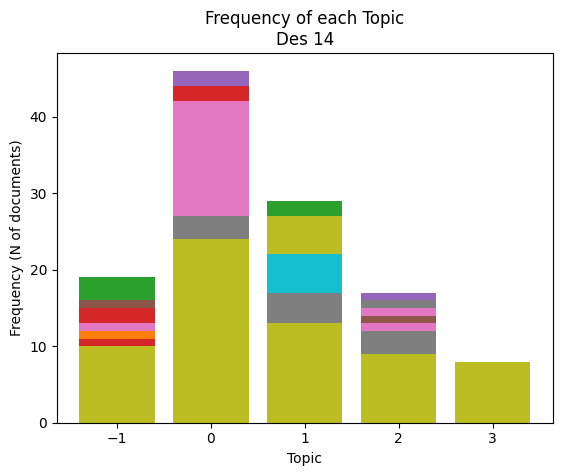






TOPIC 0 most representative documents:

1.
 Los subsidios deberían aplicarse a los empleados no a las empresas


2.
 De izquierda. Porque claramente generan más conciencia social. 


3.
 Se debe subsidiar al consumidor que debe viajar por trabajo o necesidad no a la empresa con un criterio lógico basado en el costo de vida







TOPIC 1 most representative documents:

1.
 Considero que el estado debe intervenir orientando el desarrollo en función de las necesidades de la población, garantizándolos como derechos.


2.
 Muy a favor de las ideas que mejoren la situación de la gente q tiene menos ingresos y  oportunidades


3.
 Creo que el sistema político económico esta en decadencia se deben buscar nuevas formas de organizacion







TOPIC 3 most representative documents:

1.
 Creo que el tema de los planes sociales genera posiciones estereotipadas. Y reaviva preconceptos y prejuicios. Creo que los planes son necesarios para los que más desfavorecidos están en la escala social, lo

In [24]:
key = '14'

documents = df_desafio[key]

continue_loop = True
while continue_loop:
    try:
        model = bert_model_create()
        bertopic_plots(model, documents, key)
        continue_loop = False
    except:
        print('Failed. Trying again.')

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

2022-12-19 19:47:54,647 - BERTopic - Transformed documents to Embeddings
2022-12-19 19:47:56,012 - BERTopic - Reduced dimensionality
2022-12-19 19:47:56,022 - BERTopic - Clustered reduced embeddings
2022-12-19 19:47:56,576 - BERTopic - Reduced number of topics from 5 to 5


<div style="text-align:center;"><span style="font-size:48px;color:blue;">Desafío 15</span></div>

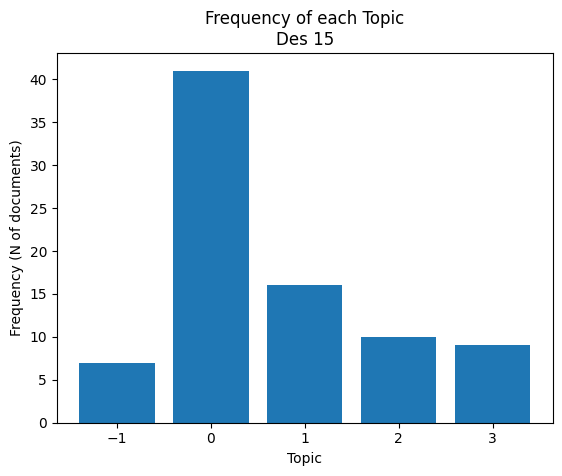






TOPIC 0 most representative documents:

1.
 Me definiría como liberal. El estado no tiene por que intervenir en el mercado, por lo que hemos vivido hasta ahora en este país, queda demostrado.


2.
 Totalmente en contra. La finalidad de cualquier empresa es ser rentable. Partiendo de esa premisa el coste del pasaje tiene que dar lugar a cubrir sus gastos y tener un margen. Se torna complicado cuando hablamos de empresas que prestan un servicio publico, pero si no podemos afrontar el coste real de un pasaje sin subsidios con un sueldo basico, eso nos dice que algo anda muy mal y las empresas no son el problema.


3.
 Socialismo, partidos de izquierda... aunque muchas veces las acciones y decisiones de estos sectores no me representan porque actúan en base a intereses personales.. Hoy el sector que más representa mis intereses es el peronismo/kirchnerismo. 







TOPIC 1 most representative documents:

1.
 El Estado regule, equitativo


2.
 Estela de carloto, por su valentía y lucha

In [25]:
key = '15'

documents = df_desafio[key]

continue_loop = True
while continue_loop:
    try:
        model = bert_model_create()
        bertopic_plots(model, documents, key)
        continue_loop = False
    except:
        print('Failed. Trying again.')

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

2022-12-19 19:48:18,224 - BERTopic - Transformed documents to Embeddings
2022-12-19 19:48:19,573 - BERTopic - Reduced dimensionality
2022-12-19 19:48:19,581 - BERTopic - Clustered reduced embeddings
2022-12-19 19:48:20,063 - BERTopic - Reduced number of topics from 3 to 3


Failed. Trying again.


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

2022-12-19 19:48:29,122 - BERTopic - Transformed documents to Embeddings
2022-12-19 19:48:30,466 - BERTopic - Reduced dimensionality
2022-12-19 19:48:30,475 - BERTopic - Clustered reduced embeddings
2022-12-19 19:48:30,975 - BERTopic - Reduced number of topics from 4 to 4
C:\Users\Felipe\miniconda3\lib\site-packages\scipy\sparse\linalg\_eigen\arpack\arpack.py:1592: RuntimeWarning:

k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.



Failed. Trying again.


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

2022-12-19 19:48:39,928 - BERTopic - Transformed documents to Embeddings
2022-12-19 19:48:41,266 - BERTopic - Reduced dimensionality
2022-12-19 19:48:41,275 - BERTopic - Clustered reduced embeddings
2022-12-19 19:48:41,824 - BERTopic - Reduced number of topics from 3 to 3


Failed. Trying again.


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

2022-12-19 19:48:50,732 - BERTopic - Transformed documents to Embeddings
2022-12-19 19:48:52,077 - BERTopic - Reduced dimensionality
2022-12-19 19:48:52,085 - BERTopic - Clustered reduced embeddings
2022-12-19 19:48:52,753 - BERTopic - Reduced number of topics from 5 to 5


<div style="text-align:center;"><span style="font-size:48px;color:blue;">Desafío 16</span></div>

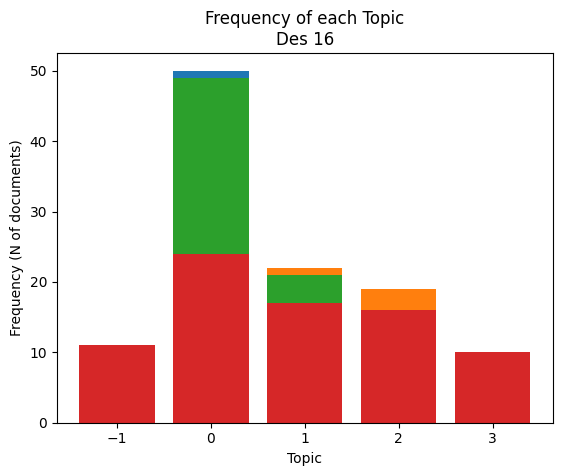






TOPIC 3 most representative documents:

1.
 Nacionalista y popular. Porque considero que la economía se debe manejar en función de los intereses de las mayorías, las clases populares y los intereses nacionales, en defensa de la patria y sus recursos, y defender un mercado interno fuerte con buenos salarios 


2.
 Cristina Fernández de Kirchner. Creo que es la una de las pocas personas que garantiza que se defiendan los derechos de las clases populares, el interés nacional y nuestros recursos naturales (como el petróleo, el litio y el agua)


3.
 Estoy de acuerdo en parte mientras se controle a quien se le otorga y acostumbramiento que esto genere. 







TOPIC 0 most representative documents:

1.
 De Izquierda pensando en igualar 


2.
 Estoy de acuerdo con la ayuda del Estado para la gente que no tiene recursos. Sobre todo para cubrir las necesidades básicas como la comida, y también el alquiler ya que es imposible acceder a una vivienda propia. Me parece interesante resaltar, y

In [26]:
key = '16'

documents = df_desafio[key]

continue_loop = True
while continue_loop:
    try:
        model = bert_model_create()
        bertopic_plots(model, documents, key)
        continue_loop = False
    except:
        print('Failed. Trying again.')

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

2022-12-19 19:49:12,670 - BERTopic - Transformed documents to Embeddings
2022-12-19 19:49:14,035 - BERTopic - Reduced dimensionality
2022-12-19 19:49:14,044 - BERTopic - Clustered reduced embeddings
2022-12-19 19:49:14,806 - BERTopic - Reduced number of topics from 5 to 5


<div style="text-align:center;"><span style="font-size:48px;color:blue;">Desafío 17</span></div>

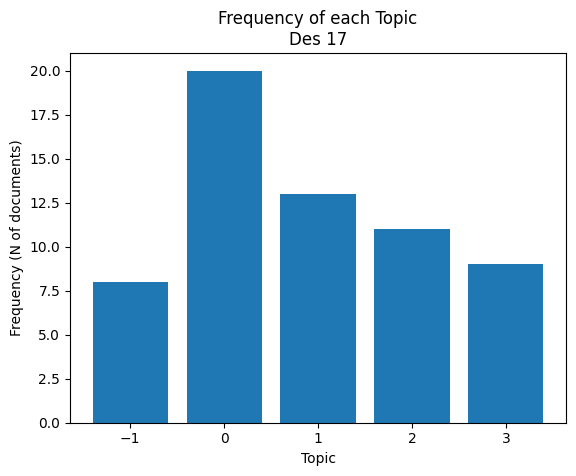






TOPIC 0 most representative documents:

1.
 Estela de carloto, por su valentía y lucha


2.
 Me siento más identificado con los partidos de izquierda porque son los que luchan contra la desigualdad y no la ven como algo natural, como sí lo hace la derecha


3.
 Pienso que el Estado debe tener un rol activo en la resolución de problemas, lo cual incluye por supuesto garantizar el derecho a la alimentación y la salud entre otras cuestiones. Los planes sociales deben ir acompañados de proyectos de inclusión laboral.







TOPIC 3 most representative documents:

1.
 No tengo una posición muy formada, pero me identifico con el liberalismo. Completamente liberal en lo social, y relativamente en lo económico. 


2.
 Creo que hay una idea errónea de los planes sociales. Muchas veces se los confunde con los salarios complementarios, que cobran muchas personas que ya trabajan, solo que lo hacen en la informalidad y sin derechos. Coincido con que el Estado debe ayudar a garantizar los derec

In [27]:
key = '17'

documents = df_desafio[key]

continue_loop = True
while continue_loop:
    try:
        model = bert_model_create()
        bertopic_plots(model, documents, key)
        continue_loop = False
    except:
        print('Failed. Trying again.')

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

2022-12-19 19:49:32,473 - BERTopic - Transformed documents to Embeddings
2022-12-19 19:49:34,473 - BERTopic - Reduced dimensionality
2022-12-19 19:49:34,480 - BERTopic - Clustered reduced embeddings
2022-12-19 19:49:34,914 - BERTopic - Reduced number of topics from 3 to 3


Failed. Trying again.


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

2022-12-19 19:49:42,499 - BERTopic - Transformed documents to Embeddings
2022-12-19 19:49:43,830 - BERTopic - Reduced dimensionality
2022-12-19 19:49:43,837 - BERTopic - Clustered reduced embeddings
2022-12-19 19:49:44,349 - BERTopic - Reduced number of topics from 3 to 3


Failed. Trying again.


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

2022-12-19 19:49:51,990 - BERTopic - Transformed documents to Embeddings
2022-12-19 19:49:53,319 - BERTopic - Reduced dimensionality
2022-12-19 19:49:53,327 - BERTopic - Clustered reduced embeddings
2022-12-19 19:49:53,836 - BERTopic - Reduced number of topics from 4 to 4
C:\Users\Felipe\miniconda3\lib\site-packages\scipy\sparse\linalg\_eigen\arpack\arpack.py:1592: RuntimeWarning:

k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.



Failed. Trying again.


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

2022-12-19 19:50:01,405 - BERTopic - Transformed documents to Embeddings
2022-12-19 19:50:02,748 - BERTopic - Reduced dimensionality
2022-12-19 19:50:02,756 - BERTopic - Clustered reduced embeddings
2022-12-19 19:50:03,184 - BERTopic - Reduced number of topics from 3 to 3


Failed. Trying again.


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

2022-12-19 19:50:10,989 - BERTopic - Transformed documents to Embeddings
2022-12-19 19:50:12,328 - BERTopic - Reduced dimensionality
2022-12-19 19:50:12,335 - BERTopic - Clustered reduced embeddings
2022-12-19 19:50:12,772 - BERTopic - Reduced number of topics from 3 to 3


Failed. Trying again.


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

2022-12-19 19:50:20,386 - BERTopic - Transformed documents to Embeddings
2022-12-19 19:50:21,725 - BERTopic - Reduced dimensionality
2022-12-19 19:50:21,732 - BERTopic - Clustered reduced embeddings
2022-12-19 19:50:22,226 - BERTopic - Reduced number of topics from 3 to 3


Failed. Trying again.


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

2022-12-19 19:50:29,964 - BERTopic - Transformed documents to Embeddings
2022-12-19 19:50:31,951 - BERTopic - Reduced dimensionality
2022-12-19 19:50:31,958 - BERTopic - Clustered reduced embeddings
2022-12-19 19:50:32,424 - BERTopic - Reduced number of topics from 3 to 3


Failed. Trying again.


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

2022-12-19 19:50:40,046 - BERTopic - Transformed documents to Embeddings
2022-12-19 19:50:41,394 - BERTopic - Reduced dimensionality
2022-12-19 19:50:41,402 - BERTopic - Clustered reduced embeddings
2022-12-19 19:50:41,810 - BERTopic - Reduced number of topics from 3 to 3


Failed. Trying again.


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

2022-12-19 19:50:49,502 - BERTopic - Transformed documents to Embeddings
2022-12-19 19:50:50,839 - BERTopic - Reduced dimensionality
2022-12-19 19:50:50,846 - BERTopic - Clustered reduced embeddings
2022-12-19 19:50:51,345 - BERTopic - Reduced number of topics from 3 to 3


Failed. Trying again.


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

2022-12-19 19:50:59,117 - BERTopic - Transformed documents to Embeddings
2022-12-19 19:51:00,465 - BERTopic - Reduced dimensionality
2022-12-19 19:51:00,472 - BERTopic - Clustered reduced embeddings
2022-12-19 19:51:00,963 - BERTopic - Reduced number of topics from 3 to 3


Failed. Trying again.


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

2022-12-19 19:51:08,668 - BERTopic - Transformed documents to Embeddings
2022-12-19 19:51:10,057 - BERTopic - Reduced dimensionality
2022-12-19 19:51:10,064 - BERTopic - Clustered reduced embeddings
2022-12-19 19:51:10,462 - BERTopic - Reduced number of topics from 2 to 2


Failed. Trying again.


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

2022-12-19 19:51:18,184 - BERTopic - Transformed documents to Embeddings
2022-12-19 19:51:19,513 - BERTopic - Reduced dimensionality
2022-12-19 19:51:19,521 - BERTopic - Clustered reduced embeddings
2022-12-19 19:51:20,036 - BERTopic - Reduced number of topics from 3 to 3


Failed. Trying again.


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

2022-12-19 19:51:27,762 - BERTopic - Transformed documents to Embeddings
2022-12-19 19:51:29,818 - BERTopic - Reduced dimensionality
2022-12-19 19:51:29,825 - BERTopic - Clustered reduced embeddings
2022-12-19 19:51:30,246 - BERTopic - Reduced number of topics from 3 to 3


Failed. Trying again.


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

2022-12-19 19:51:37,907 - BERTopic - Transformed documents to Embeddings
2022-12-19 19:51:39,248 - BERTopic - Reduced dimensionality
2022-12-19 19:51:39,255 - BERTopic - Clustered reduced embeddings
2022-12-19 19:51:39,736 - BERTopic - Reduced number of topics from 3 to 3


Failed. Trying again.


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

2022-12-19 19:51:47,432 - BERTopic - Transformed documents to Embeddings
2022-12-19 19:51:48,769 - BERTopic - Reduced dimensionality
2022-12-19 19:51:48,776 - BERTopic - Clustered reduced embeddings
2022-12-19 19:51:49,150 - BERTopic - Reduced number of topics from 2 to 2


Failed. Trying again.


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

2022-12-19 19:51:56,894 - BERTopic - Transformed documents to Embeddings
2022-12-19 19:51:58,231 - BERTopic - Reduced dimensionality
2022-12-19 19:51:58,238 - BERTopic - Clustered reduced embeddings
2022-12-19 19:51:58,670 - BERTopic - Reduced number of topics from 3 to 3


Failed. Trying again.


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

2022-12-19 19:52:06,386 - BERTopic - Transformed documents to Embeddings
2022-12-19 19:52:07,733 - BERTopic - Reduced dimensionality
2022-12-19 19:52:07,740 - BERTopic - Clustered reduced embeddings
2022-12-19 19:52:08,041 - BERTopic - Reduced number of topics from 2 to 2


Failed. Trying again.


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

2022-12-19 19:52:15,808 - BERTopic - Transformed documents to Embeddings
2022-12-19 19:52:17,173 - BERTopic - Reduced dimensionality
2022-12-19 19:52:17,180 - BERTopic - Clustered reduced embeddings
2022-12-19 19:52:17,678 - BERTopic - Reduced number of topics from 3 to 3


Failed. Trying again.


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

2022-12-19 19:52:25,411 - BERTopic - Transformed documents to Embeddings
2022-12-19 19:52:27,427 - BERTopic - Reduced dimensionality
2022-12-19 19:52:27,434 - BERTopic - Clustered reduced embeddings
2022-12-19 19:52:27,961 - BERTopic - Reduced number of topics from 3 to 3


Failed. Trying again.


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

2022-12-19 19:52:35,650 - BERTopic - Transformed documents to Embeddings
2022-12-19 19:52:37,030 - BERTopic - Reduced dimensionality
2022-12-19 19:52:37,037 - BERTopic - Clustered reduced embeddings
2022-12-19 19:52:37,462 - BERTopic - Reduced number of topics from 3 to 3


Failed. Trying again.


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

2022-12-19 19:52:45,167 - BERTopic - Transformed documents to Embeddings
2022-12-19 19:52:46,522 - BERTopic - Reduced dimensionality
2022-12-19 19:52:46,530 - BERTopic - Clustered reduced embeddings
2022-12-19 19:52:47,088 - BERTopic - Reduced number of topics from 4 to 4
C:\Users\Felipe\miniconda3\lib\site-packages\scipy\sparse\linalg\_eigen\arpack\arpack.py:1592: RuntimeWarning:

k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.



Failed. Trying again.


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

2022-12-19 19:52:54,685 - BERTopic - Transformed documents to Embeddings
2022-12-19 19:52:56,055 - BERTopic - Reduced dimensionality
2022-12-19 19:52:56,062 - BERTopic - Clustered reduced embeddings
2022-12-19 19:52:56,540 - BERTopic - Reduced number of topics from 3 to 3


Failed. Trying again.


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

2022-12-19 19:53:04,232 - BERTopic - Transformed documents to Embeddings
2022-12-19 19:53:05,617 - BERTopic - Reduced dimensionality
2022-12-19 19:53:05,624 - BERTopic - Clustered reduced embeddings
2022-12-19 19:53:06,082 - BERTopic - Reduced number of topics from 3 to 3


Failed. Trying again.


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

2022-12-19 19:53:13,799 - BERTopic - Transformed documents to Embeddings
2022-12-19 19:53:15,142 - BERTopic - Reduced dimensionality
2022-12-19 19:53:15,150 - BERTopic - Clustered reduced embeddings
2022-12-19 19:53:15,764 - BERTopic - Reduced number of topics from 4 to 4
C:\Users\Felipe\miniconda3\lib\site-packages\scipy\sparse\linalg\_eigen\arpack\arpack.py:1592: RuntimeWarning:

k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.



Failed. Trying again.


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

2022-12-19 19:53:24,232 - BERTopic - Transformed documents to Embeddings
2022-12-19 19:53:25,602 - BERTopic - Reduced dimensionality
2022-12-19 19:53:25,610 - BERTopic - Clustered reduced embeddings
2022-12-19 19:53:25,919 - BERTopic - Reduced number of topics from 2 to 2


Failed. Trying again.


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

2022-12-19 19:53:33,991 - BERTopic - Transformed documents to Embeddings
2022-12-19 19:53:35,380 - BERTopic - Reduced dimensionality
2022-12-19 19:53:35,387 - BERTopic - Clustered reduced embeddings
2022-12-19 19:53:35,849 - BERTopic - Reduced number of topics from 3 to 3


Failed. Trying again.


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

2022-12-19 19:53:44,012 - BERTopic - Transformed documents to Embeddings
2022-12-19 19:53:45,383 - BERTopic - Reduced dimensionality
2022-12-19 19:53:45,391 - BERTopic - Clustered reduced embeddings
2022-12-19 19:53:46,162 - BERTopic - Reduced number of topics from 5 to 5


<div style="text-align:center;"><span style="font-size:48px;color:blue;">Desafío 18</span></div>

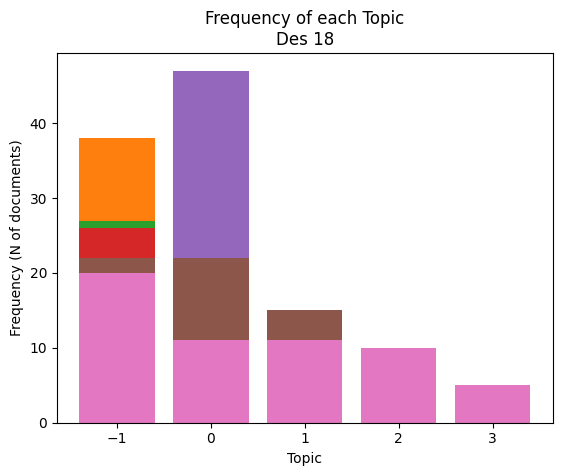






TOPIC 0 most representative documents:

1.
 A ninguna, ninguna figura relativamente conocida me genera esas emociones.


2.
 Se debe subsidiar al consumidor que debe viajar por trabajo o necesidad no a la empresa con un criterio lógico basado en el costo de vida


3.
 Muy difícil de responder. Puedo pensar solo en referentes científicos y deportistas.







TOPIC 1 most representative documents:

1.
 Cristina Fernández de Kirchner. Principal referente política del país.


2.
 No tengo referente


3.
 Creo que las narrativas en términos politicos y económicos actuales no están a la altura del mundo actual. Son ideologías viejas surgidas en contextos totalmente diferentes, no responden a las necesidades del mundo actual, sus problemáticas y sus avances. Estamos viviendo el inicio de la cuarta revolución industrial y tenemos herramientas sociales de la era de los motores a vapor. Pero respondiendo a la consigna; creo que en términos económicos me siento mas identificado con el libre

In [28]:
key = '18'

documents = df_desafio[key]

continue_loop = True
while continue_loop:
    try:
        model = bert_model_create()
        bertopic_plots(model, documents, key)
        continue_loop = False
    except:
        print('Failed. Trying again.')